# ***NOTEBOOK FOR ANALYSING THE `SYNTHEA` DATA***
***
- ***GOAL IS TO FIND STRONG REASONS BEHIND PATIENTS READMISSION***

## **Starting of Analysis**

### ***Data Import, Creating Connection and Checking the data***

In [1]:
import os
from pathlib import Path

def get_project_root(project_name="ranojoy_data_analytics_projects"):
    """
    Universally finds the project root.
    1. Checks if we are inside the project (standard usage).
    2. Checks if we are above the project (your specific usage).
    """
    current_path = Path.cwd()

    # CASE 1: Standard Usage (Running from inside the repo)
    if project_name in str(current_path):
        while current_path.name != project_name:
            current_path = current_path.parent
        return current_path

    # CASE 2: Your Setup (Running from 'Machine' or a parent folder)
    # We search specifically for the project folder inside the current directory
    # limiting depth to 4 levels to keep it fast.
    else:
        # rglob searches recursively for the folder name
        for path in current_path.rglob(project_name):
            if path.is_dir():
                return path
        
        raise FileNotFoundError(f"Could not find project: {project_name}")

# --- USAGE ---
repo_root = get_project_root()

data_path = repo_root / "About Synthea - Why Patients Readmit More"
print(data_path)

C:\Users\Rano's PC\Machine\github_repo_cloned\ranojoy_data_analytics_projects\About Synthea - Why Patients Readmit More


In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(f"{data_path}"))

import src.plots as P
import src.stat_tests as S

In [3]:
# The Correct Way (Universal)
file_path = data_path / "data" / "processed_data" / "processed_synthea_data.csv"

data = pd.read_csv(file_path)

In [4]:
pd.set_option('display.max_columns',None)

In [5]:
data.head()

encounterclass  encounter_duration  total_procedures  avg_procedure_cost  \
0       WELLNESS                30.0                 1              648.01   
1       WELLNESS                15.0                 0                0.00   
2     AMBULATORY                30.0                 1             2230.40   
3     AMBULATORY                15.0                 0                0.00   
4       WELLNESS                30.0                 1              590.58   

   total_medicines  avg_base_medicine_cost  avg_total_medicine_cost  \
0                0                    0.00                     0.00   
1                0                    0.00                     0.00   
2                0                    0.00                     0.00   
3                1                   20.48                    20.48   
4                0                    0.00                     0.00   

   reasons_for_medications is_ongoing_condition  total_conditions  \
0                        0         NO CONDITION                 0   
1                        0         NO CONDITION                 0   
2                        0                   NO                 1   
3                        1                   NO                 1   
4                        0         NO CONDITION                 0   

  is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
0         NO CAREPLAN                0           18  UNKNOWN  WHITE   
1         NO CAREPLAN                0           18  UNKNOWN  WHITE   
2         NO CAREPLAN                0           18  UNKNOWN  WHITE   
3         NO CAREPLAN                0           18  UNKNOWN  WHITE   
4         NO CAREPLAN                0           18  UNKNOWN  WHITE   

     ethnicity patient_gender provider_gender  utilization caused_readmission  \
0  NONHISPANIC              M               M           25                 NO   
1  NONHISPANIC              M               M           25                 NO   
2  NONHISPANIC              M               M         1616                 NO   
3  NONHISPANIC              M               M         1616                 NO   
4  NONHISPANIC              M               M           25                 NO   

   condition_duration  careplan_duration  visit_number  coverage_ratio  \
0                   0                  0             1            1.00   
1                   0                  0             2            1.00   
2                   9                  0             3            0.42   
3                  12                  0             4            0.42   
4                   0                  0             5            1.00   

   medication_duration  procedures_per_hour  
0                    0                  1.0  
1                    0                  0.0  
2                    0                  1.0  
3                   12                  0.0  
4                    0                  1.0

### ***Initial Data Health Check***

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53346 entries, 0 to 53345
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   encounterclass           53346 non-null  object 
 1   encounter_duration       53346 non-null  float64
 2   total_procedures         53346 non-null  int64  
 3   avg_procedure_cost       53346 non-null  float64
 4   total_medicines          53346 non-null  int64  
 5   avg_base_medicine_cost   53346 non-null  float64
 6   avg_total_medicine_cost  53346 non-null  float64
 7   reasons_for_medications  53346 non-null  int64  
 8   is_ongoing_condition     53346 non-null  object 
 9   total_conditions         53346 non-null  int64  
 10  is_ongoing_careplan      53346 non-null  object 
 11  total_careplans          53346 non-null  int64  
 12  age_as_2022              53346 non-null  int64  
 13  marital                  53346 non-null  object 
 14  race                  

In [7]:
rows,columns = data.shape
print(f"Rows -> {rows}")
print(f"Columns -> {columns}")

Rows -> 53346
Columns -> 26


In [8]:
data.isnull().sum()[data.isnull().sum()>0].reset_index(name = 'null_counts')

Empty DataFrame
Columns: [index, null_counts]
Index: []

In [9]:
data.duplicated().sum()

np.int64(127)

- ***there are `duplicated` values***

In [10]:
data.describe().round(2).T

count      mean        std   min    25%     50%  \
encounter_duration       53346.0  31489.33  835605.88  15.0  15.00   27.00   
total_procedures         53346.0      0.66       1.70   0.0   0.00    0.00   
avg_procedure_cost       53346.0   2129.45    5596.18   0.0   0.00    0.00   
total_medicines          53346.0      0.80       1.20   0.0   0.00    1.00   
avg_base_medicine_cost   53346.0    162.61     406.75   0.0   0.00    6.80   
avg_total_medicine_cost  53346.0   1431.68    9931.92   0.0   0.00    7.22   
reasons_for_medications  53346.0      0.50       0.61   0.0   0.00    0.00   
total_conditions         53346.0      0.16       0.41   0.0   0.00    0.00   
total_careplans          53346.0      0.07       0.25   0.0   0.00    0.00   
age_as_2022              53346.0     55.66      25.87   0.0  35.00   58.00   
utilization              53346.0   1329.70    1427.73   1.0  86.00  821.00   
condition_duration       53346.0      7.54     156.39   0.0   0.00    0.00   
careplan_duration        53346.0      7.11     117.53   0.0   0.00    0.00   
visit_number             53346.0    127.88     300.86   1.0  12.00   30.00   
coverage_ratio           53346.0      0.48       0.34   0.0   0.23    0.54   
medication_duration      53346.0    122.99     443.13   0.0   0.00    0.00   
procedures_per_hour      53346.0      0.45       0.75   0.0   0.00    0.00   

                             75%          max  
encounter_duration         45.00  45964800.00  
total_procedures            1.00        21.00  
avg_procedure_cost        602.04    187968.69  
total_medicines             1.00        10.00  
avg_base_medicine_cost    263.49      6901.17  
avg_total_medicine_cost  1783.74   1296594.95  
reasons_for_medications     1.00         4.00  
total_conditions            0.00         7.00  
total_careplans             0.00         2.00  
age_as_2022                73.00       112.00  
utilization              2159.00      4828.00  
condition_duration          0.00     17947.00  
careplan_duration           0.00     10204.00  
visit_number               69.00      2006.00  
coverage_ratio              0.69         1.00  
medication_duration       361.00     24091.00  
procedures_per_hour         1.00         4.00

***Knowledge from Initial Health Check:***

- There is scenario where `age is 0`, need to check that

In [11]:
data[data['age_as_2022'] ==0]

encounterclass  encounter_duration  total_procedures  \
12642       WELLNESS                15.0                 0   
12643      EMERGENCY               144.0                 2   
12644       WELLNESS                30.0                 1   
12645      EMERGENCY               209.0                 1   
12646       WELLNESS                30.0                 1   
12647      EMERGENCY               138.0                 1   
12648       WELLNESS                30.0                 1   
12649     OUTPATIENT                15.0                 0   
12650       WELLNESS                15.0                 0   
12651       WELLNESS                15.0                 0   
21660       WELLNESS                15.0                 0   
21661       WELLNESS                15.0                 0   
21662       WELLNESS                30.0                 1   
21663       WELLNESS                30.0                 1   
21664       WELLNESS                15.0                 0   
21665       WELLNESS                15.0                 0   
21666      EMERGENCY                60.0                 0   

       avg_procedure_cost  total_medicines  avg_base_medicine_cost  \
12642                0.00                0                    0.00   
12643             8767.99                1                  158.21   
12644              705.72                0                    0.00   
12645            11712.93                1                  892.68   
12646              597.26                0                    0.00   
12647            13533.45                0                    0.00   
12648              458.61                0                    0.00   
12649                0.00                2                   13.78   
12650                0.00                0                    0.00   
12651                0.00                0                    0.00   
21660                0.00                0                    0.00   
21661                0.00                0                    0.00   
21662              348.31                0                    0.00   
21663              747.64                0                    0.00   
21664                0.00                0                    0.00   
21665                0.00                0                    0.00   
21666                0.00                0                    0.00   

       avg_total_medicine_cost  reasons_for_medications is_ongoing_condition  \
12642                     0.00                        0         NO CONDITION   
12643                  1423.89                        0                  YES   
12644                     0.00                        0         NO CONDITION   
12645                  7141.44                        0         NO CONDITION   
12646                     0.00                        0         NO CONDITION   
12647                     0.00                        0         NO CONDITION   
12648                     0.00                        0         NO CONDITION   
12649                    13.78                        0                   NO   
12650                     0.00                        0         NO CONDITION   
12651                     0.00                        0         NO CONDITION   
21660                     0.00                        0         NO CONDITION   
21661                     0.00                        0         NO CONDITION   
21662                     0.00                        0         NO CONDITION   
21663                     0.00                        0         NO CONDITION   
21664                     0.00                        0         NO CONDITION   
21665                     0.00                        0         NO CONDITION   
21666                     0.00                        0                  YES   

       total_conditions is_ongoing_careplan  total_careplans  age_as_2022  \
12642                 0         NO CAREPLAN                0            0   
12643                 2         N

- ***These 17 age values are actually patients who born in 2022 so it is showing age as 0, I can impute them with 1***

In [12]:
data['age_as_2022']=data['age_as_2022'].apply(lambda x: 1 if x==0 else x)

In [13]:
data['age_as_2022'].describe().round(2).reset_index()

index  age_as_2022
0  count     53346.00
1   mean        55.66
2    std        25.87
3    min         1.00
4    25%        35.00
5    50%        58.00
6    75%        73.00
7    max       112.00

In [14]:
data[data.duplicated()]

encounterclass  encounter_duration  total_procedures  \
7458        WELLNESS                15.0                 0   
8381        WELLNESS                15.0                 0   
8513        WELLNESS                15.0                 0   
8514        WELLNESS                15.0                 0   
8515        WELLNESS                15.0                 0   
...              ...                 ...               ...   
52409       WELLNESS                15.0                 0   
52578       WELLNESS                15.0                 0   
52857       WELLNESS                15.0                 0   
52860       WELLNESS                15.0                 0   
52870       WELLNESS                15.0                 0   

       avg_procedure_cost  total_medicines  avg_base_medicine_cost  \
7458                  0.0                0                     0.0   
8381                  0.0                0                     0.0   
8513                  0.0                0                     0.0   
8514                  0.0                0                     0.0   
8515                  0.0                0                     0.0   
...                   ...              ...                     ...   
52409                 0.0                0                     0.0   
52578                 0.0                0                     0.0   
52857                 0.0                0                     0.0   
52860                 0.0                0                     0.0   
52870                 0.0                0                     0.0   

       avg_total_medicine_cost  reasons_for_medications is_ongoing_condition  \
7458                       0.0                        0         NO CONDITION   
8381                       0.0                        0         NO CONDITION   
8513                       0.0                        0         NO CONDITION   
8514                       0.0                        0         NO CONDITION   
8515                       0.0                        0         NO CONDITION   
...                        ...                      ...                  ...   
52409                      0.0                        0         NO CONDITION   
52578                      0.0                        0         NO CONDITION   
52857                      0.0                        0         NO CONDITION   
52860                      0.0                        0         NO CONDITION   
52870                      0.0                        0         NO CONDITION   

       total_conditions is_ongoing_careplan  total_careplans  age_as_2022  \
7458                  0         NO CAREPLAN                0           18   
8381                  0         NO CAREPLAN                0           12   
8513                  0         NO CAREPLAN                0            7   
8514                  0         NO CAREPLAN                0            7   
8515                  0         NO CAREPLAN                0            7   
...                 ...                 ...              ...          ...   
52409                 0         NO CAREPLAN                0           50   
52578                 0         NO CAREPLAN                0           40   
52857                 0         NO CAREPLAN                0           13   
52860                 0         NO CAREPLAN                0           13   
52870                 0         NO CAREPLAN                0           13   

       marital   race    ethnicity patient_gender provider_gender  \
7458   UNKNOWN  WHITE  NONHISPANIC              M               M   
8381   UNKNOWN  WHITE  NONHISPANIC              M               F   
8513   UNKNOWN  WHITE  NONHISPANIC              F               F   
8514   UNKNOWN  WHITE  NONHISPANIC              F               F   
8515   UNKNOWN  WHITE  NONHISPANIC              F               F   
...        ...    ...          ...            ...             ...   
52409  MARRIED  WHITE  NONHISPANIC              F  

- ***There are 64 duplicate values, as there is no primary key - duplicates are not actually duplicate, it can be different entries with same values, so I am keeping them***

In [15]:
data.select_dtypes(include='object').describe().T

count unique           top   freq
encounterclass        53346      6      WELLNESS  19106
is_ongoing_condition  53346      3  NO CONDITION  45696
is_ongoing_careplan   53346      3   NO CAREPLAN  49874
marital               53346      3       MARRIED  30413
race                  53346      5         WHITE  41794
ethnicity             53346      2   NONHISPANIC  49267
patient_gender        53346      2             F  26891
provider_gender       53346      2             F  31135
caused_readmission    53346      2            NO  32361

### ***Univariate Analysis***

**encounterclass**

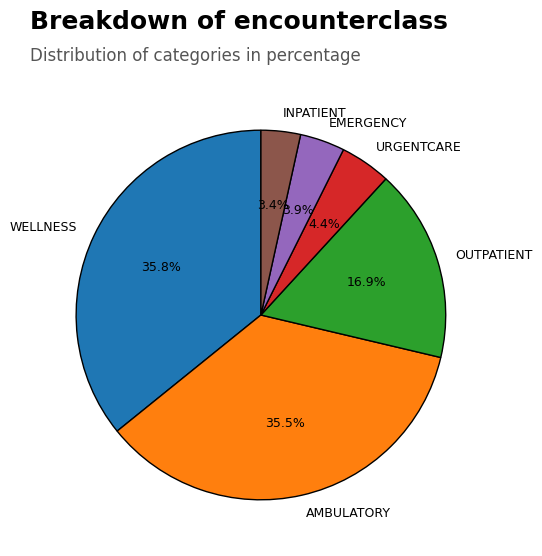

In [16]:
plt.figure(figsize=(6,6))
P.plot_pie('encounterclass',data)

- ***`Ambulatory` and `Wellness` have the most occurances among `6 different classes`***

**encounter_duration**

In [17]:
data['encounter_duration'].describe().round(2).reset_index()

index  encounter_duration
0  count            53346.00
1   mean            31489.33
2    std           835605.88
3    min               15.00
4    25%               15.00
5    50%               27.00
6    75%               45.00
7    max         45964800.00

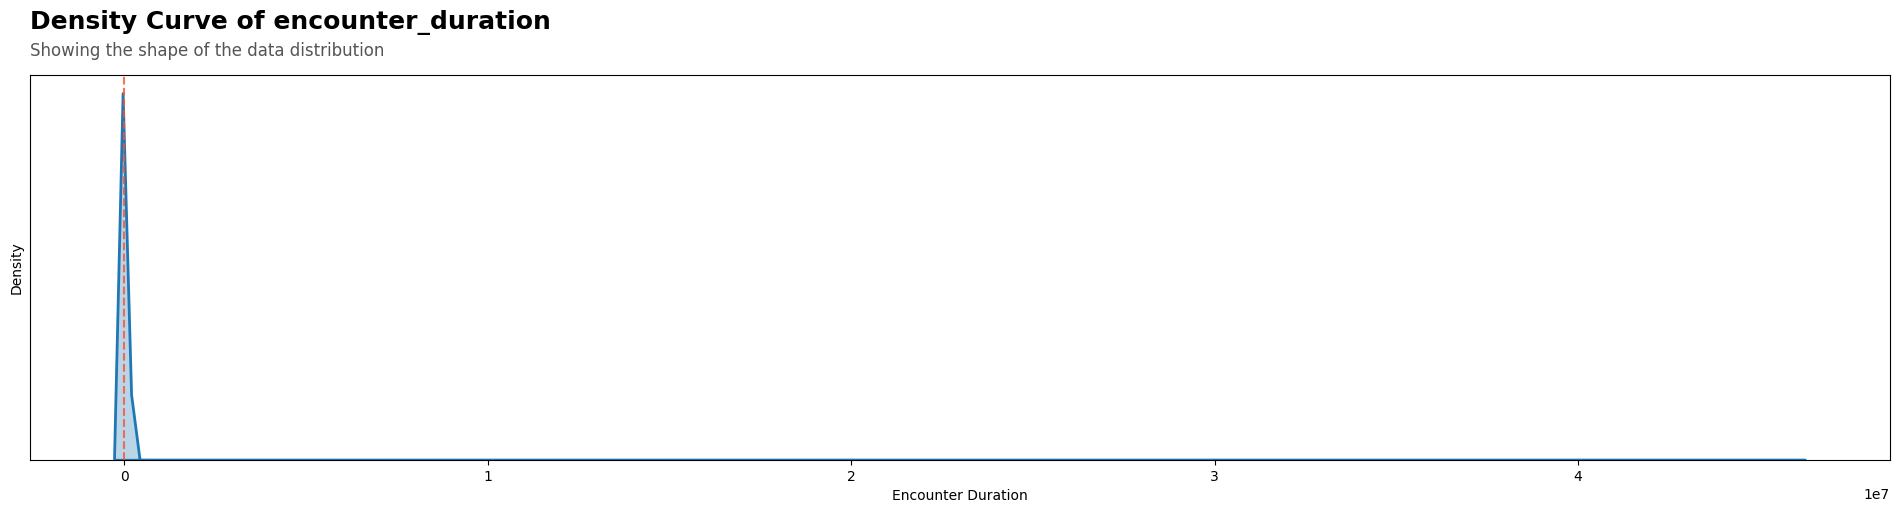

In [18]:
plt.figure(figsize=(24,5))
P.plot_kde('encounter_duration',data)

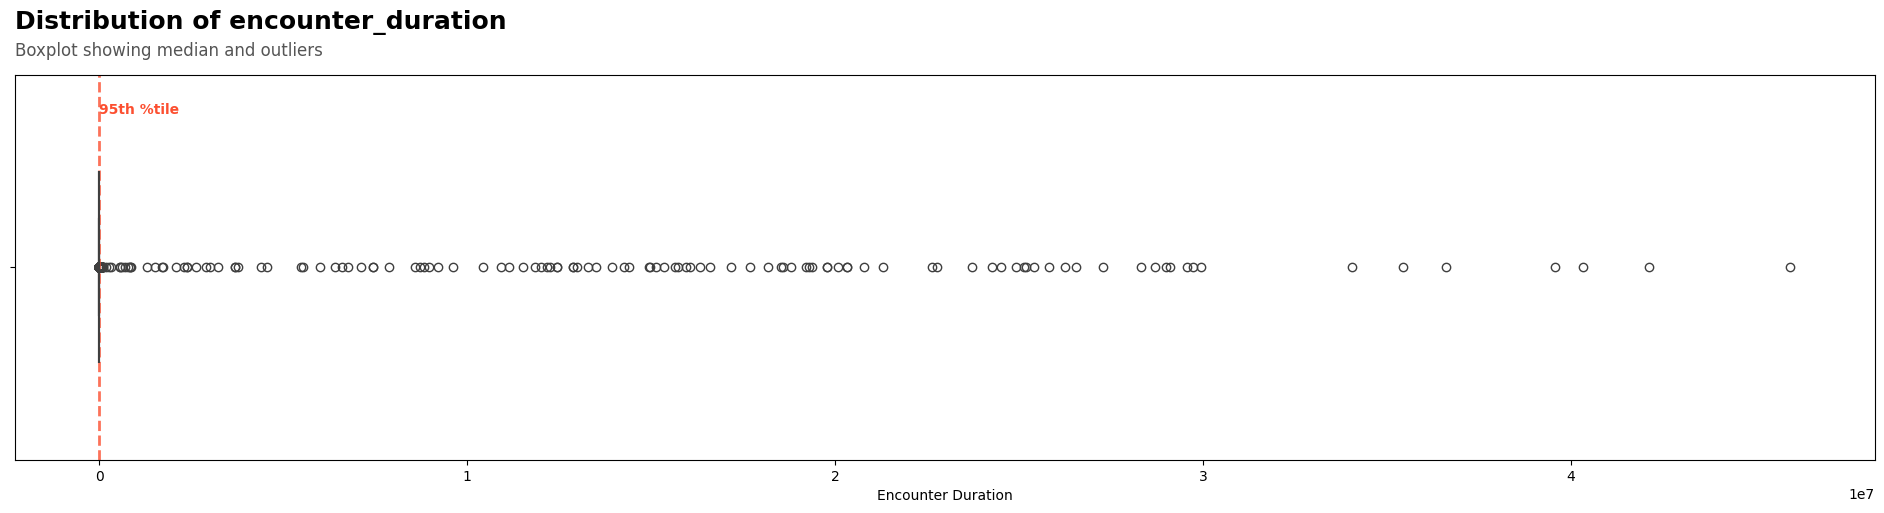

In [19]:
plt.figure(figsize=(24,5))
P.plot_box('encounter_duration',data)

In [20]:
data['encounter_duration'].skew().round(2)

np.float64(32.33)

- ***Encounter duration is skewed towards right, `skewness = ~24`***

**total_procedures**

In [21]:
data['total_procedures'].describe().round(2).reset_index()

index  total_procedures
0  count          53346.00
1   mean              0.66
2    std              1.70
3    min              0.00
4    25%              0.00
5    50%              0.00
6    75%              1.00
7    max             21.00

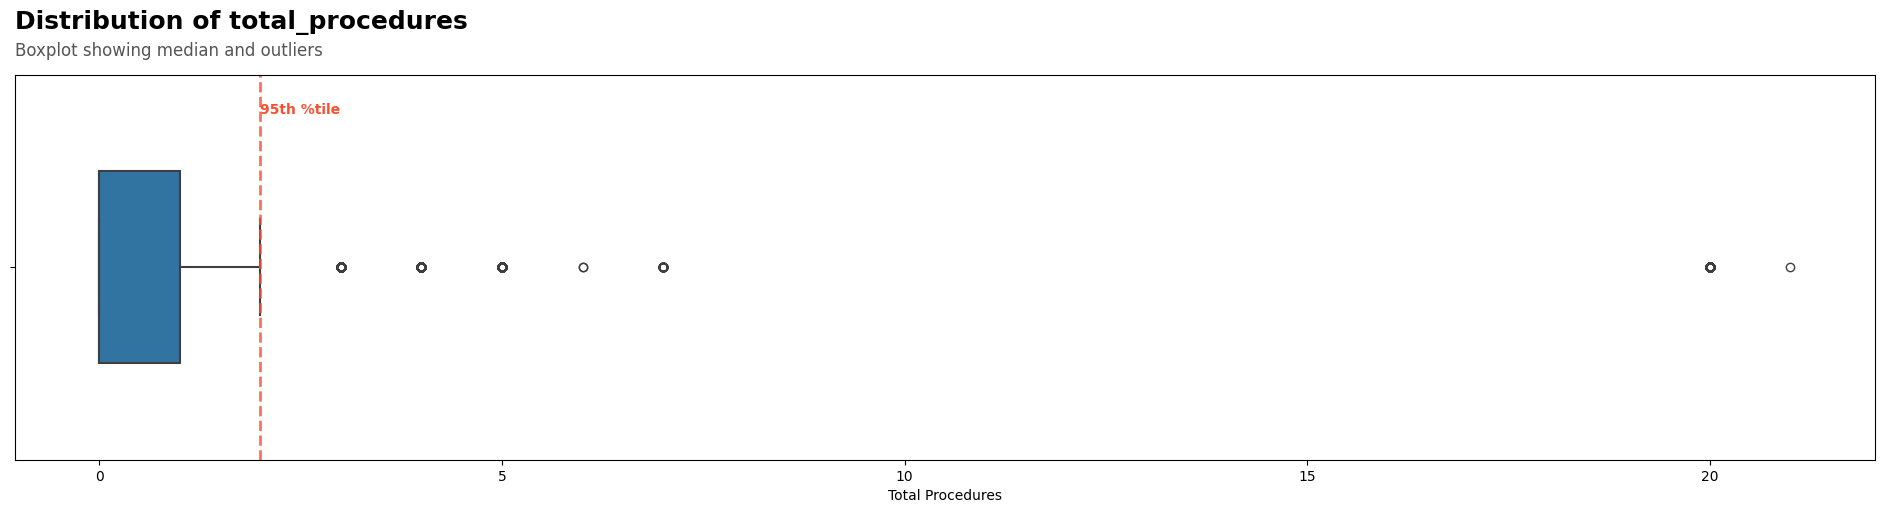

In [22]:
plt.figure(figsize=(24,5))
P.plot_box('total_procedures',data)

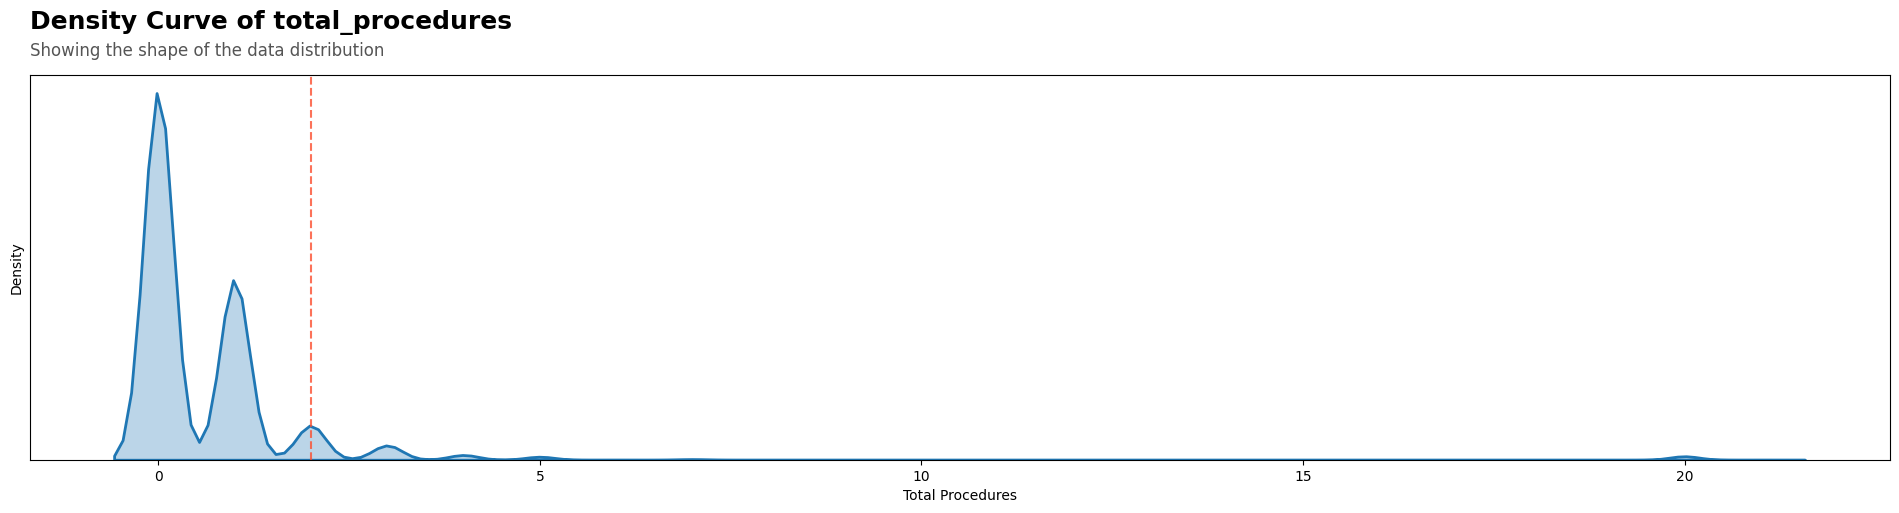

In [23]:
plt.figure(figsize=(24,5))
P.plot_kde('total_procedures',data)

In [24]:
data['total_procedures'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_procedures  percentage
0                 0       60.50
1                 1       29.59
2                 2        5.62
3                 3        2.35
4                 4        0.78
5                20        0.57
6                 5        0.49
7                 7        0.08
8                 6        0.00
9                21        0.00

In [25]:
bins = [-1, 0, 1, 100]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_procedures'] = pd.cut(data['total_procedures'], bins=bins, labels=labels)

In [26]:
data['total_procedures'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_procedures  percentage
0             NONE       60.50
1           SINGLE       29.59
2         MULTIPLE        9.91

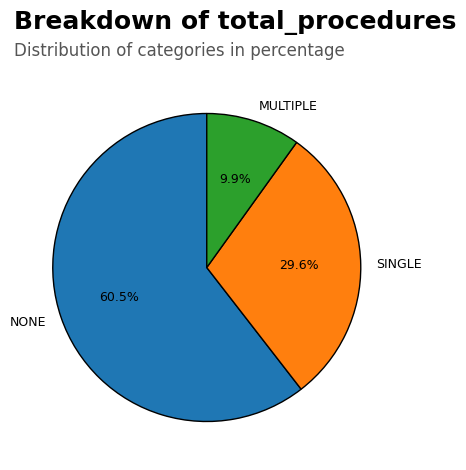

In [27]:
plt.figure(figsize=(24,5))
P.plot_pie('total_procedures',data)

- ***Changed the type of `total_procedures` - most of the observations have `none procedures` `~60% of overall observations`***

**avg_procedure_cost**

In [28]:
data['avg_procedure_cost'].describe().round(2).reset_index()

index  avg_procedure_cost
0  count            53346.00
1   mean             2129.45
2    std             5596.18
3    min                0.00
4    25%                0.00
5    50%                0.00
6    75%              602.04
7    max           187968.69

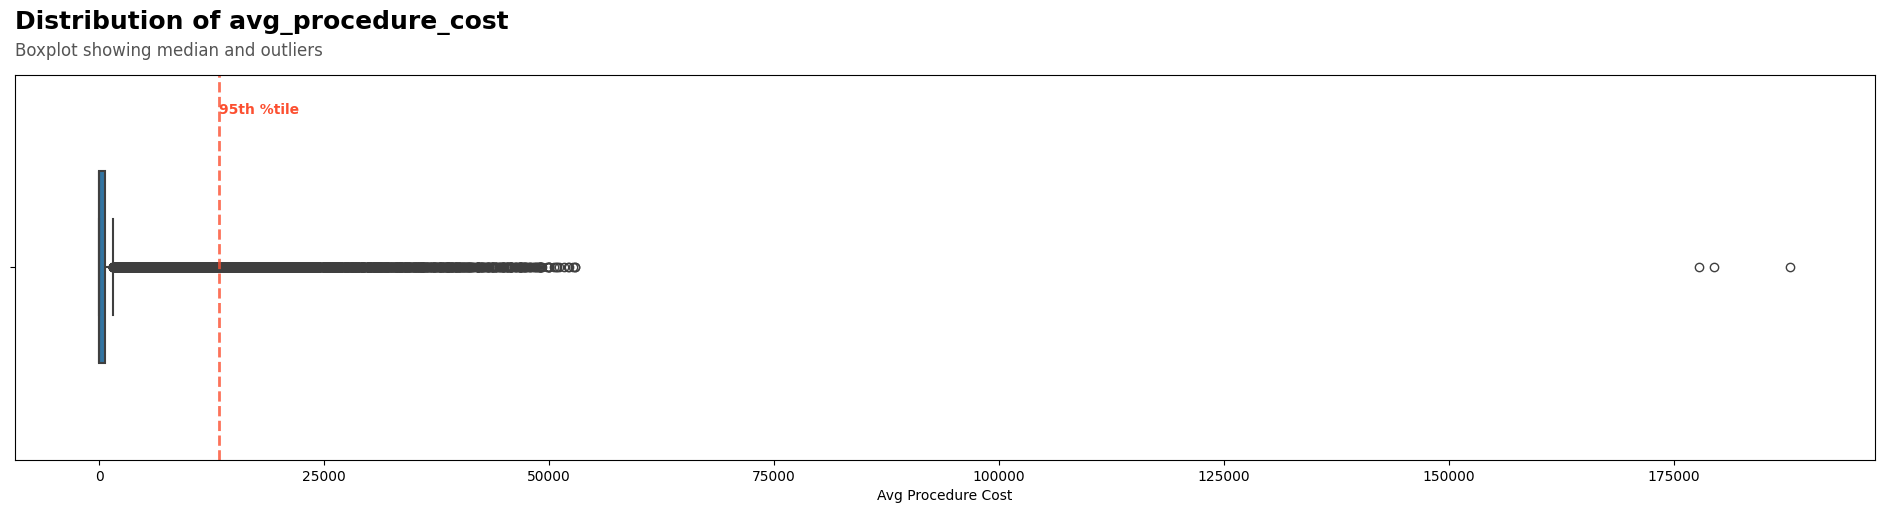

In [29]:
plt.figure(figsize=(24,5))
P.plot_box('avg_procedure_cost',data)

In [30]:
data[data['avg_procedure_cost']> 75000]

encounterclass  encounter_duration total_procedures  avg_procedure_cost  \
3214      INPATIENT              1800.0           SINGLE           187968.69   
4447      INPATIENT              1800.0           SINGLE           177834.83   
9318      INPATIENT              1740.0           SINGLE           179470.09   

      total_medicines  avg_base_medicine_cost  avg_total_medicine_cost  \
3214                0                     0.0                      0.0   
4447                0                     0.0                      0.0   
9318                0                     0.0                      0.0   

      reasons_for_medications is_ongoing_condition  total_conditions  \
3214                        0         NO CONDITION                 0   
4447                        0         NO CONDITION                 0   
9318                        0         NO CONDITION                 0   

     is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
3214         NO CAREPLAN                0           54  MARRIED  BLACK   
4447         NO CAREPLAN                0           41   SINGLE  WHITE   
9318         NO CAREPLAN                0           67   SINGLE  WHITE   

        ethnicity patient_gender provider_gender  utilization  \
3214  NONHISPANIC              F               F         1314   
4447  NONHISPANIC              M               M         1643   
9318     HISPANIC              M               F         2225   

     caused_readmission  condition_duration  careplan_duration  visit_number  \
3214                 NO                   0                  0            24   
4447                YES                   0                  0            13   
9318                YES                   0                  0            46   

      coverage_ratio  medication_duration  procedures_per_hour  
3214             0.0                    0                 0.03  
4447             0.0                    0                 0.03  
9318             0.0                    0                 0.03

- ***These outliers are actual values, we should remember the `extreme 3 outliers`***

In [31]:
data[data['avg_procedure_cost']< 75000]['avg_procedure_cost'].describe().round().reset_index()

index  avg_procedure_cost
0  count             53343.0
1   mean              2119.0
2    std              5432.0
3    min                 0.0
4    25%                 0.0
5    50%                 0.0
6    75%               602.0
7    max             52910.0

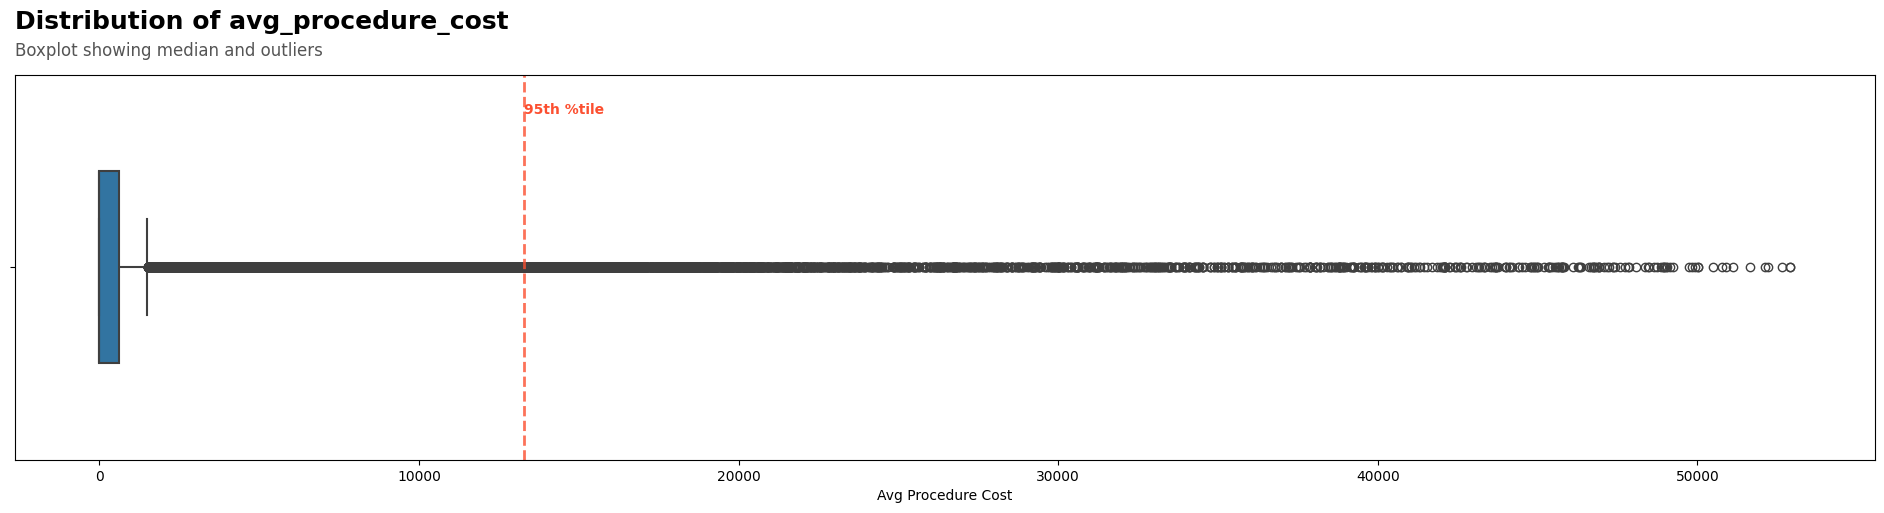

In [32]:
plt.figure(figsize=(24,5))
P.plot_box('avg_procedure_cost',data[data['avg_procedure_cost']< 75000])

In [33]:
data['avg_procedure_cost'].skew().round(2)

np.float64(5.54)

In [34]:
data[data['avg_procedure_cost']< 75000]['avg_procedure_cost'].skew().round(2)

np.float64(4.03)

- ***Removing the outliers made the skew less***

**total_medicines**

In [35]:
data['total_medicines'].describe().round(2).reset_index()

index  total_medicines
0  count          53346.0
1   mean              0.8
2    std              1.2
3    min              0.0
4    25%              0.0
5    50%              1.0
6    75%              1.0
7    max             10.0

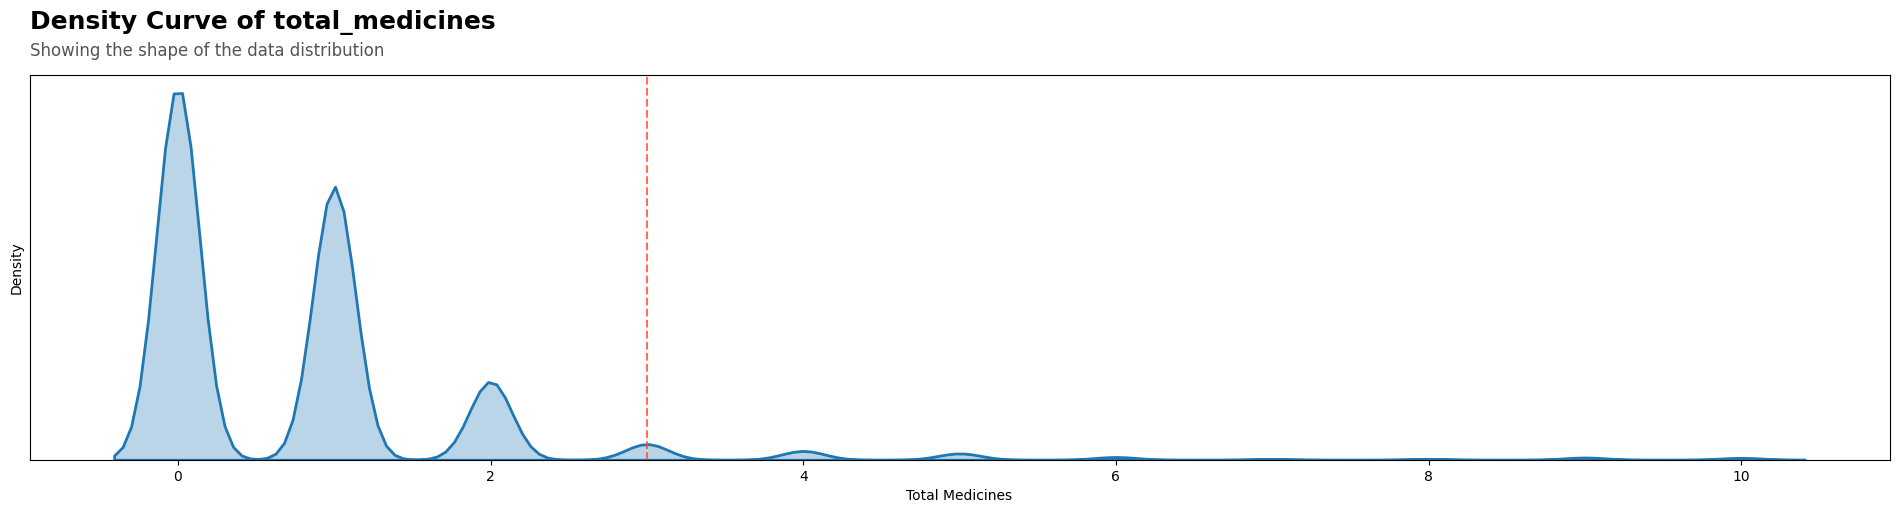

In [36]:
plt.figure(figsize=(24,5))
P.plot_kde('total_medicines',data)

In [37]:
data['total_medicines'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_medicines  percentage
0                 0       48.88
1                 1       35.73
2                 2       10.24
3                 3        2.05
4                 4        1.15
5                 5        0.83
6                 6        0.36
7                 9        0.29
8                10        0.25
9                 8        0.11
10                7        0.11

In [38]:
bins = [-1, 0, 1, 100]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_medicines'] = pd.cut(data['total_medicines'], bins=bins, labels=labels)

In [39]:
data['total_medicines'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_medicines  percentage
0            NONE       48.88
1          SINGLE       35.73
2        MULTIPLE       15.38

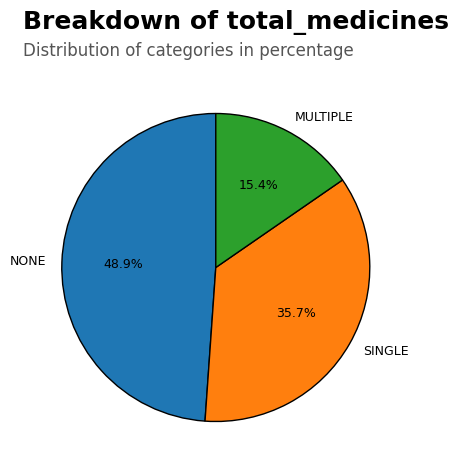

In [40]:
plt.figure(figsize=(24,5))
P.plot_pie('total_medicines',data)

- ***Changed the type of `total_medicines` - most of the observations have `none` medicines, `approx 49%`***

**avg_base_medicine_cost**

In [41]:
data['avg_base_medicine_cost'].describe().round(2).reset_index()

index  avg_base_medicine_cost
0  count                53346.00
1   mean                  162.61
2    std                  406.75
3    min                    0.00
4    25%                    0.00
5    50%                    6.80
6    75%                  263.49
7    max                 6901.17

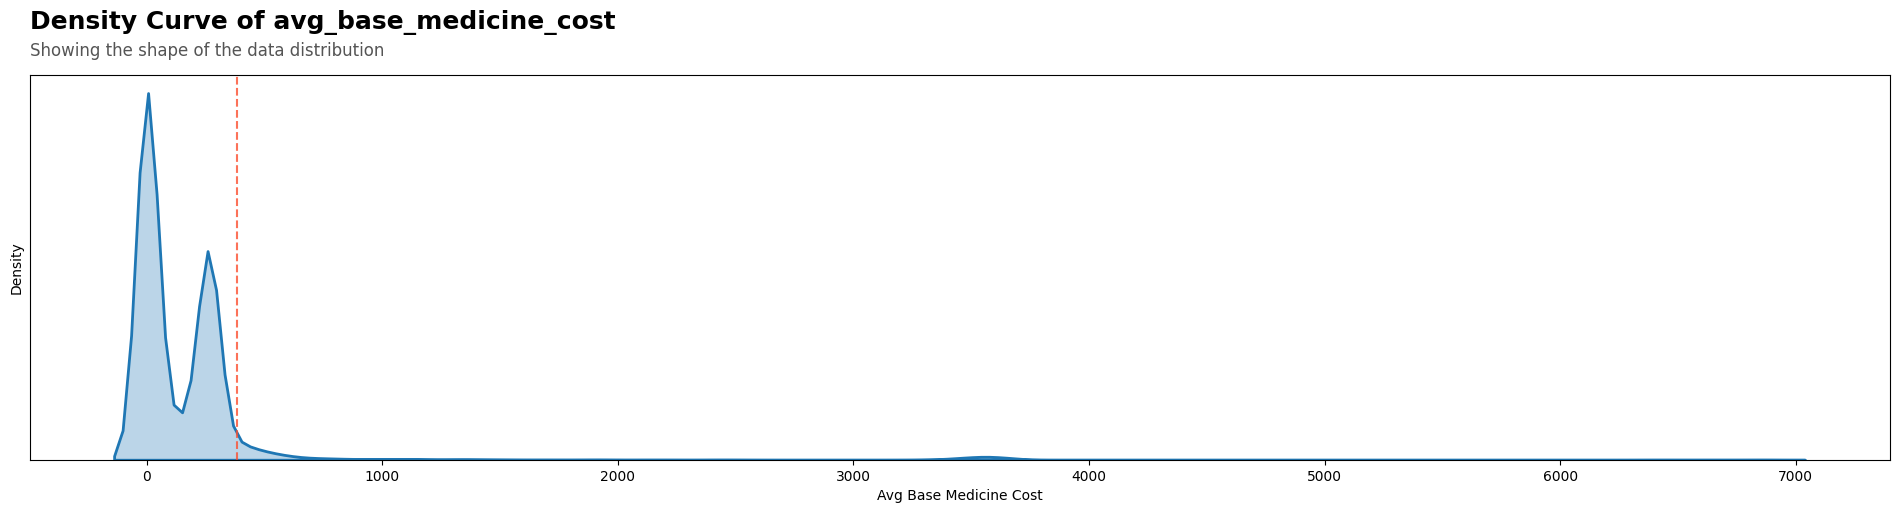

In [42]:
plt.figure(figsize=(24,5))
P.plot_kde('avg_base_medicine_cost',data)

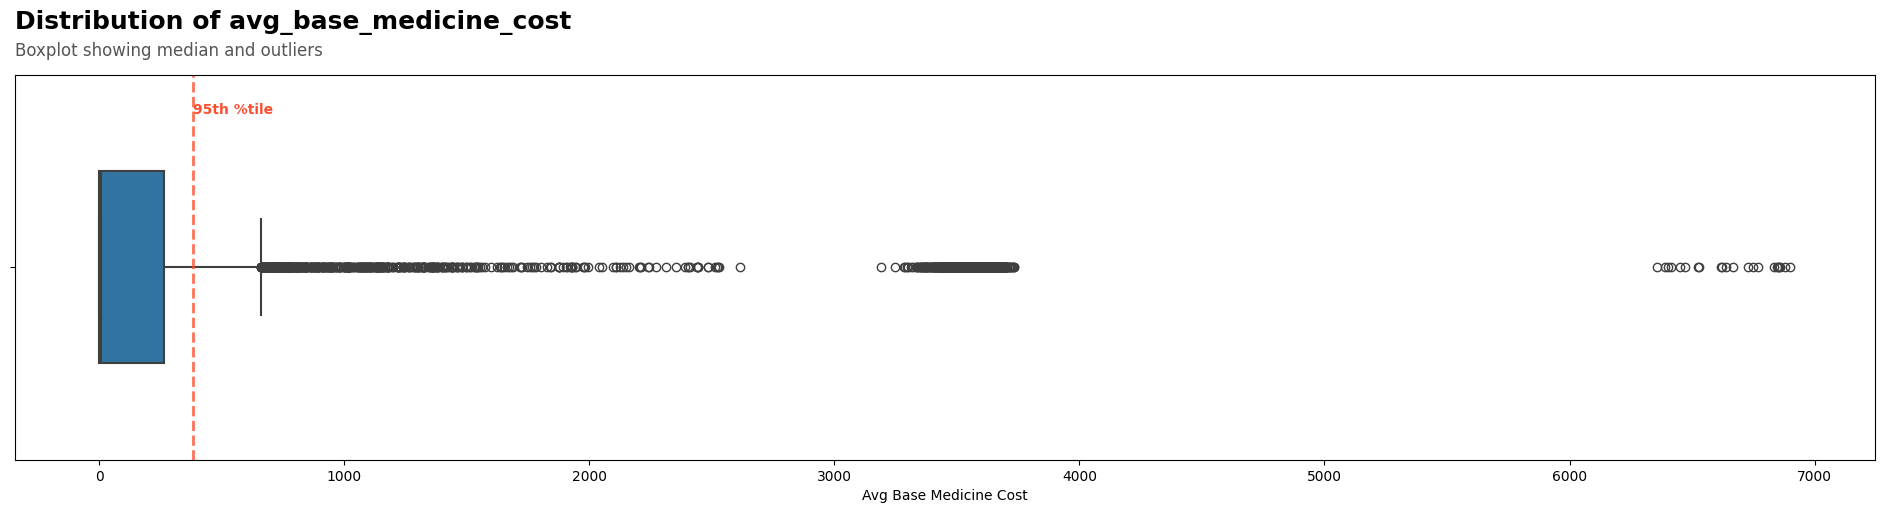

In [43]:
plt.figure(figsize=(24,5))
P.plot_box('avg_base_medicine_cost',data)

- ***As seen from the visual, `avg_base_medicine_cost` is `skewed` towards `right`...and prices are clustered in `3 major price ranges`***

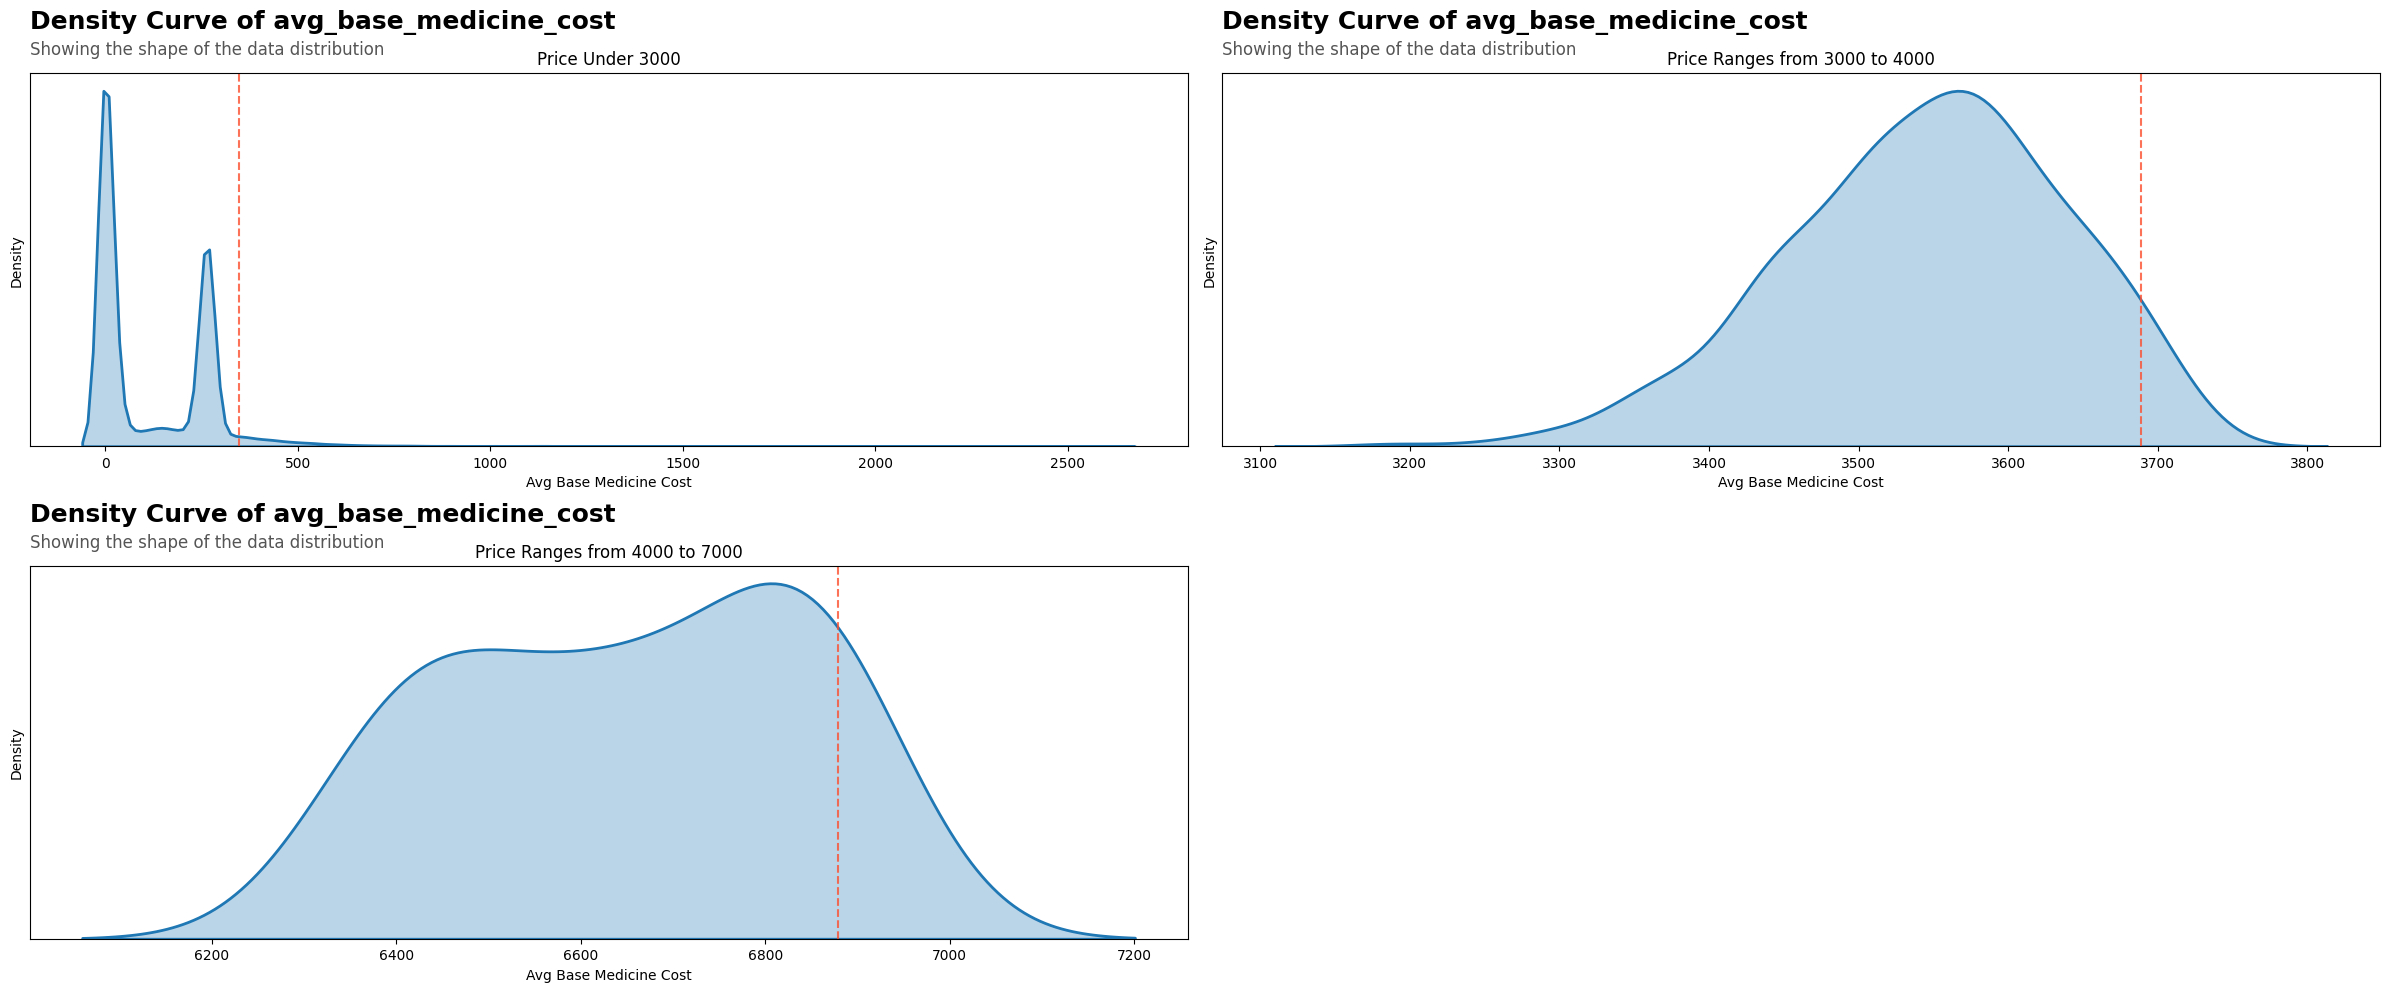

In [44]:
plt.figure(figsize=(24,10))
plt.subplot(2,2,1)
P.plot_kde('avg_base_medicine_cost',data[(data['avg_base_medicine_cost'] < 3000)])
plt.title('Price Under 3000')
plt.subplot(2,2,2)
P.plot_kde('avg_base_medicine_cost',data[(data['avg_base_medicine_cost'] > 3000) & (data['avg_base_medicine_cost'] < 4000)])
plt.title('Price Ranges from 3000 to 4000')
plt.subplot(2,2,3)
P.plot_kde('avg_base_medicine_cost',data[(data['avg_base_medicine_cost'] > 4000) & (data['avg_base_medicine_cost'] < 7000)])
plt.title('Price Ranges from 4000 to 7000')
plt.tight_layout()
plt.show()


In [45]:
data['avg_base_medicine_cost'].skew().round(2)

np.float64(7.72)

- ***As we can see, the `avg_base_medicine_cost` is `skewed` towards `right` and mainly `clusters around 3 different groups`***

**avg_total_medicine_cost**

In [46]:
data['avg_total_medicine_cost'].describe().round(2).reset_index()

index  avg_total_medicine_cost
0  count                 53346.00
1   mean                  1431.68
2    std                  9931.92
3    min                     0.00
4    25%                     0.00
5    50%                     7.22
6    75%                  1783.74
7    max               1296594.95

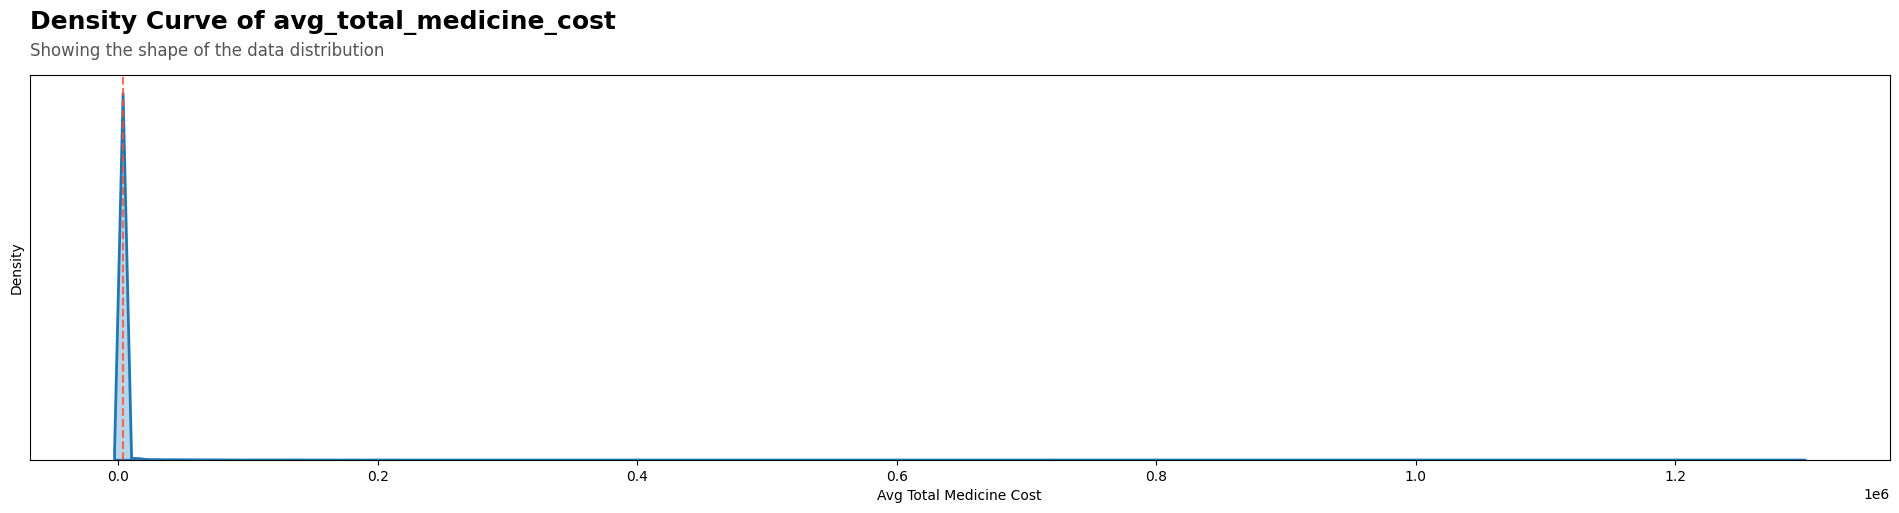

In [47]:
plt.figure(figsize=(24,5))
P.plot_kde('avg_total_medicine_cost',data)

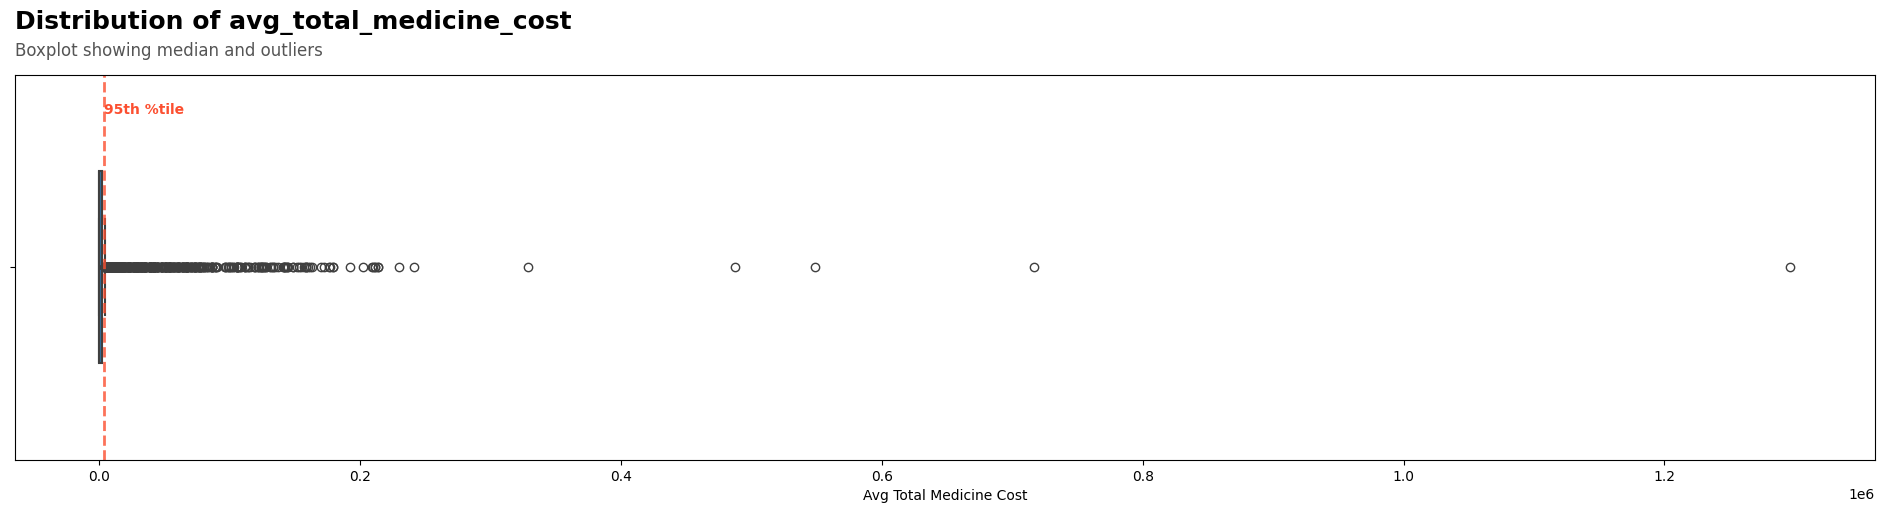

In [48]:
plt.figure(figsize=(24,5))
P.plot_box('avg_total_medicine_cost',data)

In [49]:
data[data['avg_total_medicine_cost']> 200000]

encounterclass  encounter_duration total_procedures  avg_procedure_cost  \
3248       INPATIENT              1620.0             NONE                 0.0   
4849      AMBULATORY                15.0             NONE                 0.0   
4853      AMBULATORY                15.0             NONE                 0.0   
13315       WELLNESS                15.0             NONE                 0.0   
15029     AMBULATORY                95.0             NONE                 0.0   
17076     AMBULATORY                91.0             NONE                 0.0   
23163     AMBULATORY                30.0             NONE                 0.0   
30452      EMERGENCY               132.0             NONE                 0.0   
33439      EMERGENCY               131.0             NONE                 0.0   
33731     AMBULATORY                15.0             NONE                 0.0   
34595     AMBULATORY                15.0             NONE                 0.0   
34741     AMBULATORY                30.0             NONE                 0.0   
41166     AMBULATORY                30.0             NONE                 0.0   
52259      EMERGENCY               110.0             NONE                 0.0   

      total_medicines  avg_base_medicine_cost  avg_total_medicine_cost  \
3248           SINGLE                 1376.11                549067.89   
4849           SINGLE                  263.49                211582.47   
4853           SINGLE                  263.49                210001.53   
13315          SINGLE                  263.49                229763.28   
15029          SINGLE                  263.49                213426.90   
17076          SINGLE                  263.49                213953.88   
23163        MULTIPLE                 1514.19                328578.14   
30452          SINGLE                  688.16                487217.28   
33439          SINGLE                 1843.07                716954.23   
33731          SINGLE                  263.49                211582.47   
34595          SINGLE                  263.49                201833.34   
34741        MULTIPLE                 1496.95                241008.95   
41166          SINGLE                  263.49                208684.08   
52259          SINGLE                 2208.85               1296594.95   

       reasons_for_medications is_ongoing_condition  total_conditions  \
3248                         0         NO CONDITION                 0   
4849                         1         NO CONDITION                 0   
4853                         1         NO CONDITION                 0   
13315                        0         NO CONDITION                 0   
15029                        0         NO CONDITION                 0   
17076                        0         NO CONDITION                 0   
23163                        1         NO CONDITION                 0   
30452                        0         NO CONDITION                 0   
33439                        0                  YES                 2   
33731                        1         NO CONDITION                 0   
34595                        1         NO CONDITION                 0   
34741                        1         NO CONDITION                 0   
41166                        1         NO CONDITION                 0   
52259                        0         NO CONDITION                 0   

      is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
3248          NO CAREPLAN                0           63  MARRIED  WHITE   
4849          NO CAREPLAN                0           91  MARRIED  WHITE   
4853          NO CAREPLAN                0           91  MARRIED  WHITE   
13315                 YES                1           98   SINGLE  WHITE   
15029         NO CAREPLAN                0           78  MARRIED  BLACK   
17076         NO CAREPLAN                0           84  MARRIED  WHITE   
23163         NO CAREPLAN                0           75  M

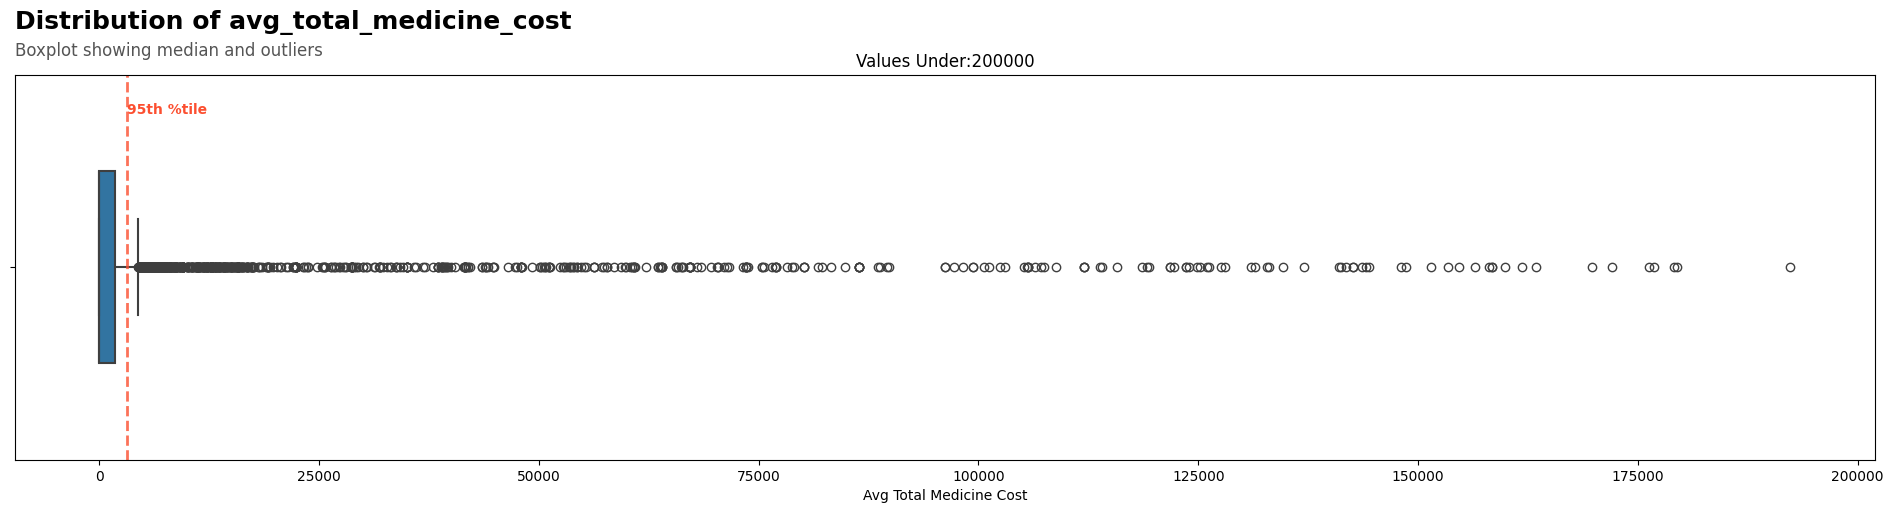

In [50]:
plt.figure(figsize=(24,5))
P.plot_box('avg_total_medicine_cost',data[data['avg_total_medicine_cost']< 200000])
plt.title('Values Under:200000')
plt.show()

In [51]:
data['avg_total_medicine_cost'].skew().round(2)

np.float64(60.36)

- ***As seen, there are `14 max outliers`,and `total_base_medicine_cost` is highly `skewed` towards `right`***

**reasons_for_medications**

In [52]:
data['reasons_for_medications'].describe().round(2).reset_index()

index  reasons_for_medications
0  count                 53346.00
1   mean                     0.50
2    std                     0.61
3    min                     0.00
4    25%                     0.00
5    50%                     0.00
6    75%                     1.00
7    max                     4.00

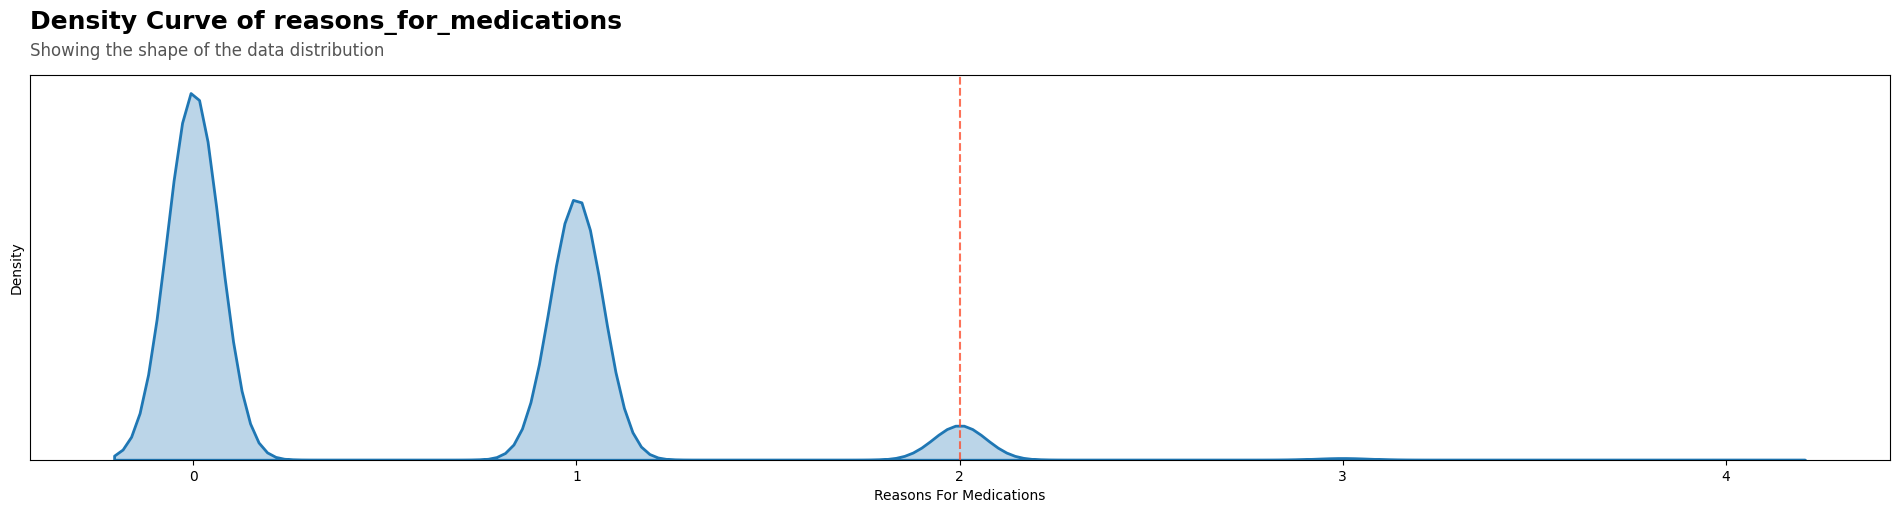

In [53]:
plt.figure(figsize=(24,5))
P.plot_kde('reasons_for_medications',data)

In [54]:
data['reasons_for_medications'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

reasons_for_medications  percentage
0                        0       55.27
1                        1       39.30
2                        2        5.17
3                        3        0.25
4                        4        0.00

In [55]:
bins = [-1, 0, 1, 10]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['reasons_for_medications'] = pd.cut(data['reasons_for_medications'], bins=bins, labels=labels)

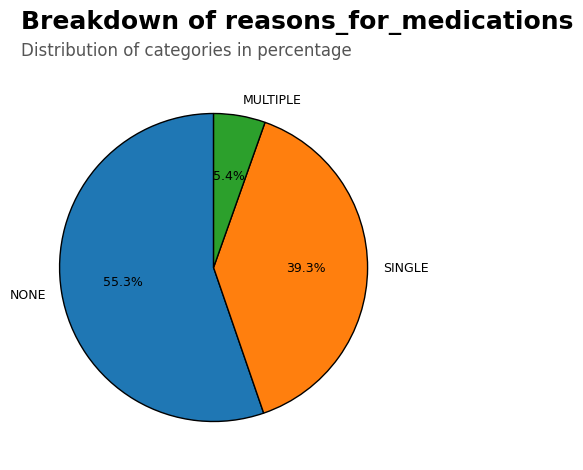

In [56]:
plt.figure(figsize=(24,5))
P.plot_pie('reasons_for_medications',data)

- ***Changed the type of `reason_for_medication` - most of the observations are from `None` class, `~55%`***

**is_ongoing_condition**

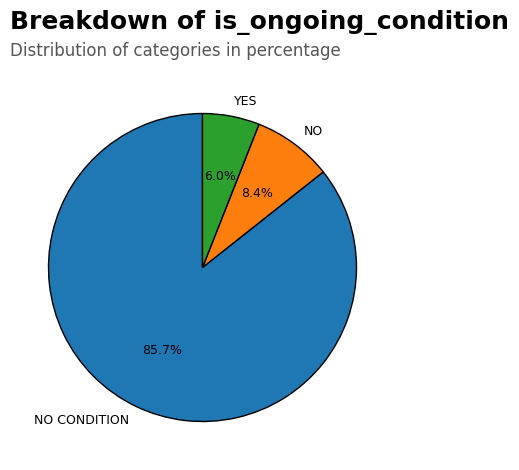

In [57]:
plt.figure(figsize=(24,5))
P.plot_pie('is_ongoing_condition',data)

- ***Most of the observations of `is_ongoing_condition` column is `NO CONDITION`, `~85%`of overall values***

**total_conditions**

In [58]:
data['total_conditions'].describe().round(2).reset_index()

index  total_conditions
0  count          53346.00
1   mean              0.16
2    std              0.41
3    min              0.00
4    25%              0.00
5    50%              0.00
6    75%              0.00
7    max              7.00

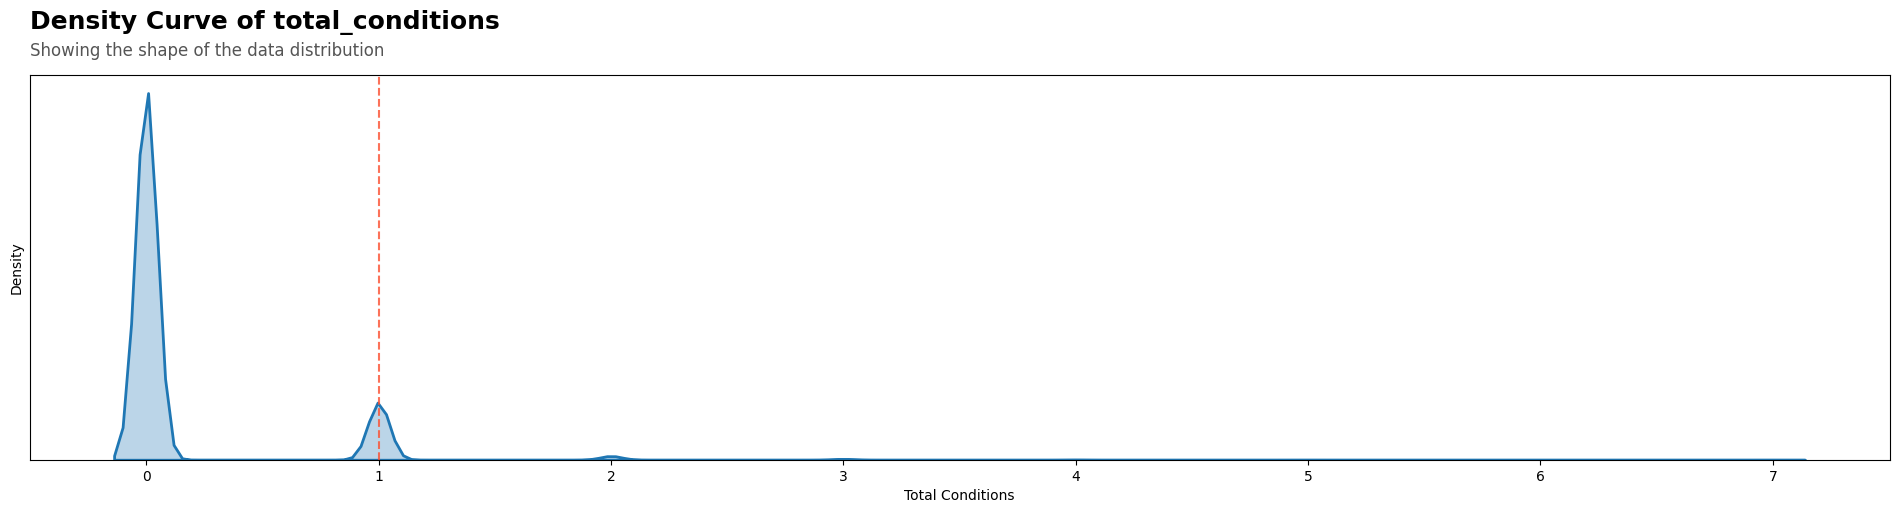

In [59]:
plt.figure(figsize=(24,5))
P.plot_kde('total_conditions',data)

In [60]:
data['total_conditions'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_conditions  percentage
0                 0       85.66
1                 1       13.25
2                 2        0.88
3                 3        0.18
4                 4        0.03
5                 5        0.01
6                 7        0.00

In [61]:
bins = [-1, 0, 1, 10]
labels = ['NONE', 'SINGLE', 'MULTIPLE']
data['total_conditions'] = pd.cut(data['total_conditions'], bins=bins, labels=labels)

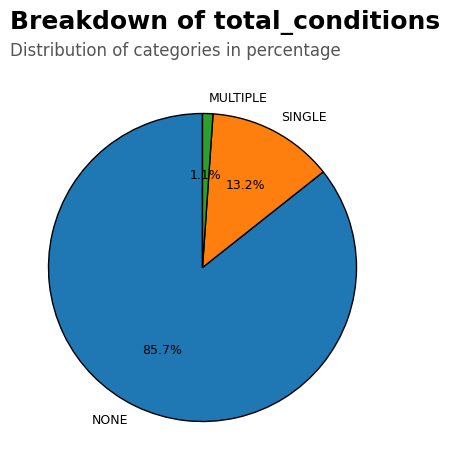

In [62]:
plt.figure(figsize=(24,5))
P.plot_pie('total_conditions',data)

- ***Changed the type of `total_conditions` - most of the observations are from `None` class, `~85%`***

**is_ongoing_careplan**

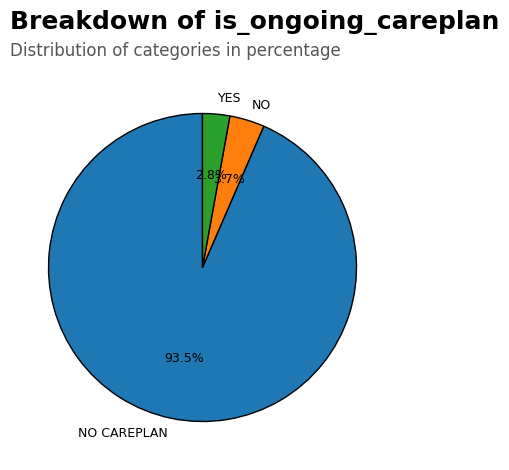

In [63]:
plt.figure(figsize=(24,5))
P.plot_pie('is_ongoing_careplan',data)

- ***Most of the observations of `is_ongoin_careplan` is from `NO CAREPLAN `class, `approx 94%`***

**total_careplans**

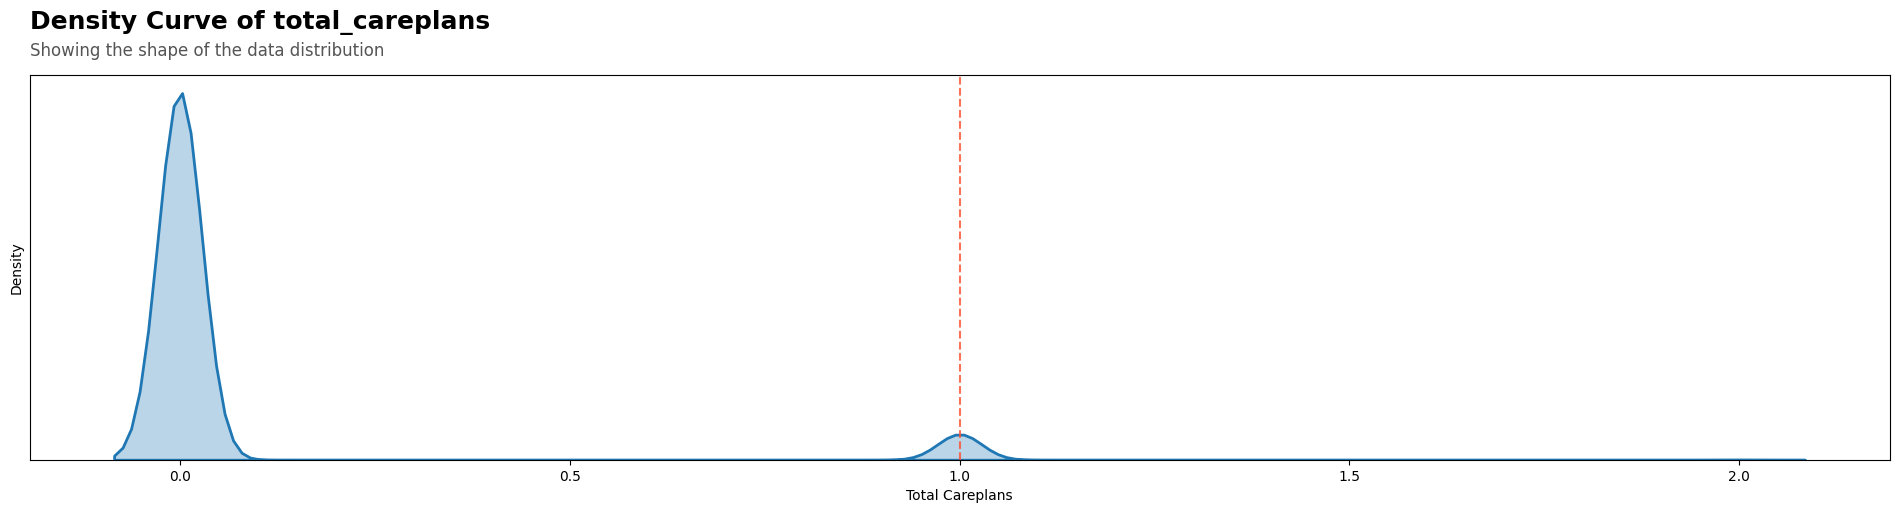

In [64]:
plt.figure(figsize=(24,5))
P.plot_kde('total_careplans',data)

In [65]:
data['total_careplans'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

total_careplans  percentage
0                0       93.49
1                1        6.49
2                2        0.02

In [66]:
data['total_careplans']=np.where(data['total_careplans'] == 0,'NO','YES')

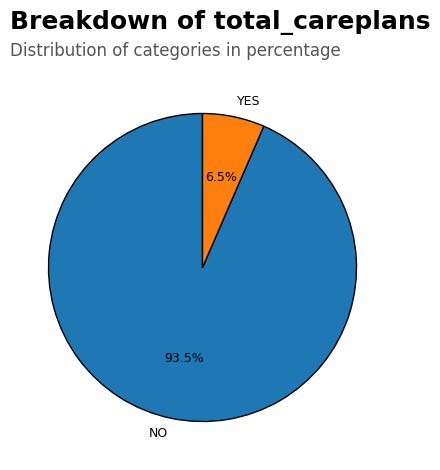

In [67]:
plt.figure(figsize=(24,5))
P.plot_pie('total_careplans',data)

- ***Changed the type of `total_careplans` column - most of the observations are from `NO` category, `~94%`***

**age_as_2022**

In [68]:
data['age_as_2022'].describe().round(2).reset_index()

index  age_as_2022
0  count     53346.00
1   mean        55.66
2    std        25.87
3    min         1.00
4    25%        35.00
5    50%        58.00
6    75%        73.00
7    max       112.00

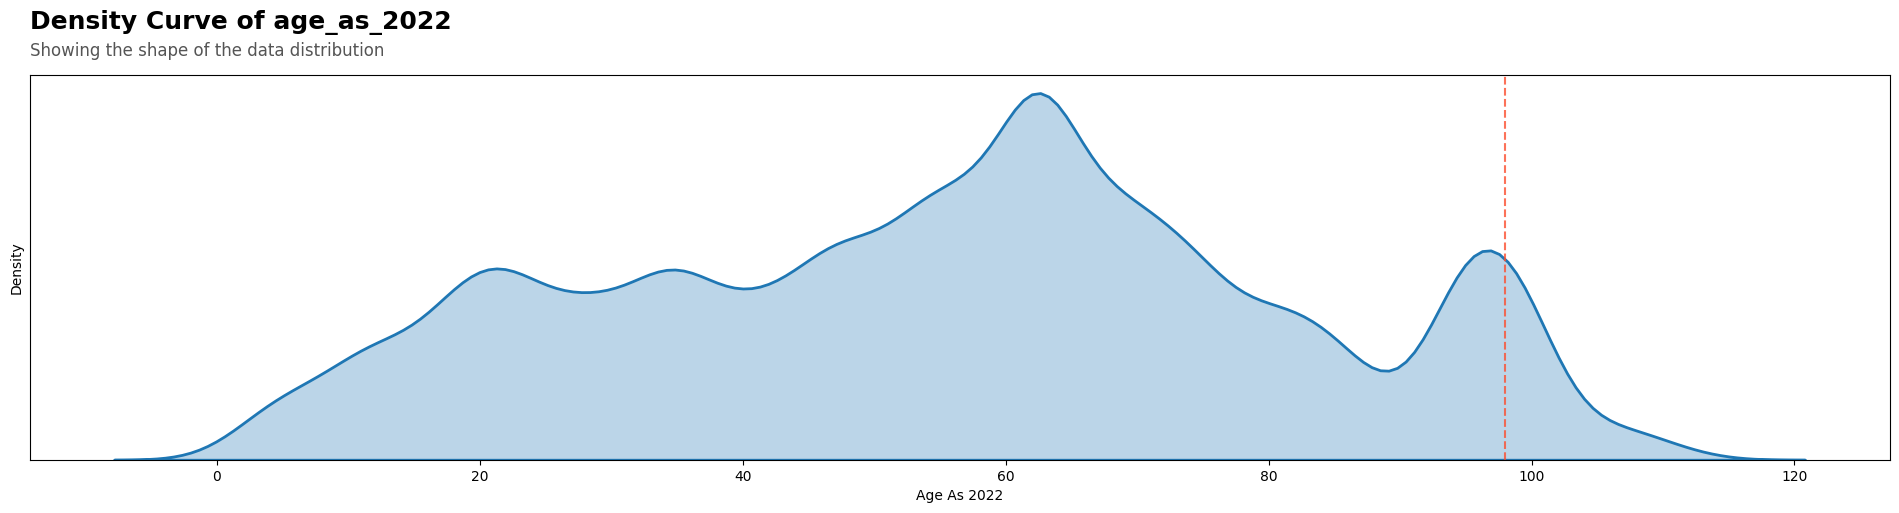

In [69]:
plt.figure(figsize=(24,5))
P.plot_kde('age_as_2022',data)

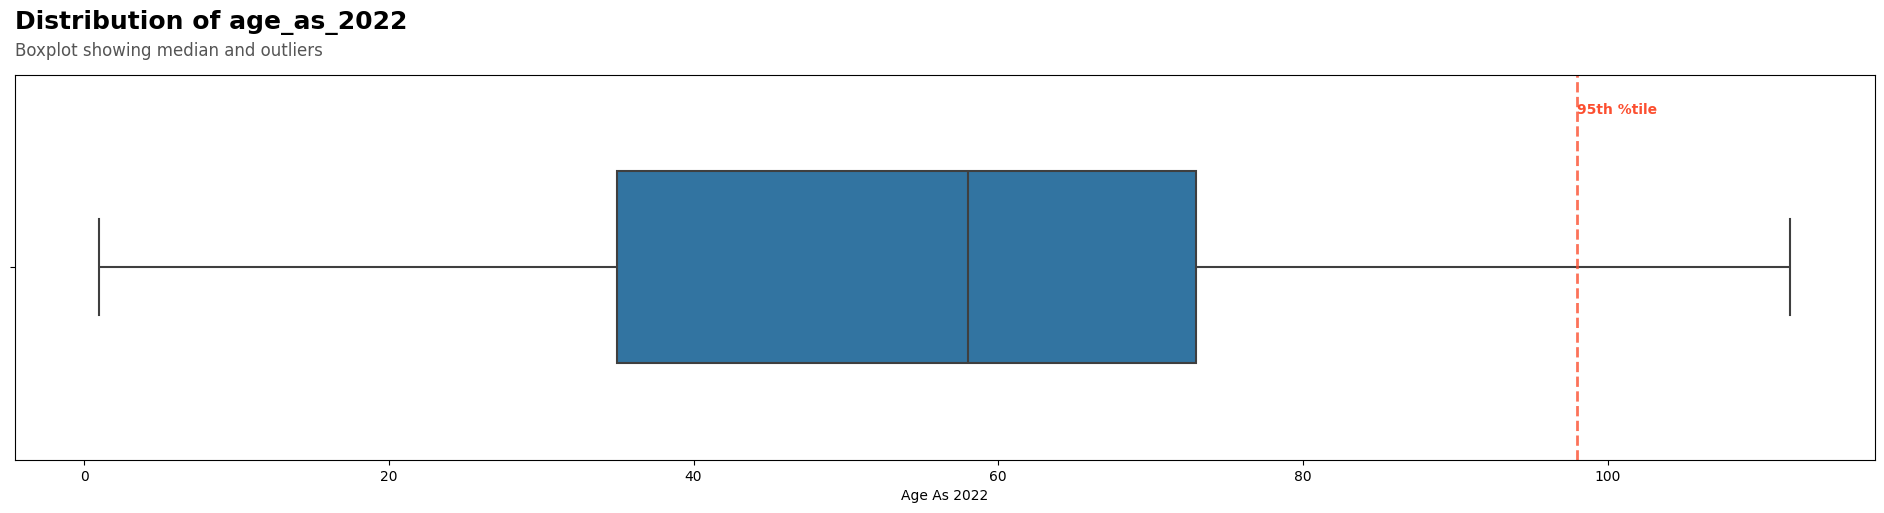

In [70]:
plt.figure(figsize=(24,5))
P.plot_box('age_as_2022',data)

In [71]:
data['age_as_2022'].skew().round(2)

np.float64(-0.04)

In [72]:
rows, columns = data[data['age_as_2022']>89].shape

print(f"Percentage of people aged above 100: {round((rows/len(data)*100),2)}%")

Percentage of people aged above 100: 12.69%


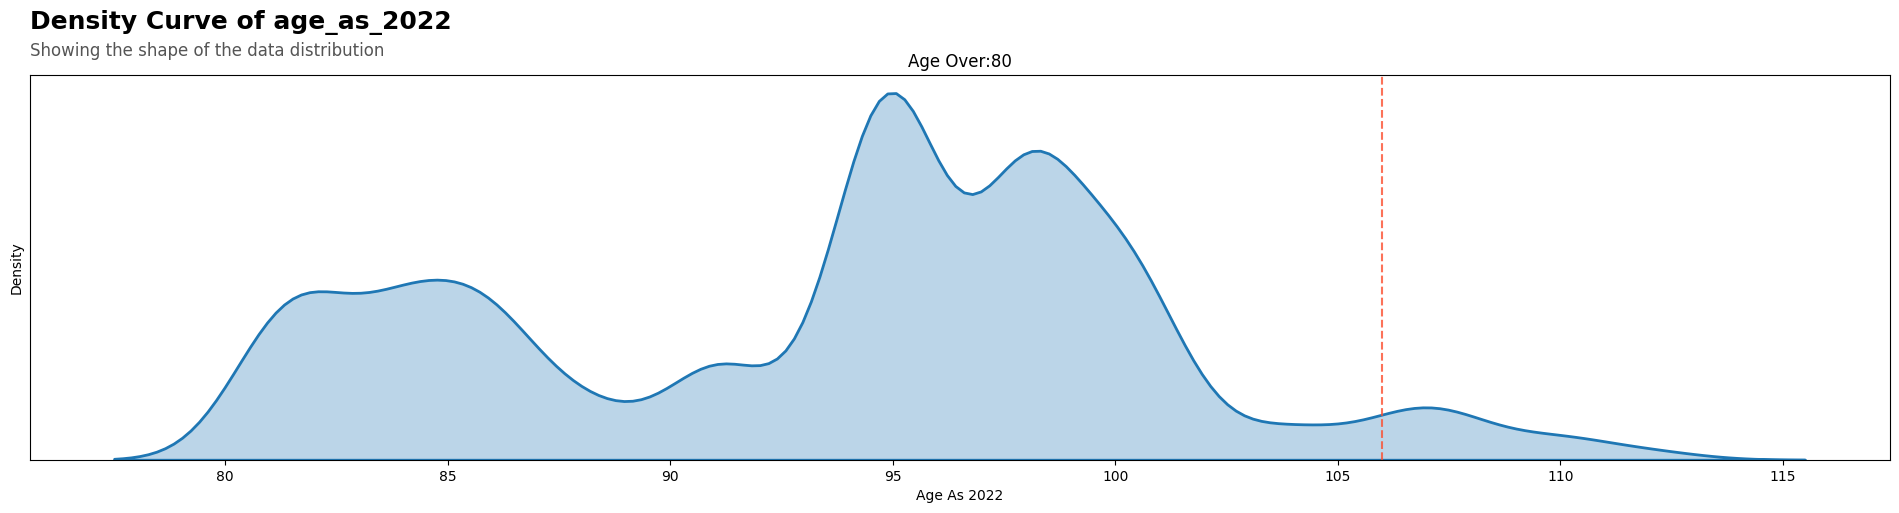

In [73]:
elders = data[data['age_as_2022']>80]
plt.figure(figsize=(24,5))
P.plot_kde('age_as_2022',elders)
plt.title('Age Over:80')
plt.show()

- ***Age column have `2 peaks`, one is around `60` and other one is around `100`, data is `slightly skewed towards left` - meaning a `relatively high` percentage of patients from `lower age group`*** 

**marital**

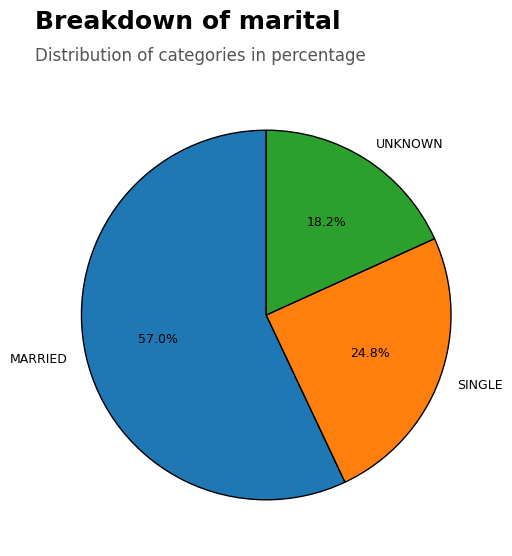

In [74]:
plt.figure(figsize=(6,6))
P.plot_pie('marital',data)

- ***Most of the values in marital column is `MARRIED`, `~57%`***

**race**

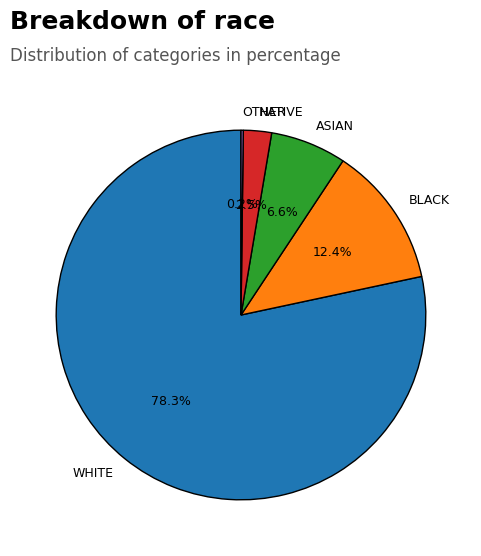

In [75]:
plt.figure(figsize=(6,6))
P.plot_pie('race',data)

- ***Most of the values in `race` is `WHITE`, `approx 79%`***

**ethnicity**

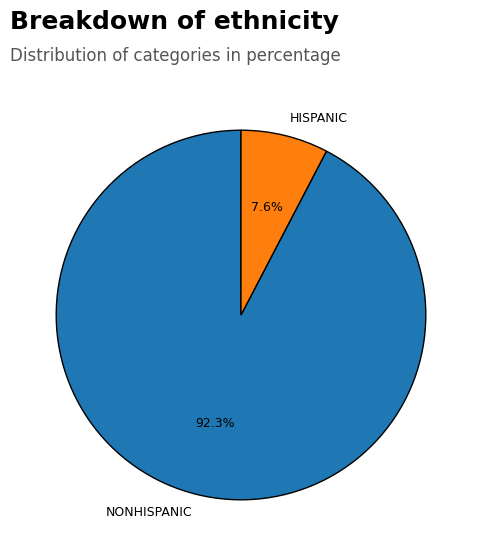

In [76]:
plt.figure(figsize=(6,6))
P.plot_pie('ethnicity',data)

- ***Most of the values in `ethnicity` column is `NONHISPANIC`, `~93%`***

**patient_gender**

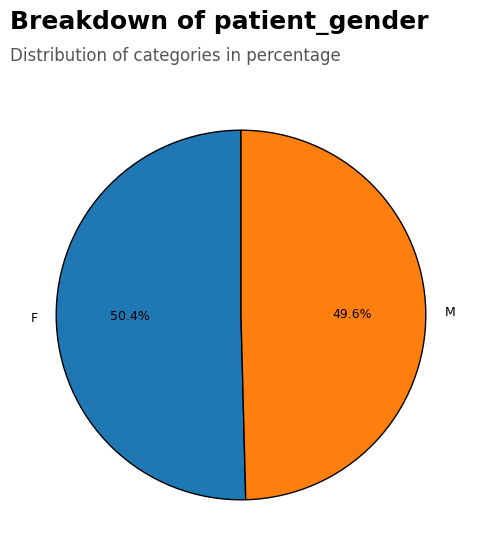

In [77]:
plt.figure(figsize=(6,6))
P.plot_pie('patient_gender',data)

- ***Patient gender is `almost equally distributed` into `M` and `F` class***

**provider_gender**

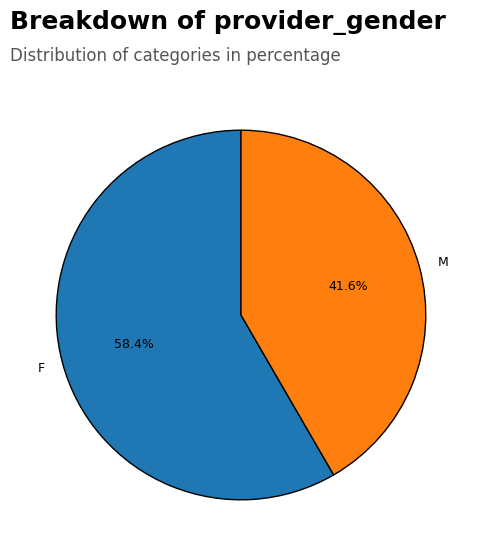

In [78]:
plt.figure(figsize=(6,6))
P.plot_pie('provider_gender',data)

- ***There are slighly more value of `F` class in `provider_gender` column, ap`prox 59%`***

**utilization**

In [79]:
data['utilization'].describe().round(2).reset_index()

index  utilization
0  count     53346.00
1   mean      1329.70
2    std      1427.73
3    min         1.00
4    25%        86.00
5    50%       821.00
6    75%      2159.00
7    max      4828.00

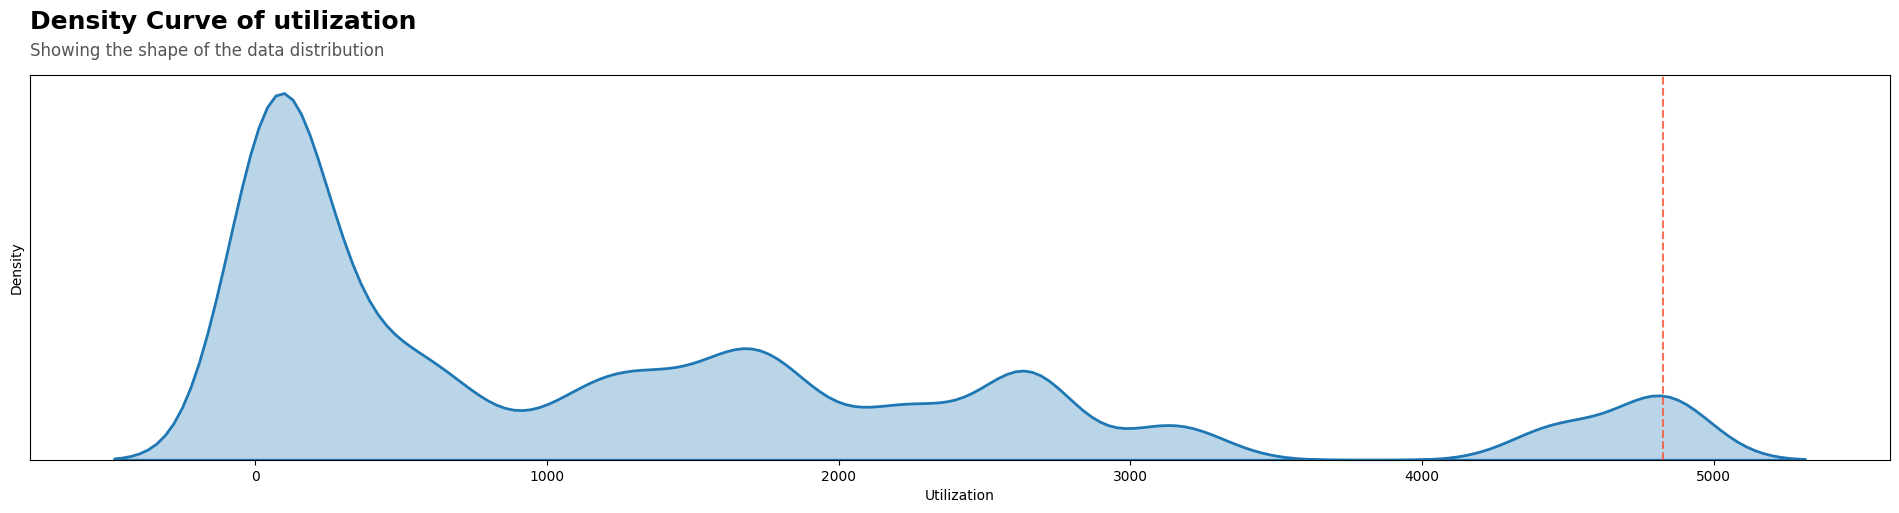

In [80]:
plt.figure(figsize=(24,5))
P.plot_kde('utilization',data)

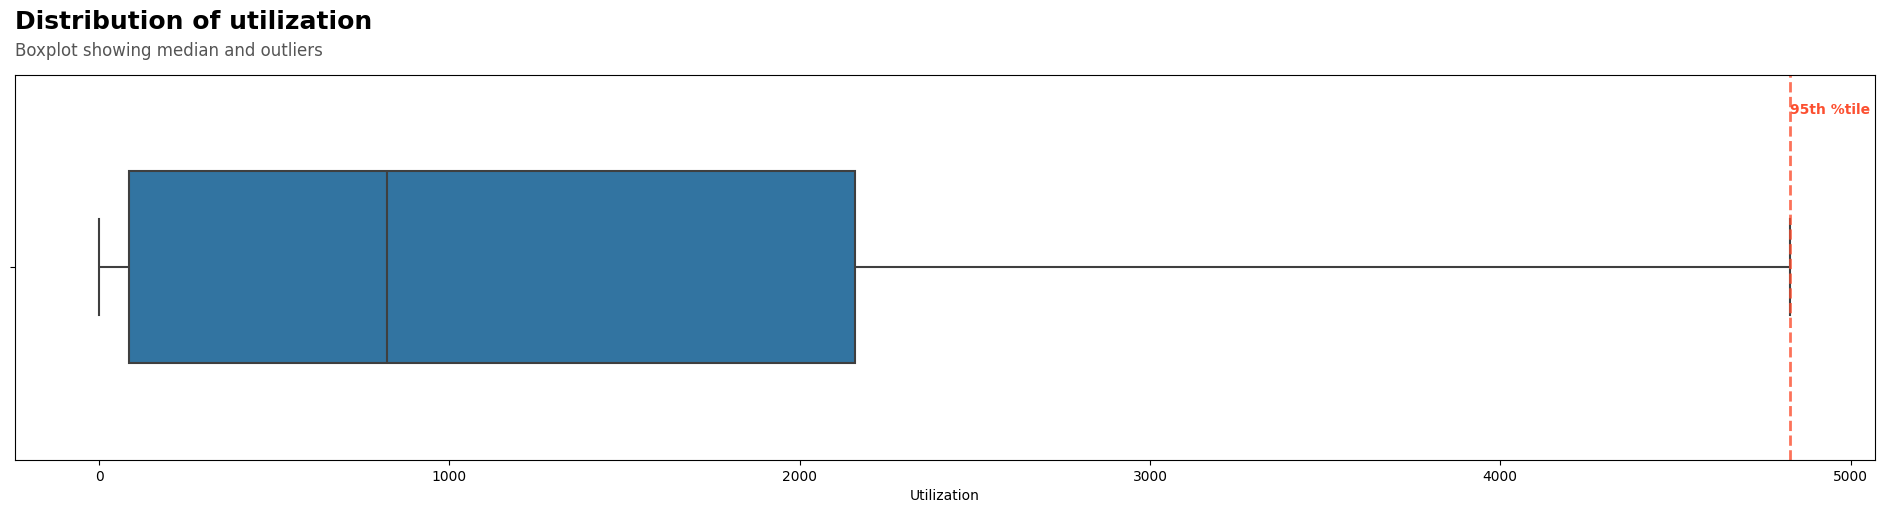

In [81]:
plt.figure(figsize=(24,5))
P.plot_box('utilization',data)

In [82]:
data['utilization'].skew().round(2)

np.float64(1.1)

- ***`utilization` have no outlies - data is slighly `skewed` towards `right`, and `there is a rise after a sudden drop at 4000`***

**condition_duration**

In [83]:
data['condition_duration'].describe().round(2).reset_index()

index  condition_duration
0  count            53346.00
1   mean                7.54
2    std              156.39
3    min                0.00
4    25%                0.00
5    50%                0.00
6    75%                0.00
7    max            17947.00

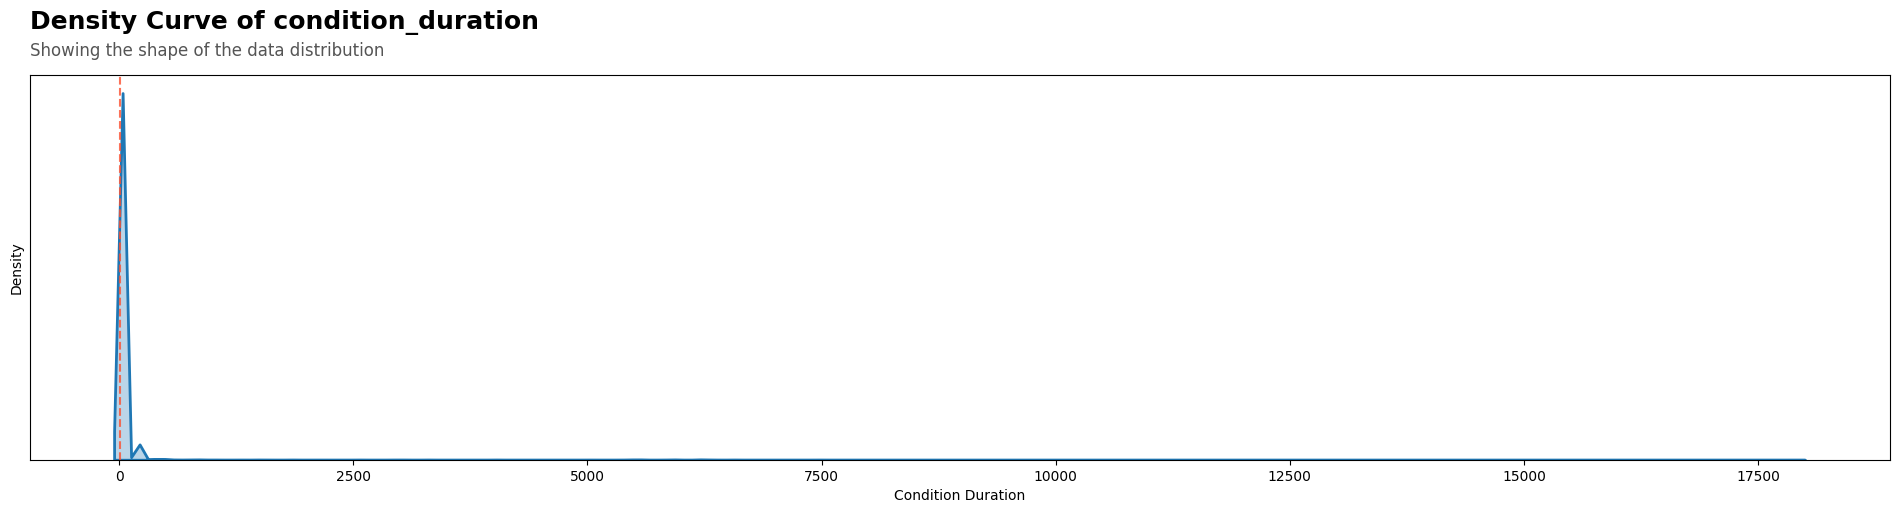

In [84]:
plt.figure(figsize=(24,5))
P.plot_kde('condition_duration',data)

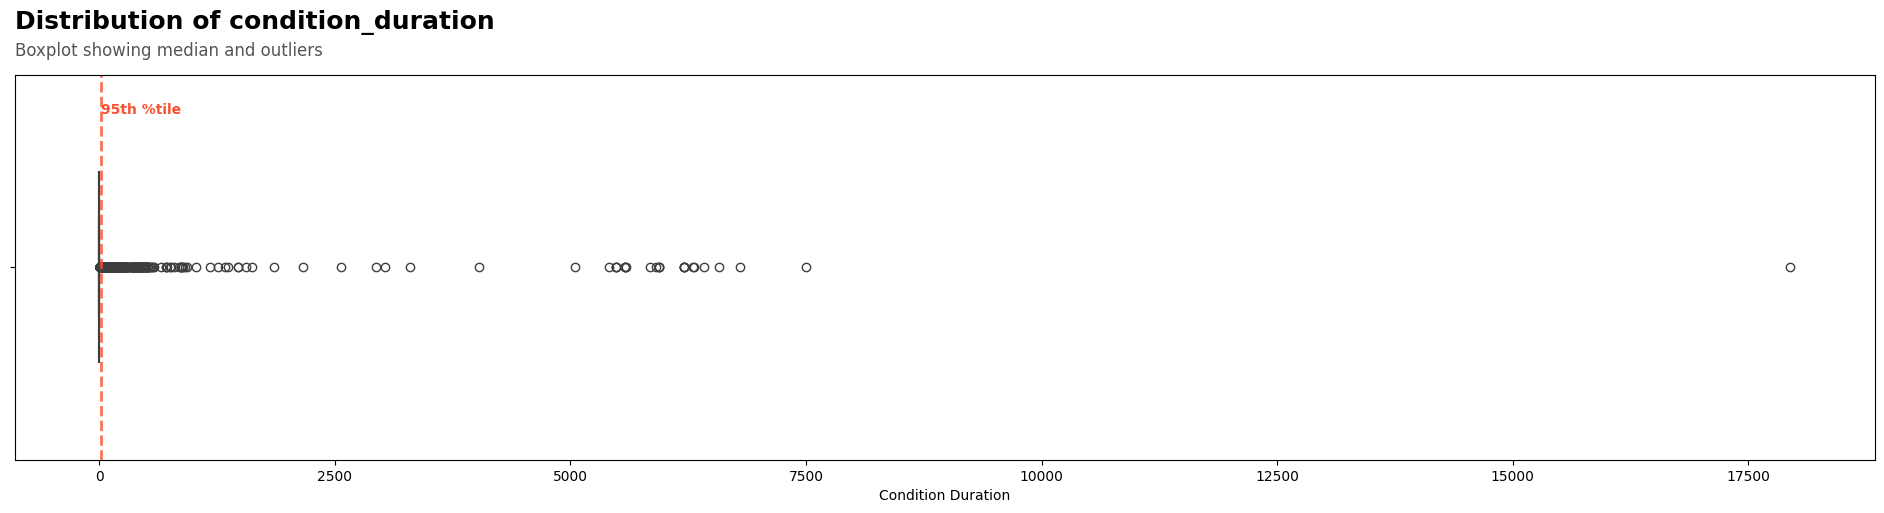

In [85]:
plt.figure(figsize=(24,5))
P.plot_box('condition_duration',data)

In [86]:
data['condition_duration'].skew().round(2)

np.float64(55.06)

- ***`condition_duration` column is `skewed` towards `right` having `max` condition for `almost 19 years`***

**careplan_duration**

In [87]:
data['careplan_duration'].describe().round(2).reset_index()

index  careplan_duration
0  count           53346.00
1   mean               7.11
2    std             117.53
3    min               0.00
4    25%               0.00
5    50%               0.00
6    75%               0.00
7    max           10204.00

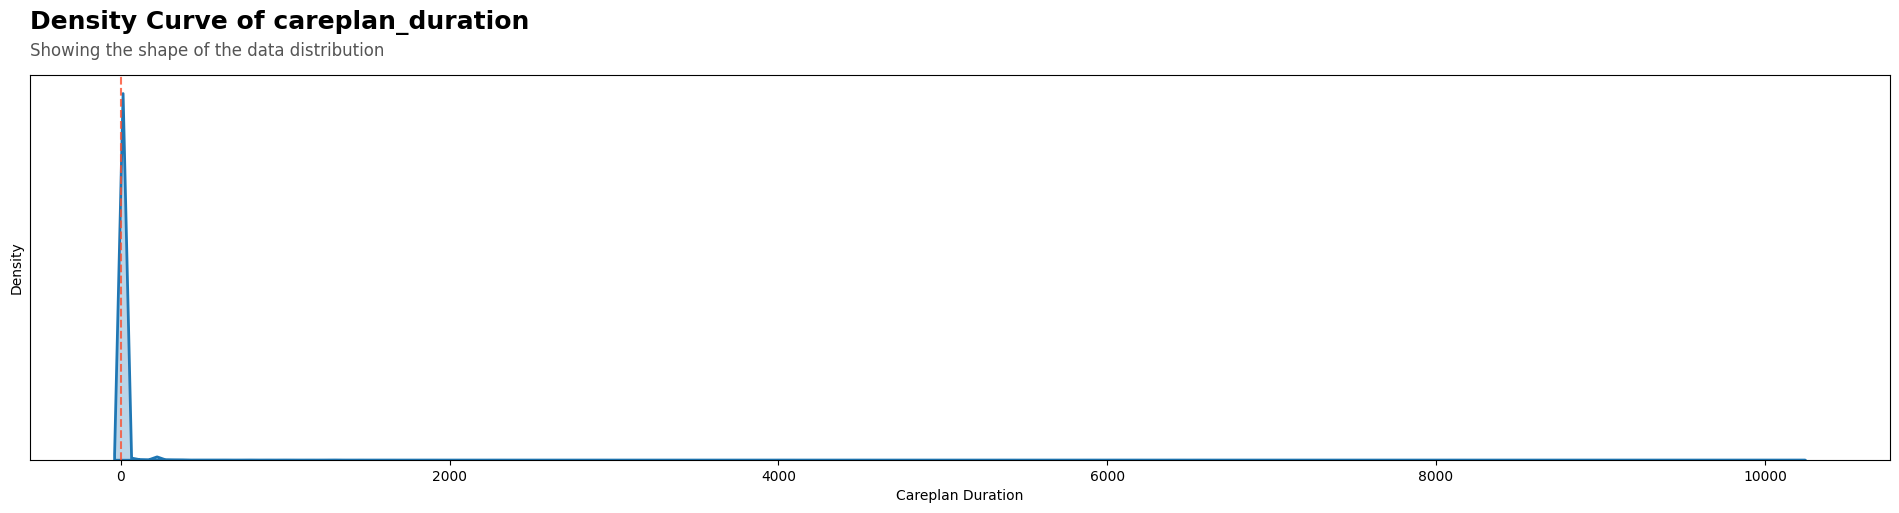

In [88]:
plt.figure(figsize=(24,5))
P.plot_kde('careplan_duration',data)

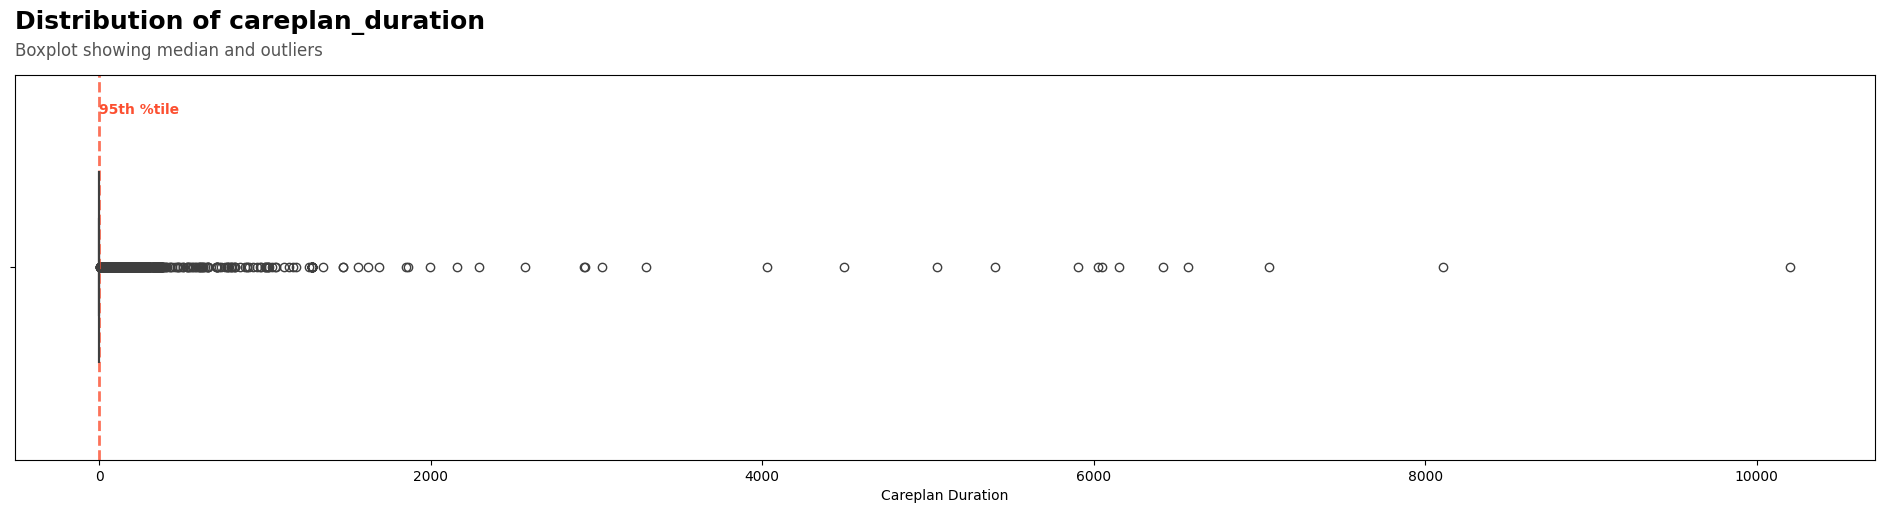

In [89]:
plt.figure(figsize=(24,5))
P.plot_box('careplan_duration',data)

In [90]:
data['careplan_duration'].skew().round(2)

np.float64(47.3)

- ***`careplan_duration` column is `skewed` towards `right` having `max` careplan for `almost 27 years`***

**visit_number**

In [91]:
data['visit_number'].describe().round(2).reset_index()

index  visit_number
0  count      53346.00
1   mean        127.88
2    std        300.86
3    min          1.00
4    25%         12.00
5    50%         30.00
6    75%         69.00
7    max       2006.00

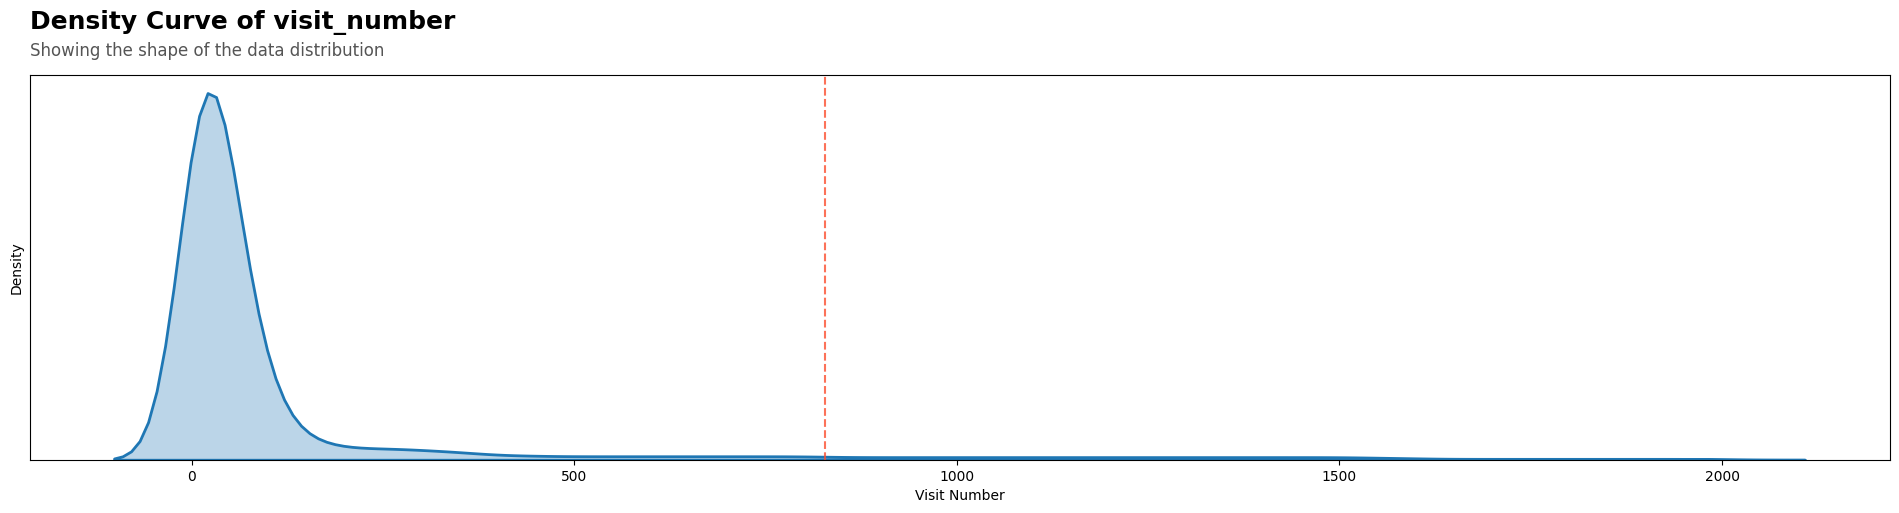

In [92]:
plt.figure(figsize=(24,5))
P.plot_kde('visit_number',data)

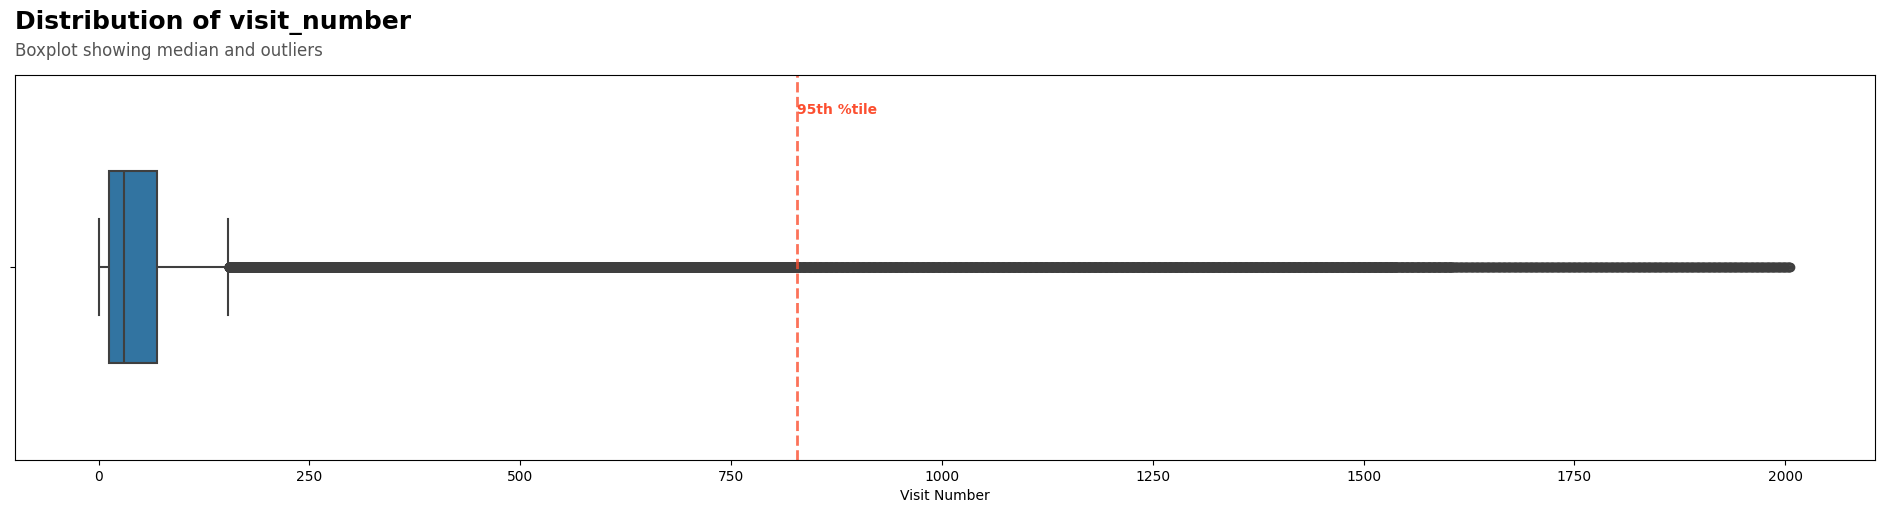

In [93]:
plt.figure(figsize=(24,5))
P.plot_box('visit_number',data)

In [94]:
bins = [0, 1, 10, 10000]
labels = ['NEW', 'RETURNING', 'FREQUENT']
    
data['visit_frequency'] = pd.cut(data['visit_number'], bins=bins, labels=labels)
data.drop(columns=['visit_number'],inplace=True)

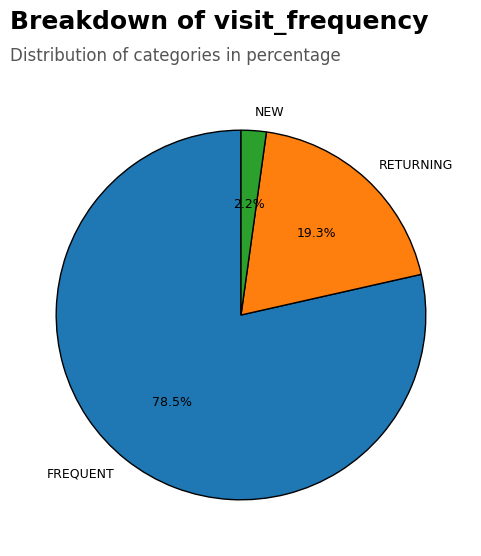

In [95]:
plt.figure(figsize=(6,6))
P.plot_pie('visit_frequency',data)

- ***Changed the column `visit_number` to `visit_frequency`, most of the values in this column are `FREQUENT` - `~79%`***

**coverage_ratio**

In [96]:
data['coverage_ratio'].describe().round(2).reset_index()

index  coverage_ratio
0  count        53346.00
1   mean            0.48
2    std            0.34
3    min            0.00
4    25%            0.23
5    50%            0.54
6    75%            0.69
7    max            1.00

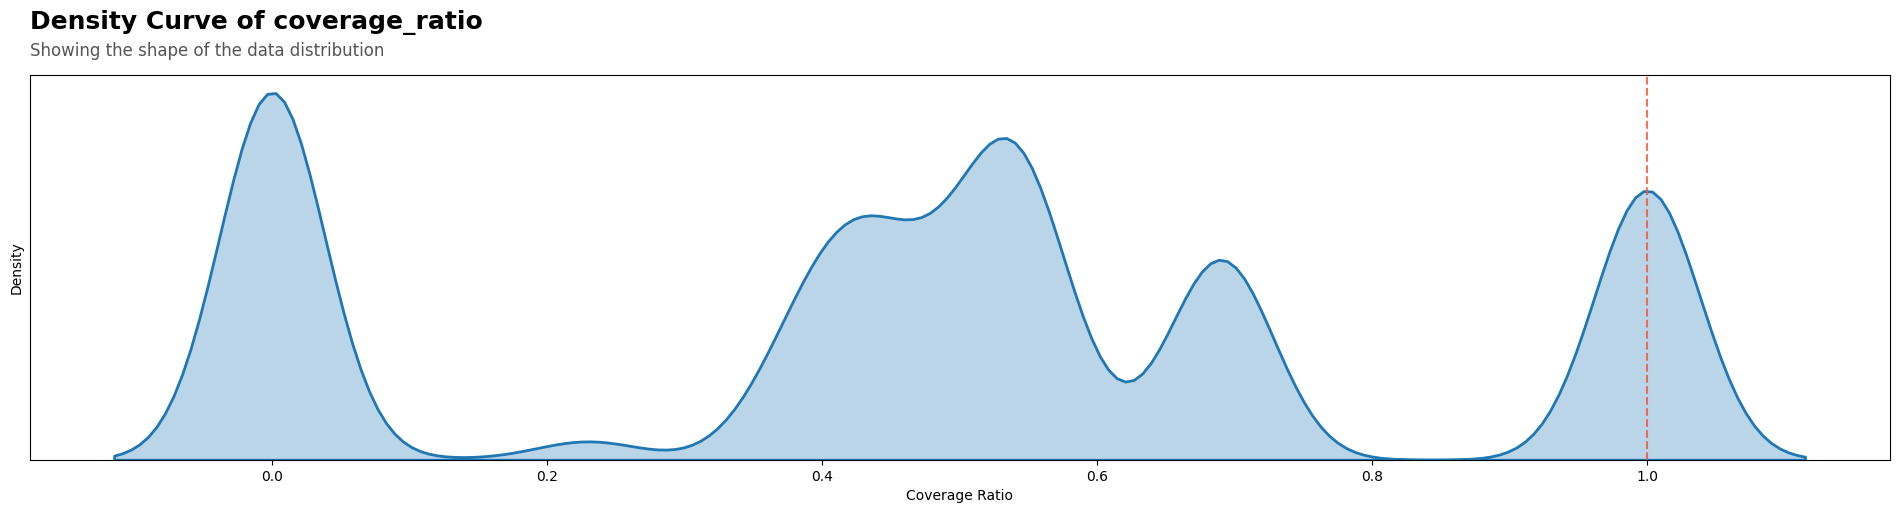

In [97]:
plt.figure(figsize=(24,5))
P.plot_kde('coverage_ratio',data)

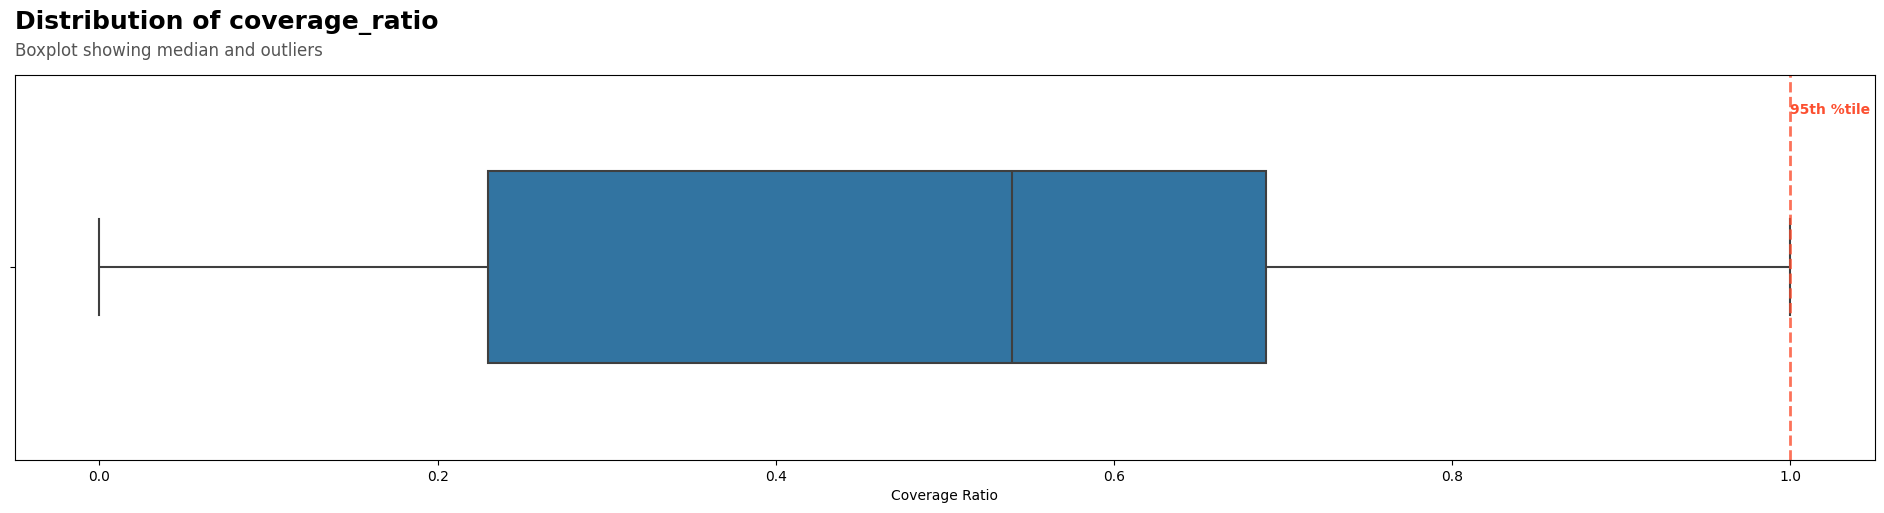

In [98]:
plt.figure(figsize=(24,5))
P.plot_box('coverage_ratio',data)

- ***`coverage_ratio` have `3 peaks` - one is around `0`, one is around `1` and the other is `at the middle`***

**medication_duration**

In [99]:
data['medication_duration'].describe().round(2).reset_index()

index  medication_duration
0  count             53346.00
1   mean               122.99
2    std               443.13
3    min                 0.00
4    25%                 0.00
5    50%                 0.00
6    75%               361.00
7    max             24091.00

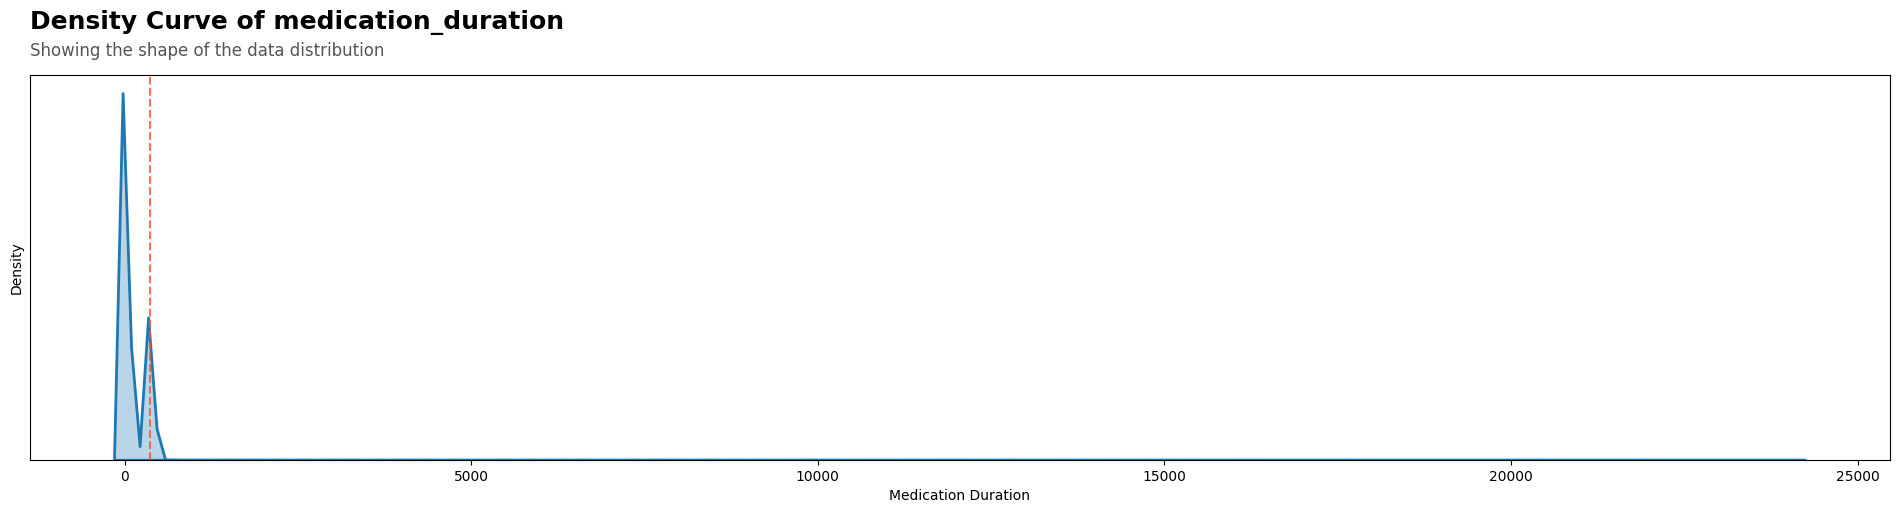

In [100]:
plt.figure(figsize=(24,5))
P.plot_kde('medication_duration',data)

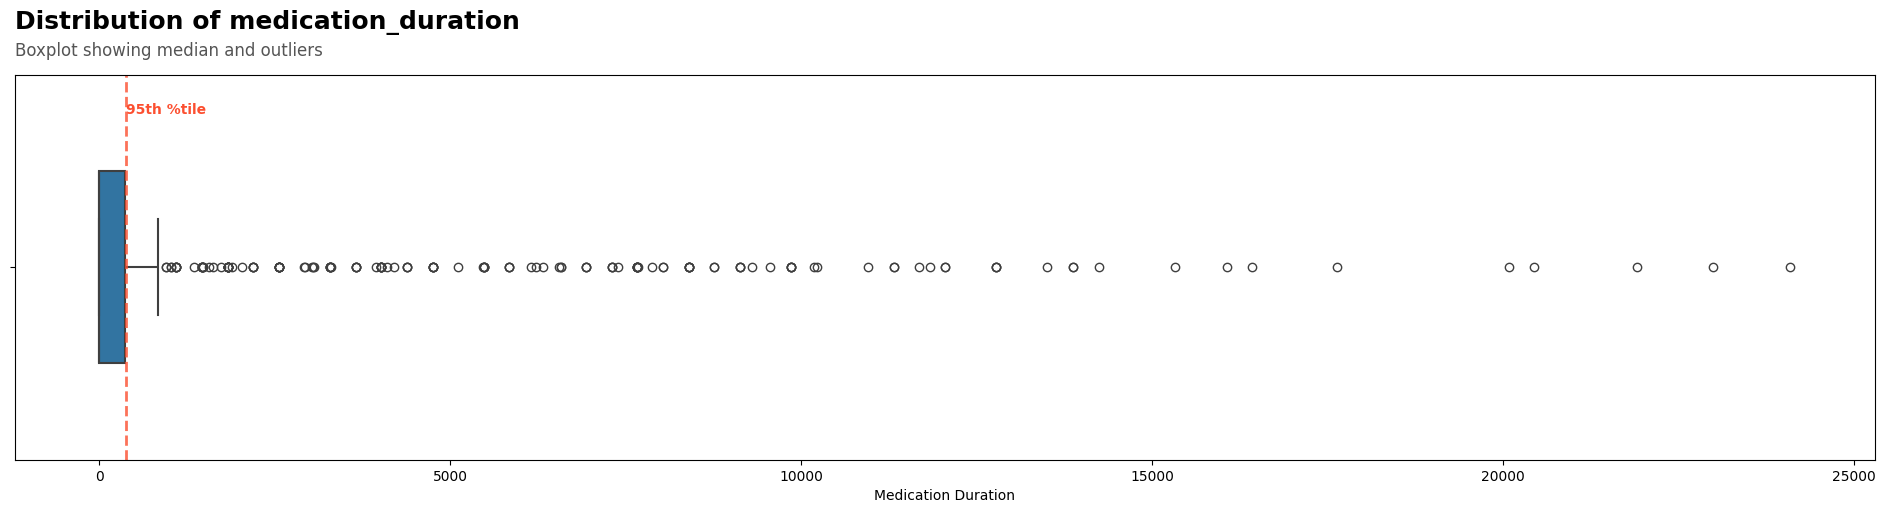

In [101]:
plt.figure(figsize=(24,5))
P.plot_box('medication_duration',data)

In [102]:
data['medication_duration'].skew().round(2)

np.float64(26.37)

- ***`medication_duration` have `skewness` towards `right`***

**procedures_per_hour**

In [103]:
data['procedures_per_hour'].describe().round(2).reset_index()

index  procedures_per_hour
0  count             53346.00
1   mean                 0.45
2    std                 0.75
3    min                 0.00
4    25%                 0.00
5    50%                 0.00
6    75%                 1.00
7    max                 4.00

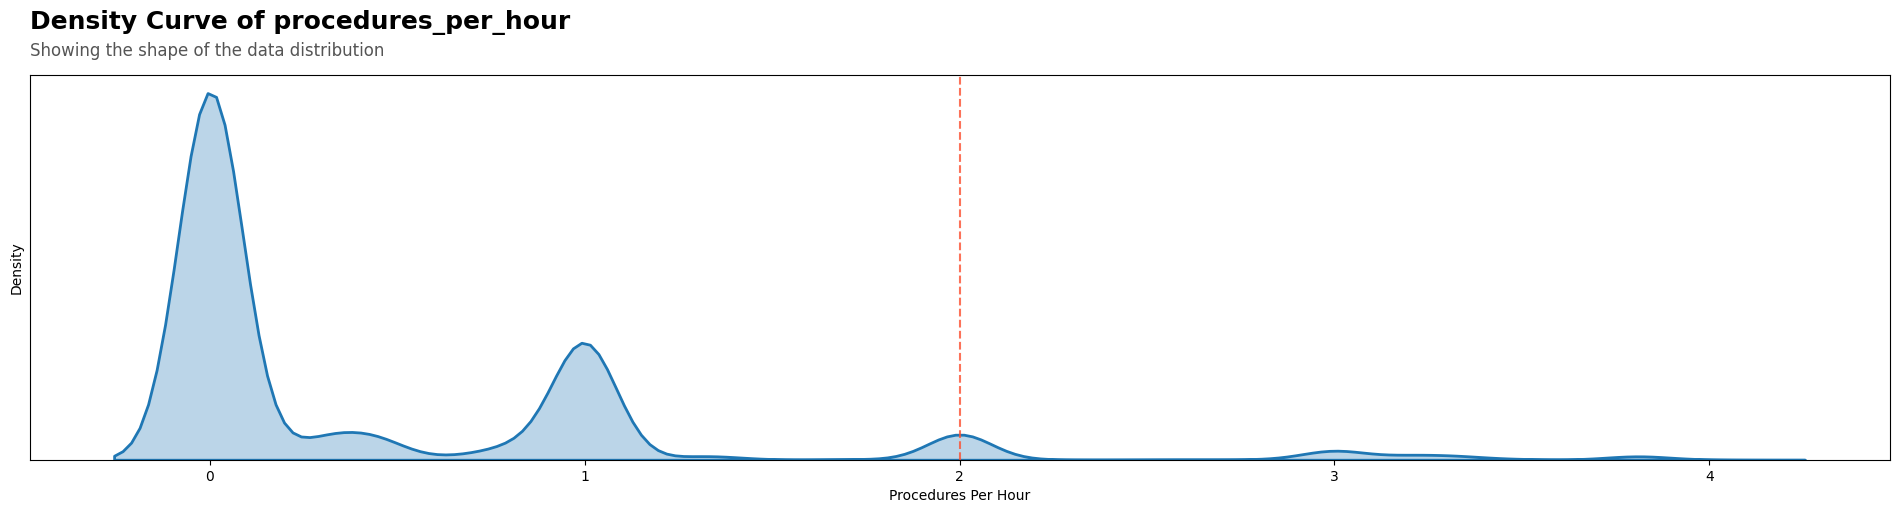

In [104]:
plt.figure(figsize=(24,5))
P.plot_kde('procedures_per_hour',data)

In [105]:
data['procedures_per_hour'].value_counts().div(len(data)).mul(100).round(2).reset_index(name = 'percentage')

procedures_per_hour  percentage
0                   0.00       60.50
1                   1.00       19.04
2                   2.00        4.24
3                   0.44        3.11
4                   0.31        3.09
..                   ...         ...
168                 1.21        0.00
169                 0.56        0.00
170                 3.12        0.00
171                 1.69        0.00
172                 0.49        0.00

[173 rows x 2 columns]

In [106]:
bins = [-1, 0.1, 1.1, 100]
labels = ['LOW', 'MEDIUM', 'HIGH']
data['procedures_per_hour']=pd.DataFrame(pd.cut(data['procedures_per_hour'], bins=bins, labels=labels))
data.rename(columns={'procedures_per_hour':'procedure_intensity'},inplace=True)

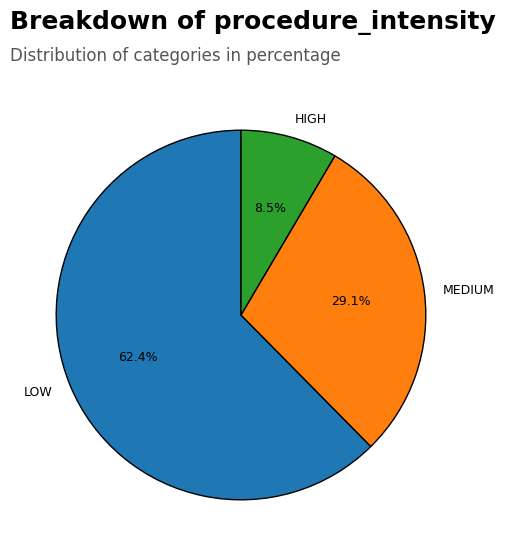

In [107]:
plt.figure(figsize=(6,6))
P.plot_pie('procedure_intensity',data)

- ***changed the `procedure_per_hour` column - most frequent value in new `procedure_intensity` column is `LOW`, `~62%`***

**caused_readmission**

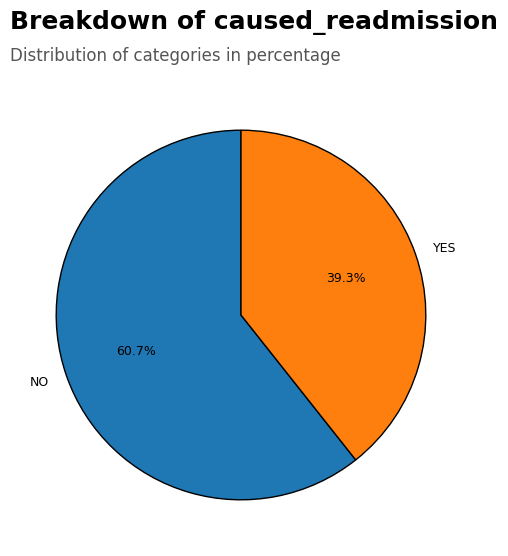

In [112]:
plt.figure(figsize=(6,6))
P.plot_pie('caused_readmission',data)

- ***`Approx 40% of encounters are reason for another readmission`***

### ***Bivariate Analysis***

In [110]:
cat_cols = data.select_dtypes(include='object').columns.values.tolist()

In [111]:
num_cols = data.select_dtypes(include='number').columns.values.tolist()

***CATEGORICAL COLUMNS WITH `caused_readmission` COLUMN***

**encounterclass**

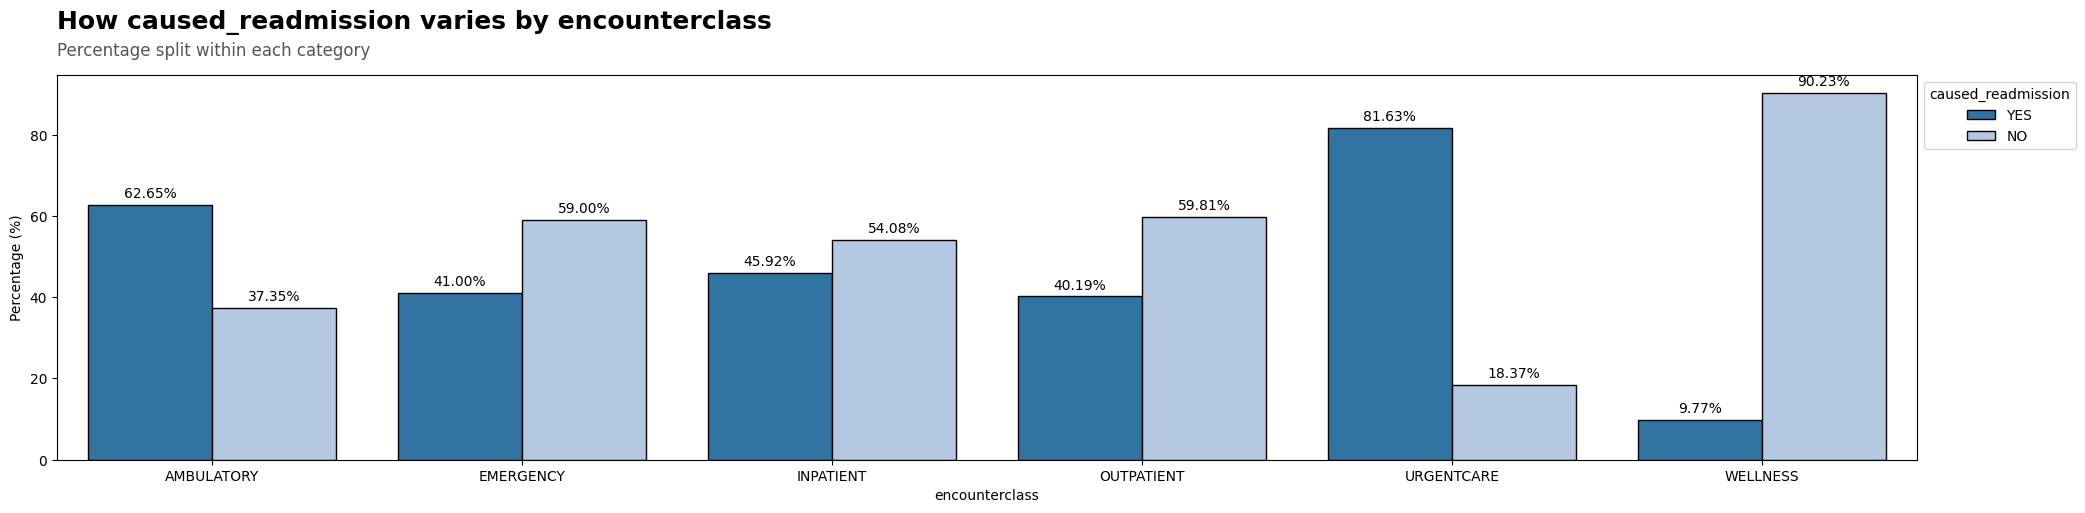

In [115]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='encounterclass',data=data,target='caused_readmission',orient='v')

In [116]:
urgent_care_mask = (data['encounterclass']=='URGENTCARE') | (data['encounterclass']=='AMBULATORY')
ct = pd.crosstab(urgent_care_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.424 → Strong


***
- according to the visuals, `ambulatory and urgentcare encounters showed the most observations for caused readmission`, after doing statistical test we can validate a `strong relationship` between `encounterclass` and `caused_readmission`
***

**is_ongoing_condition**

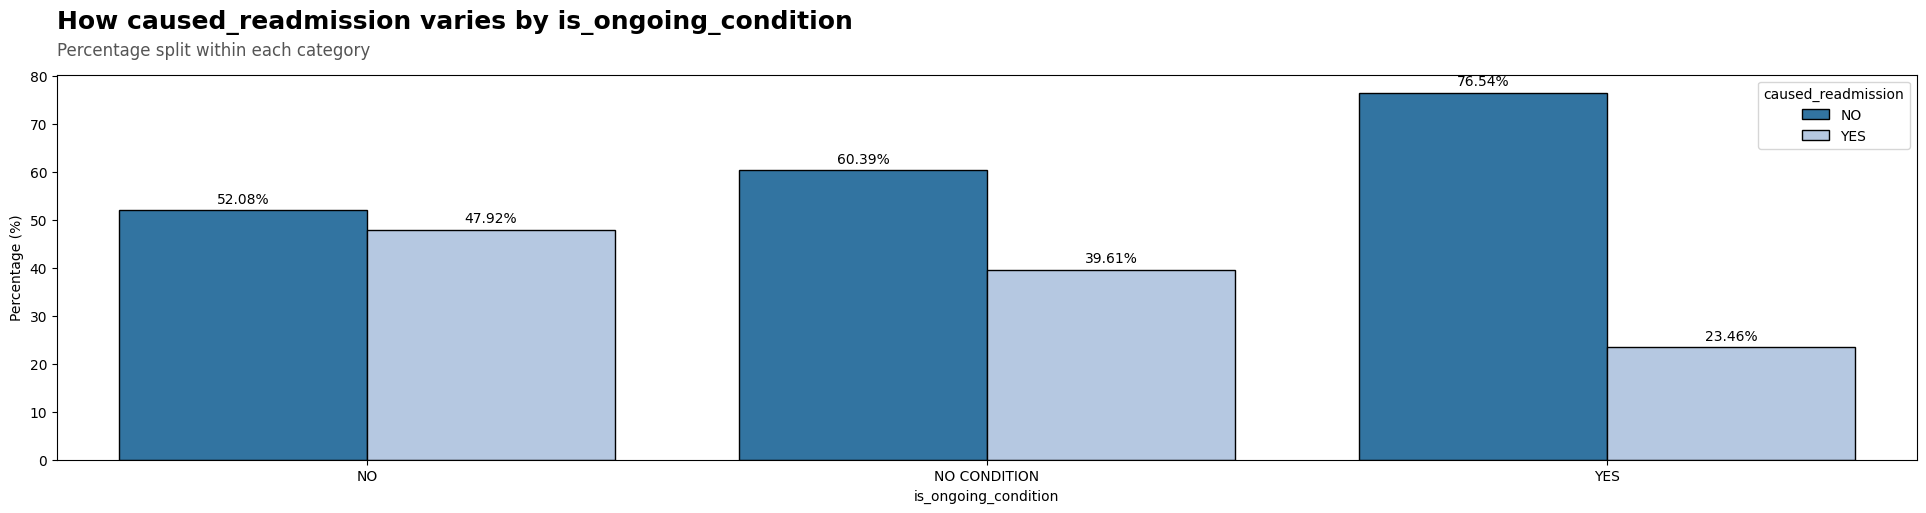

In [118]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='is_ongoing_condition',data=data,target='caused_readmission',orient='v')

In [119]:
ct = pd.crosstab(data['is_ongoing_condition'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.094 → Weak


- ***we do not find anything specific from the visuals, after doing statistical test we found out that there is weak association between caused_readmission and is_ongoing_condition***

**is_ongoin_careplan**

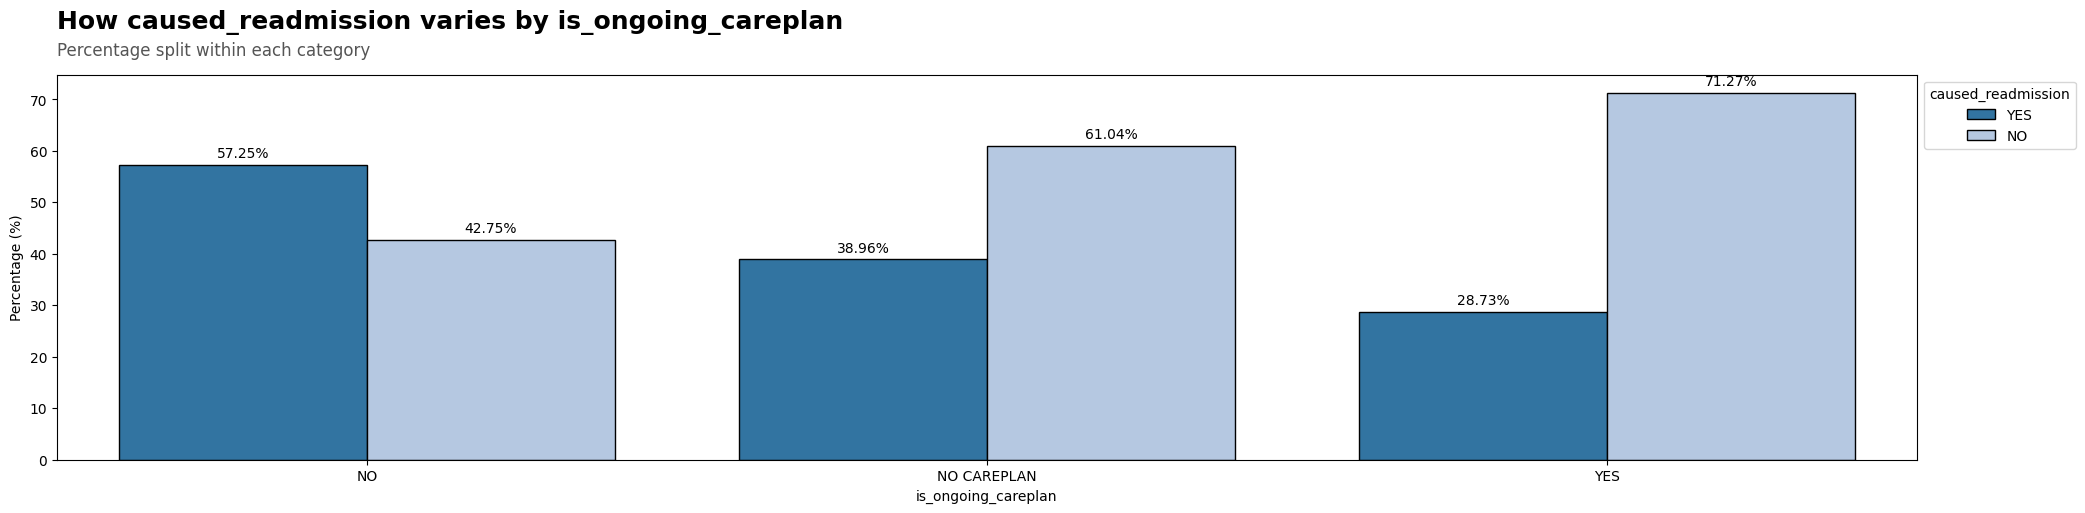

In [120]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='is_ongoing_careplan',data=data,target='caused_readmission',orient='v')

In [127]:
is_ongoing_condition_mask = (data['is_ongoing_careplan']=='NO')
ct = pd.crosstab(is_ongoing_condition_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.071 → Weak


- ***NO careplan was showing a relatively high percentage in caused_readmission = 1 value, but after doing statistical test we found a weak association between is_ongoin_careplan and caused_readmission column***

**total_careplans**

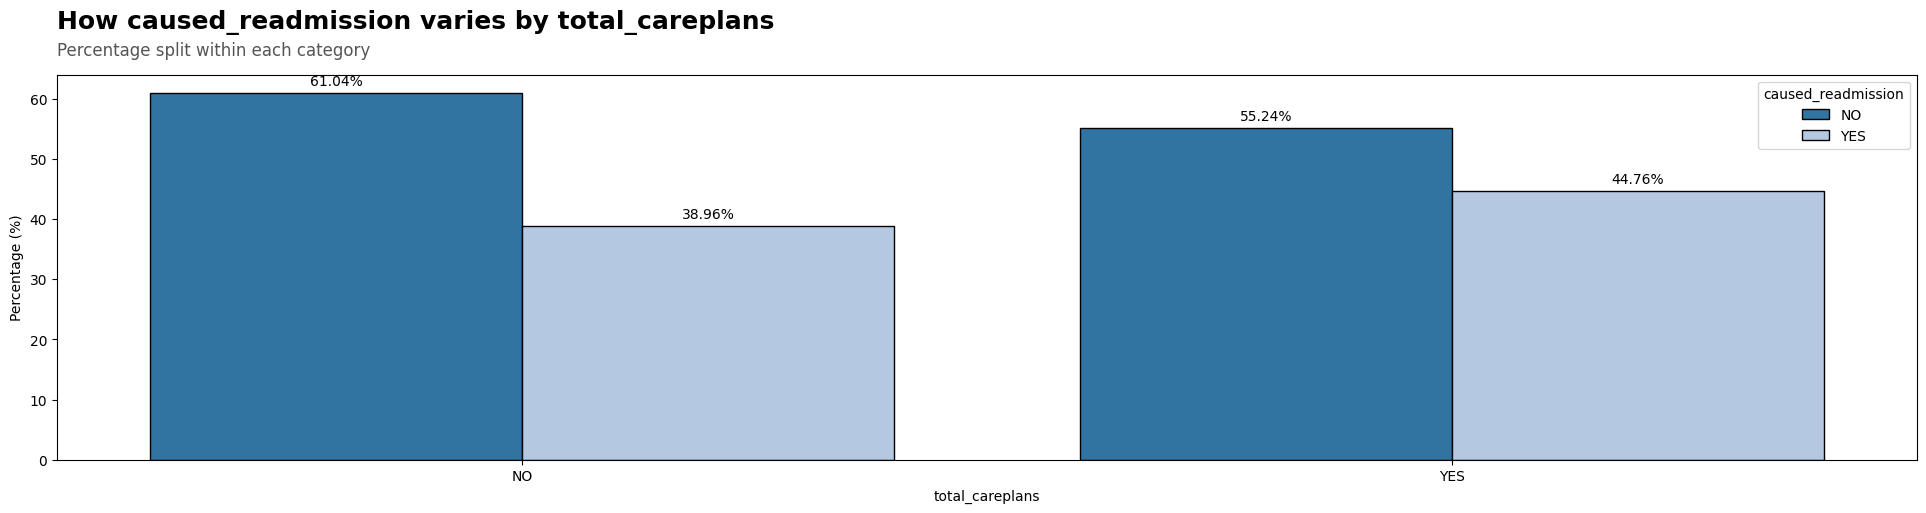

In [122]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_careplans',data=data,target='caused_readmission',orient='v')

In [123]:
ct = pd.crosstab(data['total_careplans'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.029 → Weak


- ***YES total_careplans was showing a relatively high percentage in caused_readmission = 1 value, but after doing statistical test we found a weak association between total_careplans and caused_readmission column***

**marital**

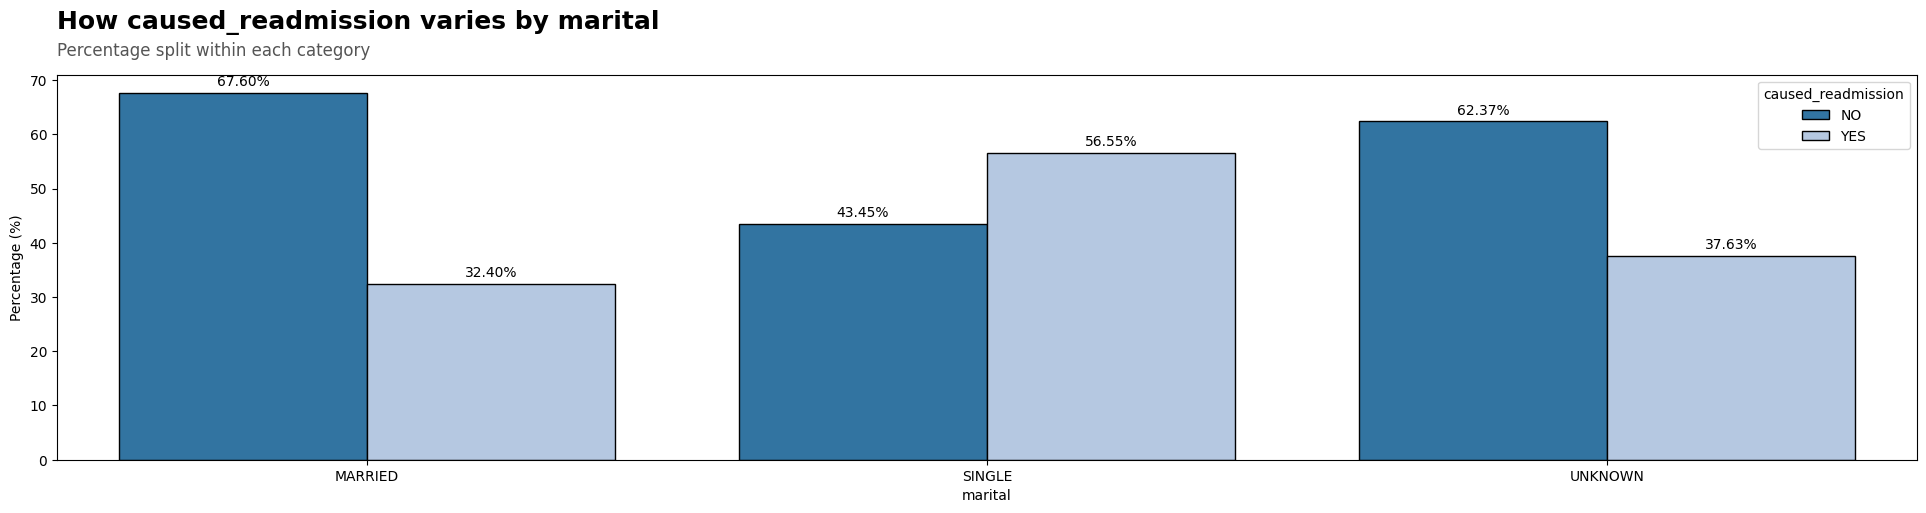

In [124]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='marital',data=data,target='caused_readmission',orient='v')

In [125]:
ct = pd.crosstab(data['marital'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.206 → Moderate


***
- according to the visuals, `SINGLE marital ststus is showing relatively high percentage of caused_readmission = 1`, after doing statistical test we can validate a `moderate relationship` between `marital` and `caused_readmission`
***

**race**

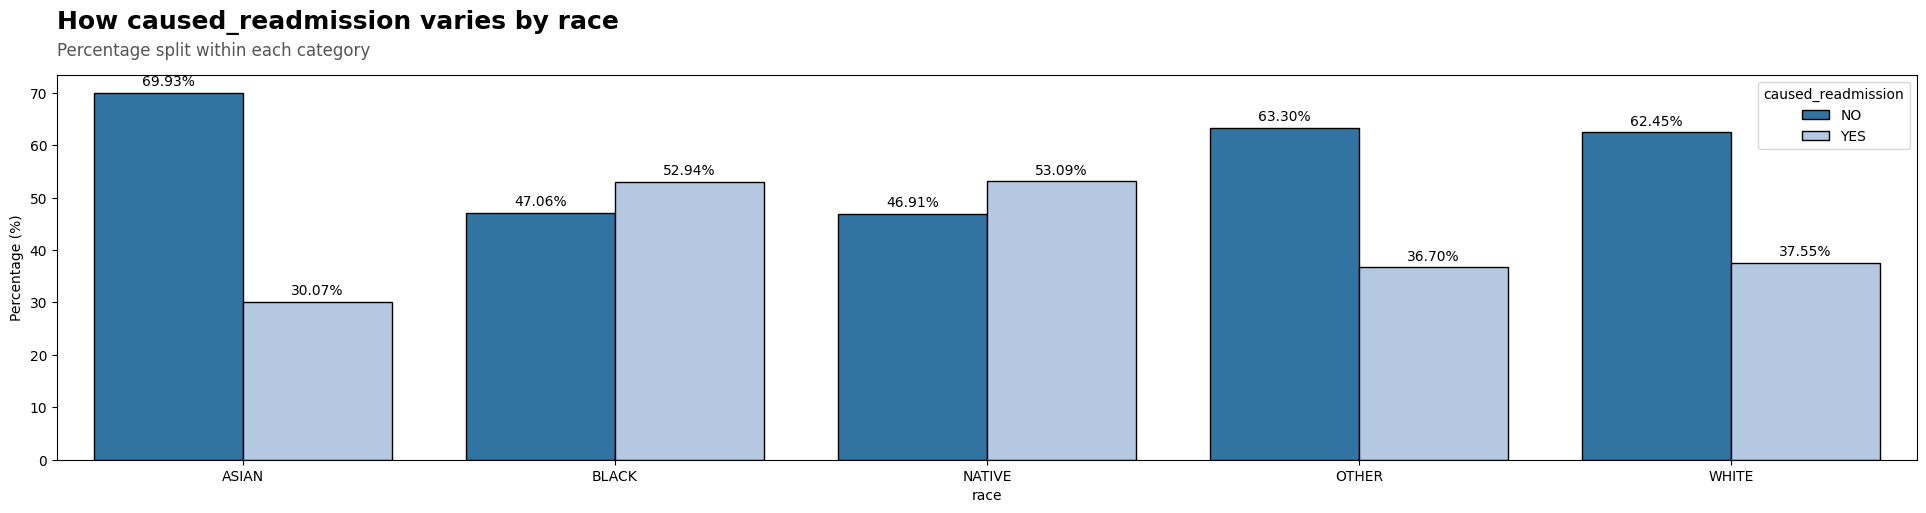

In [126]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='race',data=data,target='caused_readmission',orient='v')

In [128]:
race_mask = (data['race']=='BLACK') |(data['race']=='NATIVE')
ct = pd.crosstab(race_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.116 → Moderate


***
- ***by visuals we saw that `black and native race is showing high percentage of values in caused_readmission = 1`, after doing statistical test we can validate that `cause_readmission` column have a `moderate relationship` with `BLACK` and `NATIVE` race***
***

**ethnicity**

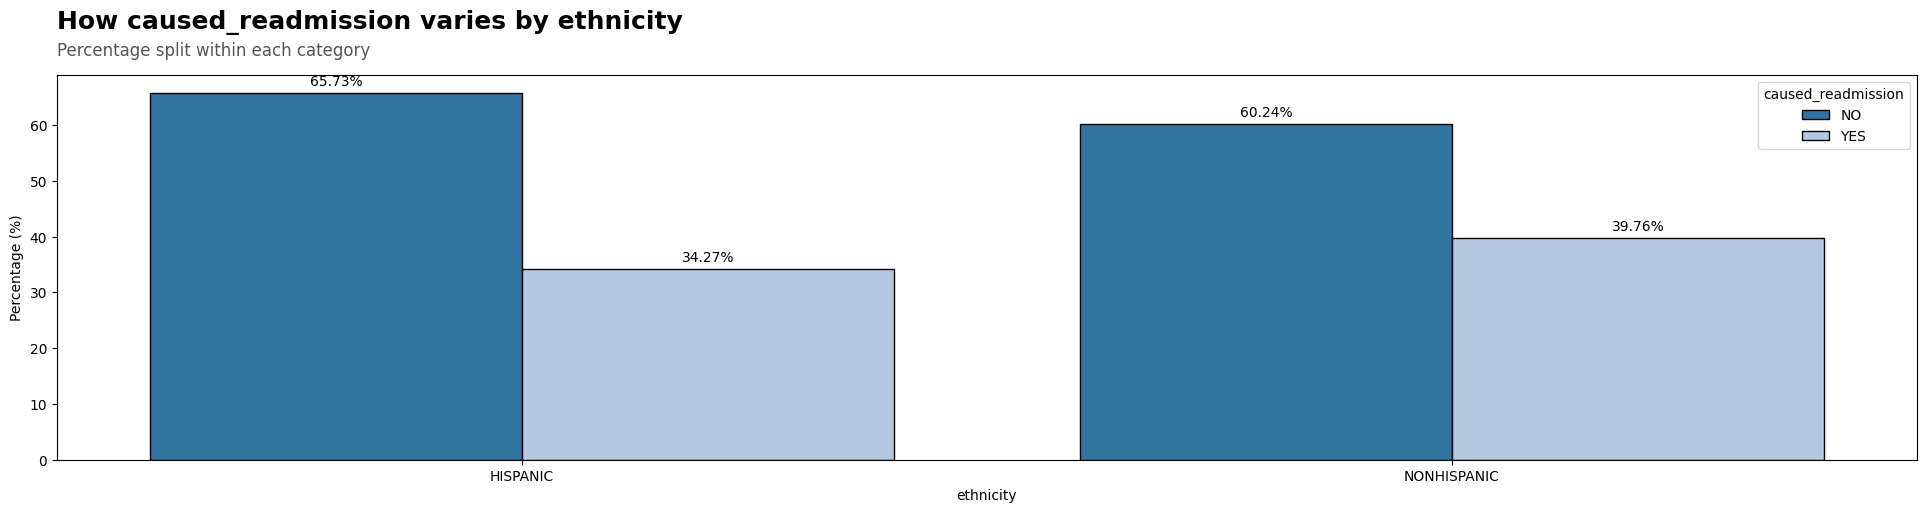

In [129]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='ethnicity',data=data,target='caused_readmission',orient='v')

- ***I dont see anything specific from the visuals***

**patient_gender**

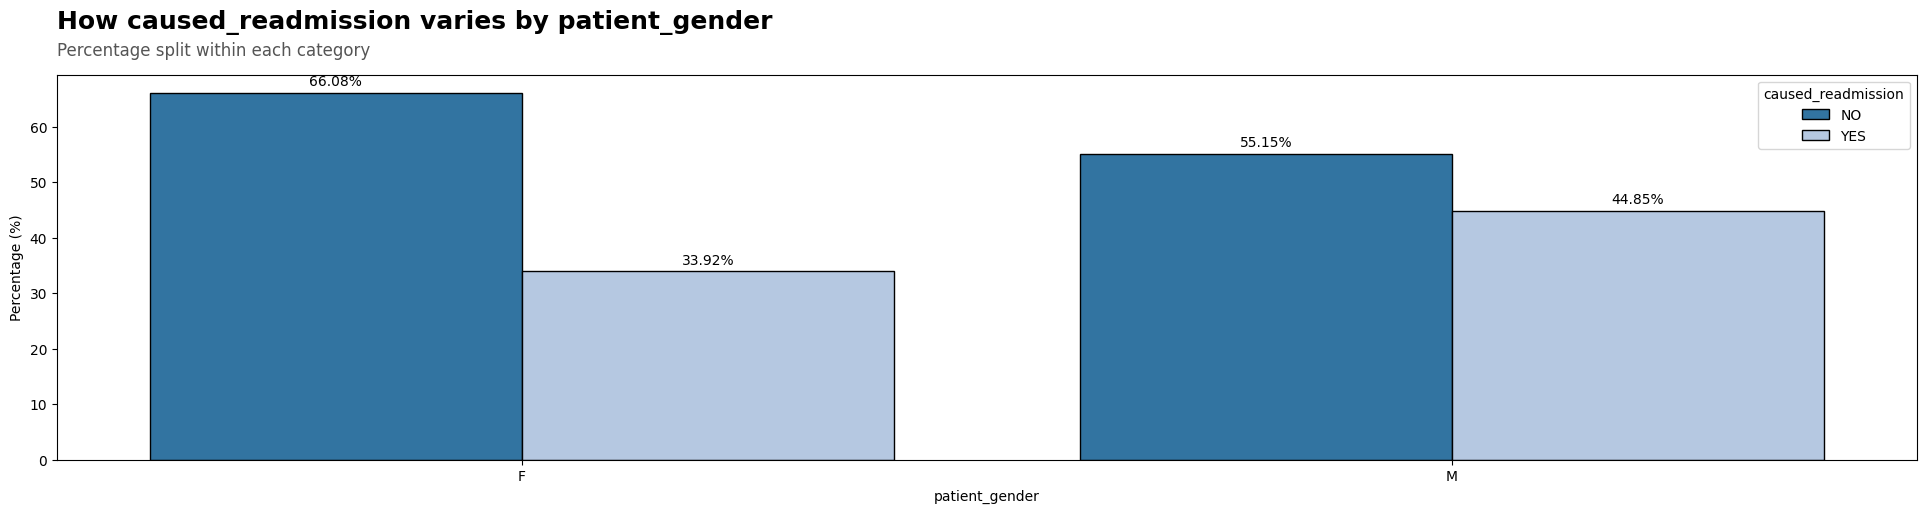

In [130]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='patient_gender',data=data,target='caused_readmission',orient='v')

In [131]:
ct = pd.crosstab(data['patient_gender'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.112 → Moderate


***
- ***by visuals we saw that `M patient gender have slightly more values in caused_readmission = 1`, after doing statistical test we can validate this assumption with `moderate strength`***
***

**provider_gender**

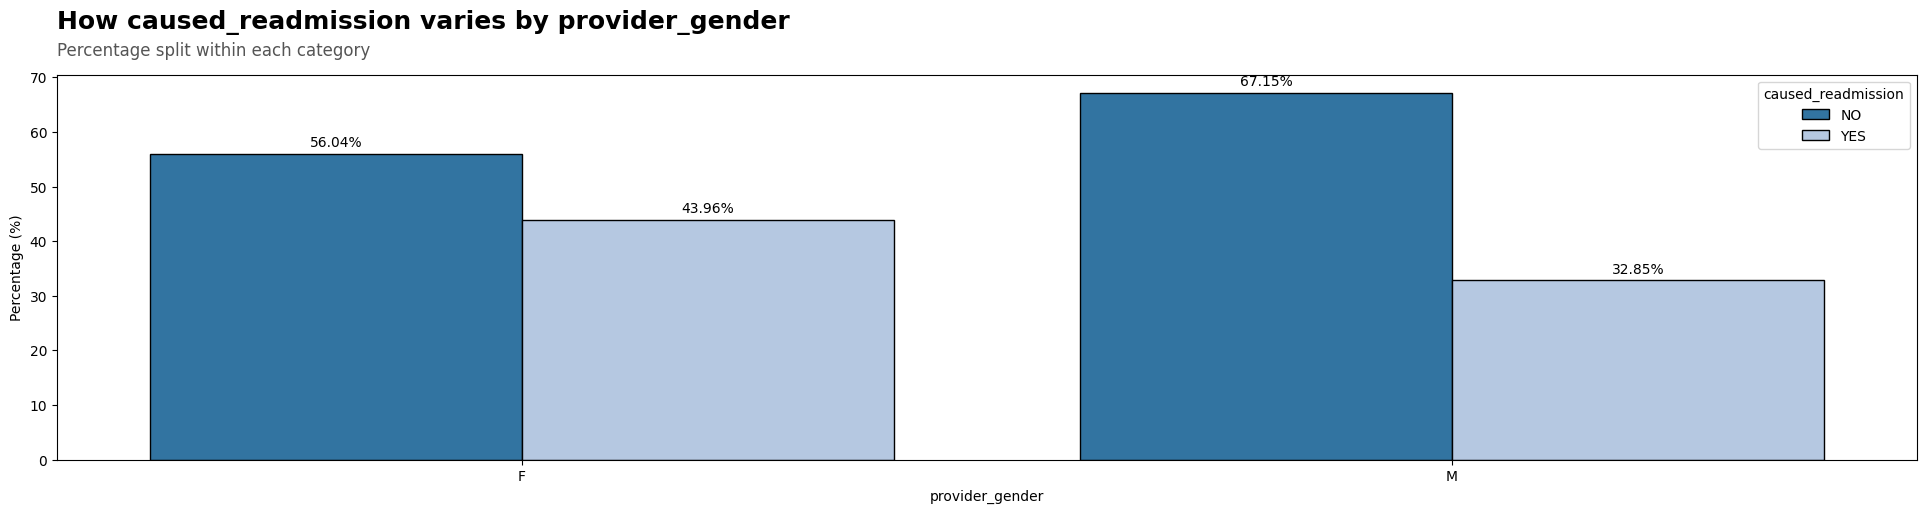

In [132]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='provider_gender',data=data,target='caused_readmission',orient='v')

In [133]:
ct = pd.crosstab(data['provider_gender'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.112 → Moderate


***
- ***by visuals we saw that `F provider_gender have slightly more values in caused_readmission = 1`, after doing statistical test we can validate this assumption with `moderate strength`***
***

### ***Co-Relation Analysis***

### ***Multivariate Analysis***

### ***Outlier Interpretation from numerical columns***

- **max value of `avg_procedure_cost` is very high**

- **max value of `average_total_medicine_cost` is too high**

- **`utilization` column is spreaded from 1 to 4828**

- **`age` column have values from 0 to 112 as of 2022**

- **max value in `condition_duration` is too high**

- **max value for `careplan_duration` is also very high**

In [21]:
data.describe(include='object').T

count unique                  top   freq
encounter_start  53346  50029  1973-07-27 23:35:03      7
encounterclass   53346      6             WELLNESS  19106
duration         53346      4             same_day  51759
marital          53346      3              MARRIED  30413
race             53346      5                WHITE  41794
ethnicity        53346      2          NONHISPANIC  49267
patient_gender   53346      2                    F  26891
provider_gender  53346      2                    F  31135

### ***Statistical insights from categorical columns***

- **max `encounter` in single day is 7**

- **`encounter_class` have 6 uniqe values, wellness being most frequent**

- **`duration` column have 4 unique values, same_day being the most frequent**

## **Univariate Analysis**

**encounter_class**

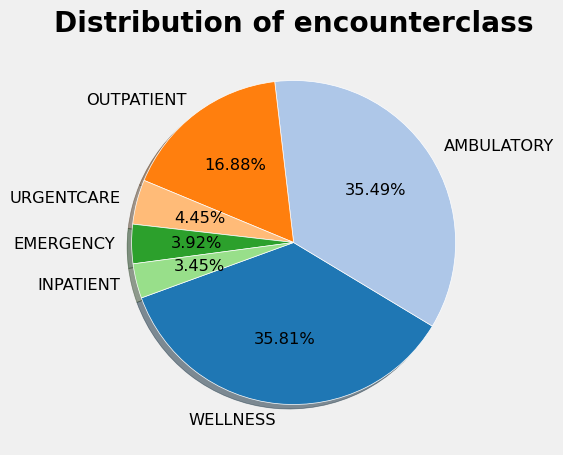

In [22]:
plt.figure(figsize=(5,5))
P.plot_pie(column='encounterclass',data = data)
plt.show()

- **nearly 70% of observations are from wellness and ambulatory class**

**base_encounter_cost**

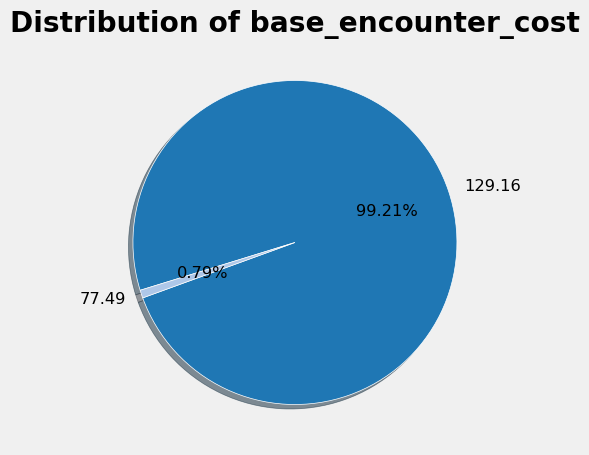

In [23]:
plt.figure(figsize=(5,5))
P.plot_pie(column='base_encounter_cost',data = data)
plt.show()

In [24]:
data['base_encounter_cost']=data['base_encounter_cost'].astype('object')

***
- **only `2 types` of cost is associated with `encounters`, and more than `99%` of them being `129.16`**
***

**payer_coverage**

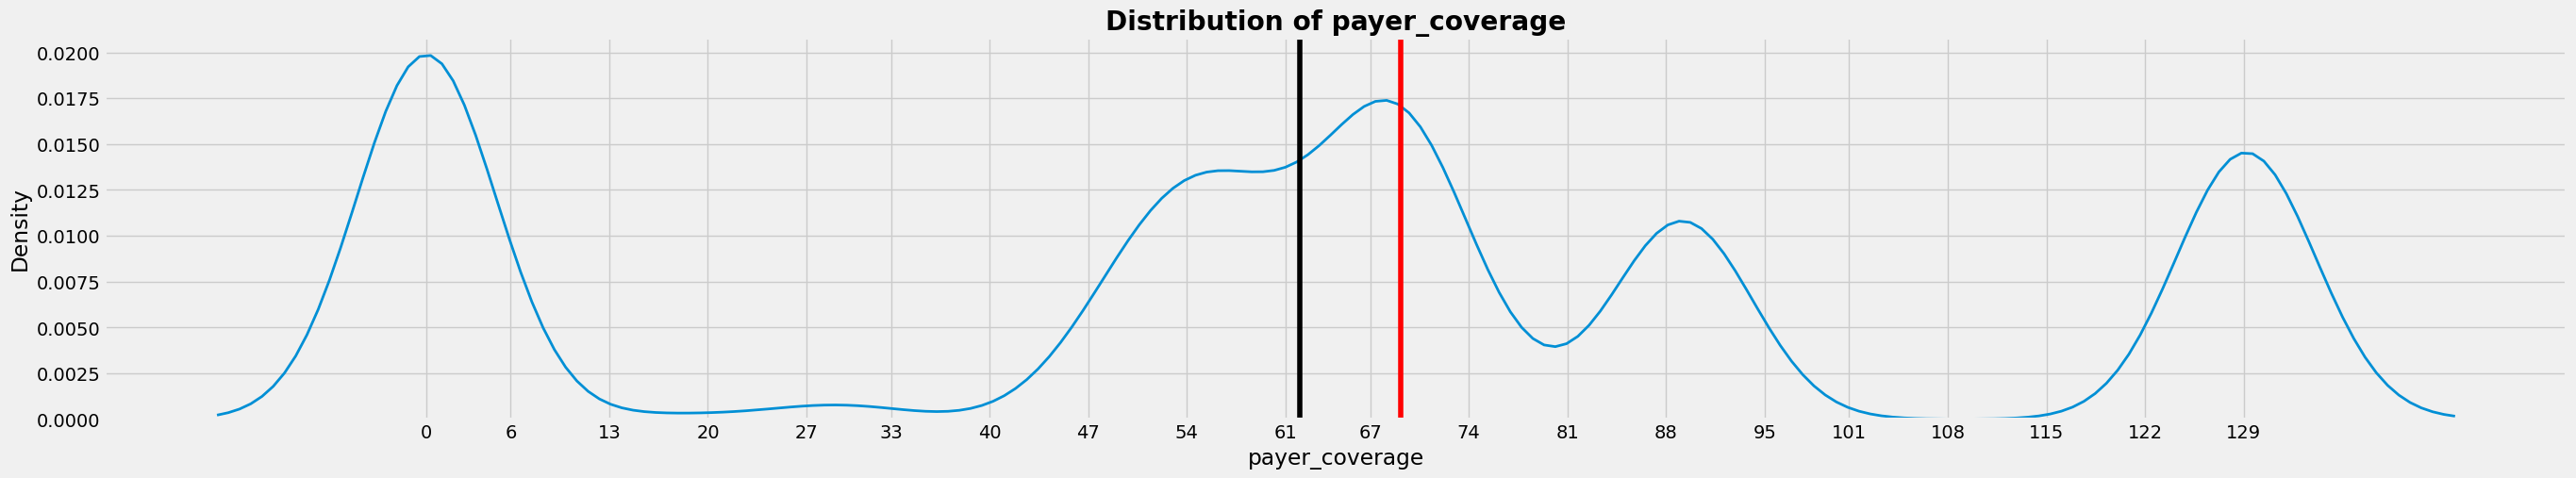

In [25]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'payer_coverage',data= data,line_val=.50)
plt.axvline(data['payer_coverage'].mean(),color = 'black')
plt.show()

- **there is peak in both the end as well as in the middle**

**duration**

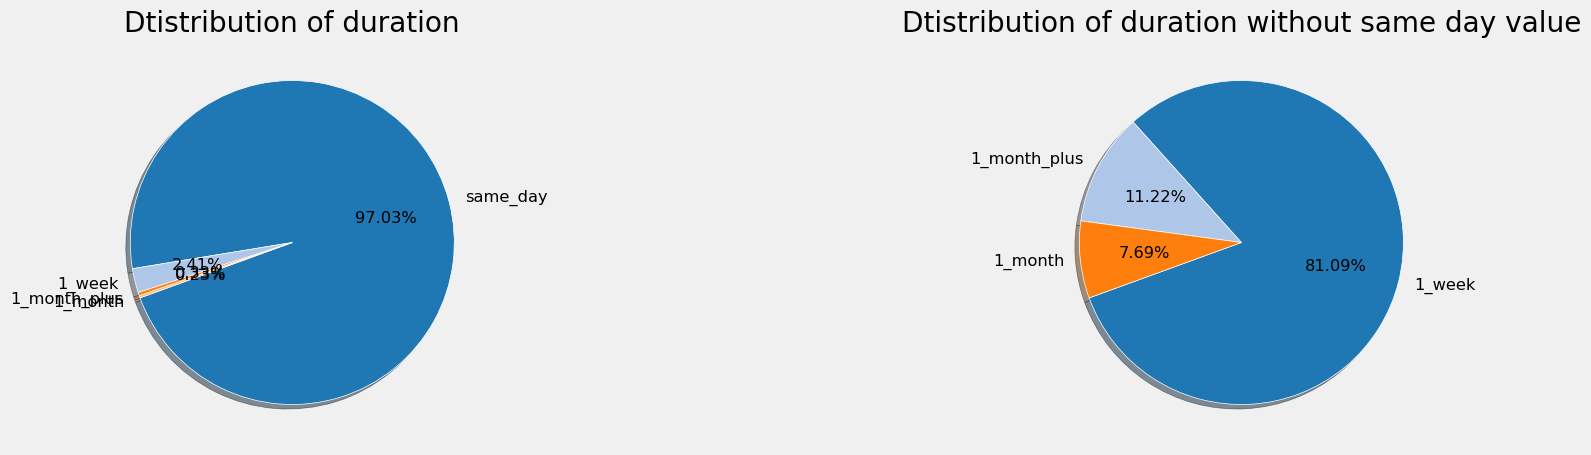

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
P.plot_pie(column='duration',data = data)
plt.title('Dtistribution of duration')
plt.subplot(1,2,2)
P.plot_pie(column='duration',data = data[data['duration'] != 'same_day'])
plt.title('Dtistribution of duration without same day value')
plt.show()

***
- **more than `97%` of encounter have `same day duration`, and among other duration category `1 week` is most frequent**
***

**total_procedures**

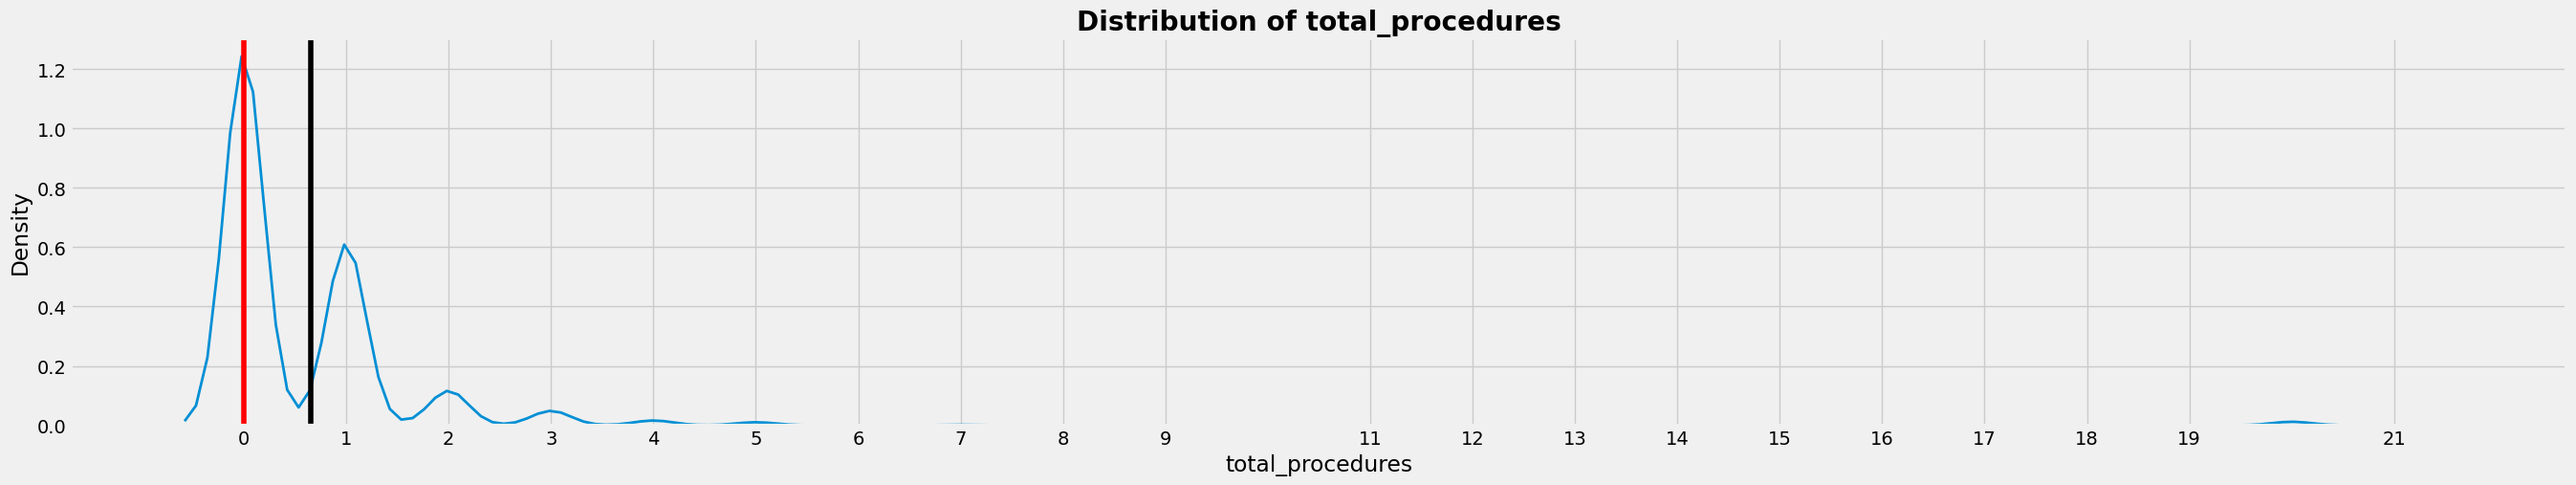

In [27]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_procedures',data= data,line_val=.50)
plt.axvline(data['total_procedures'].mean(),color = 'black')
plt.show()

In [28]:
data.groupby('total_procedures').size()

total_procedures
0     32274
1     15787
2      3000
3      1255
4       415
5       264
6         2
7        42
20      306
21        1
dtype: int64

In [29]:
data['total_procedures']=data['total_procedures'].apply(lambda x: '5+' if x>5 else str(x))

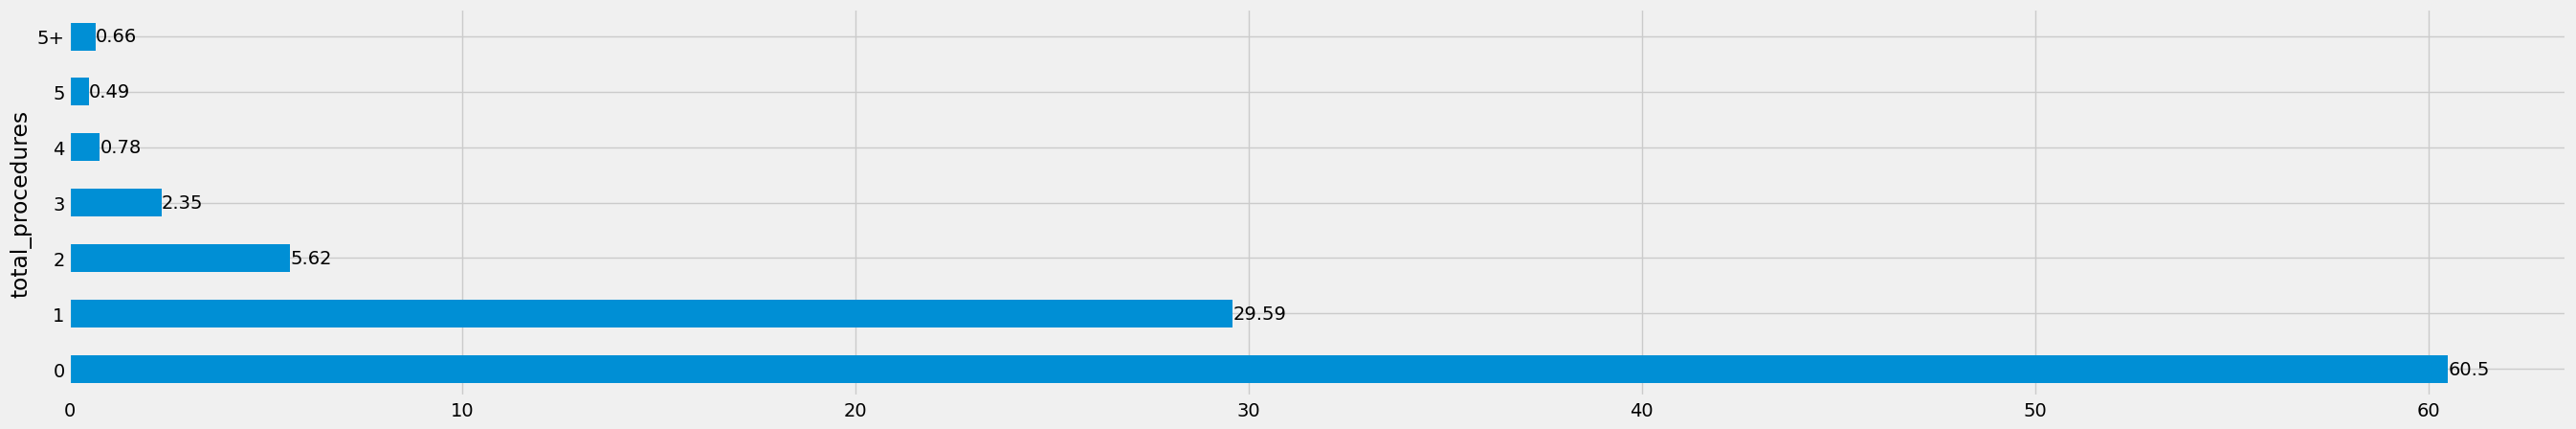

In [30]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_procedures').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

***
- **`60%` of encounter do not included with any kind of `procedures`**
***

**avg_procedure_cost**

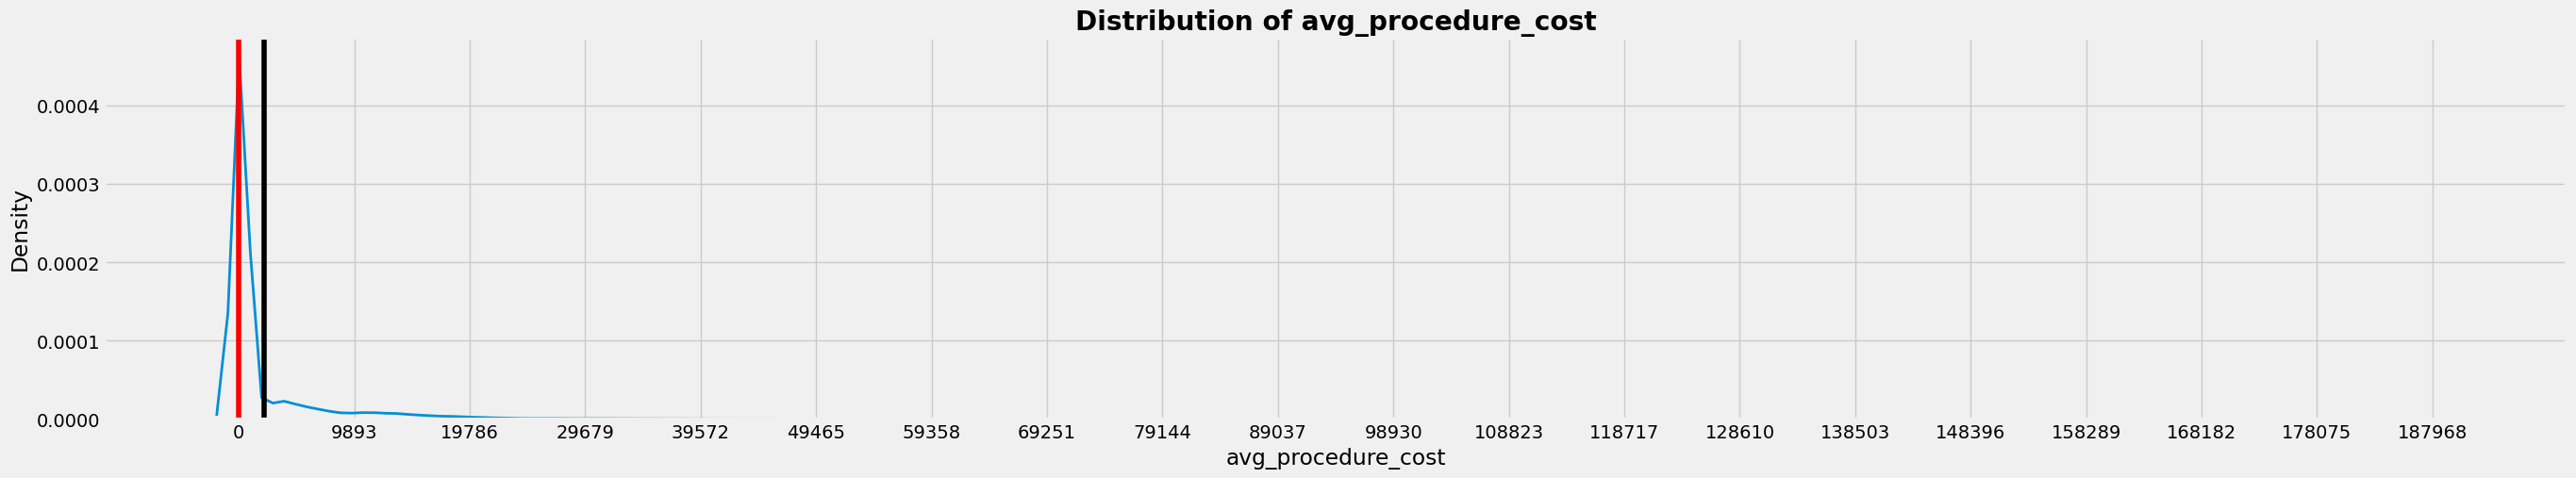

In [31]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_procedure_cost',data= data,line_val=.50)
plt.axvline(data['avg_procedure_cost'].mean(),color = 'black')
plt.show()

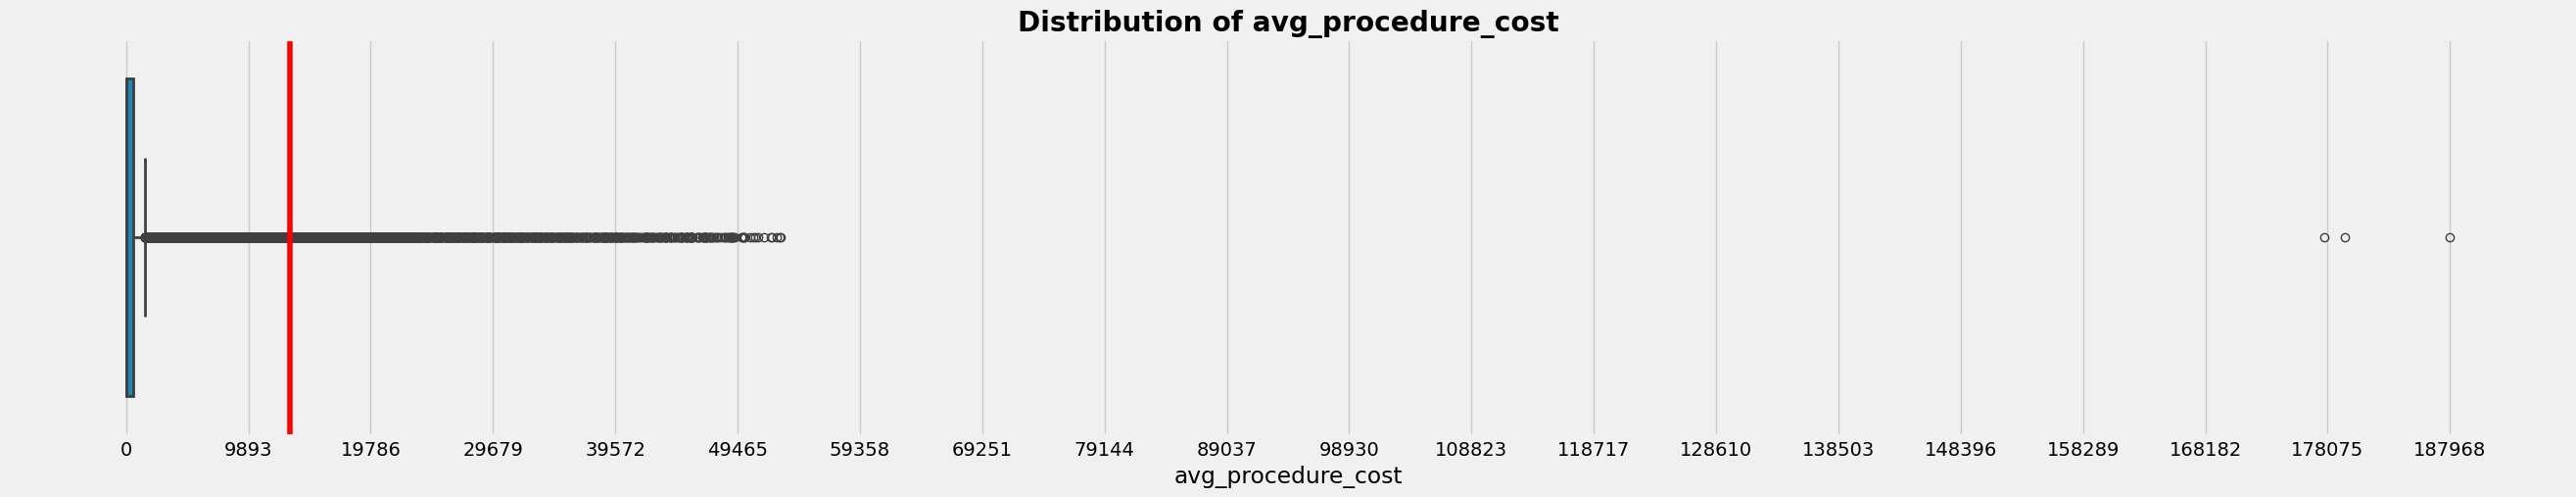

In [32]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_procedure_cost',data= data)
plt.show()

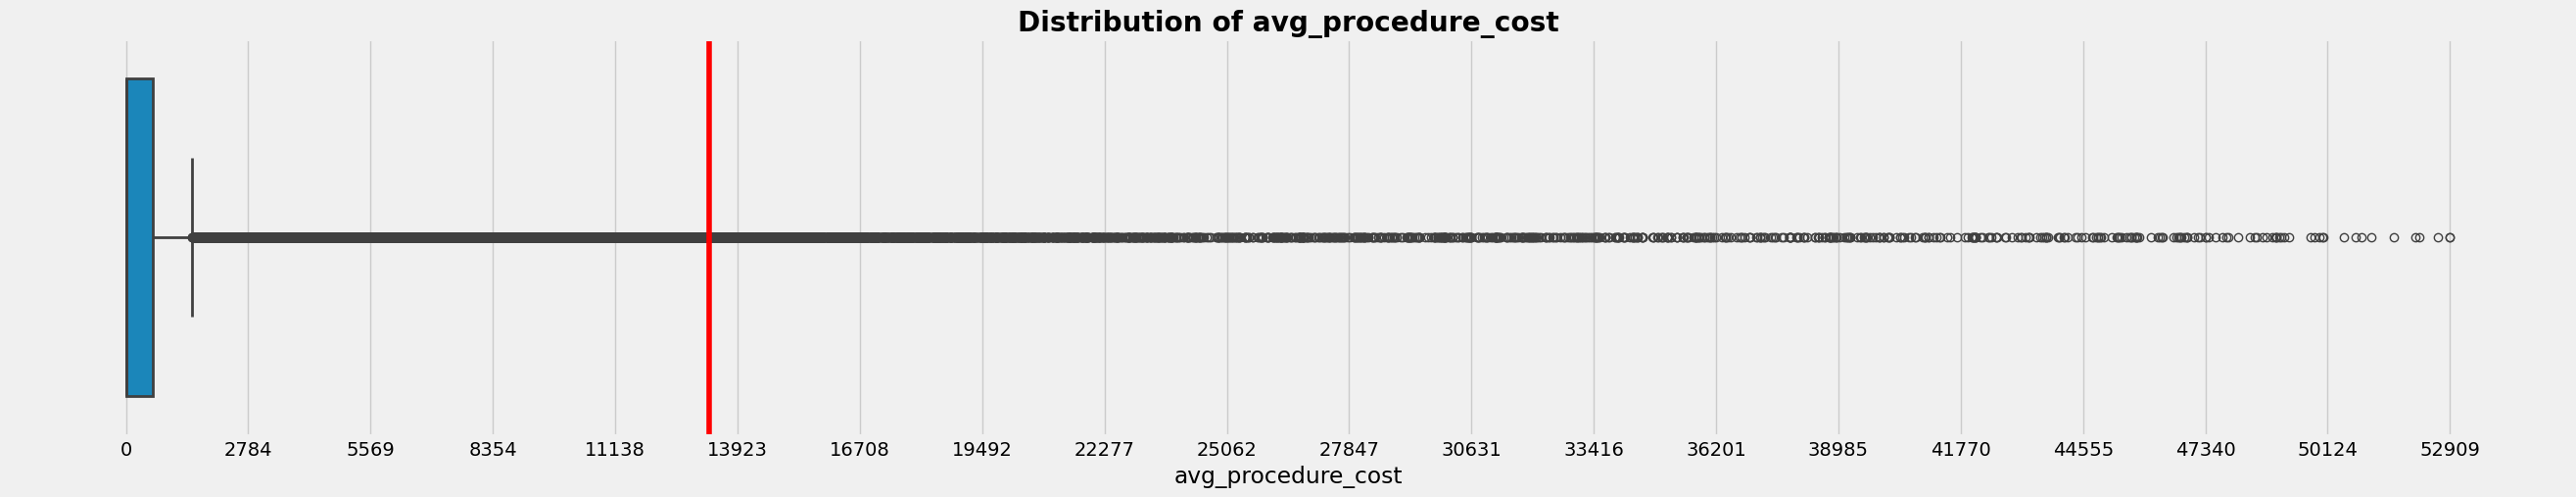

In [33]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_procedure_cost',data= data[data['avg_procedure_cost'] < 100000])
plt.show()

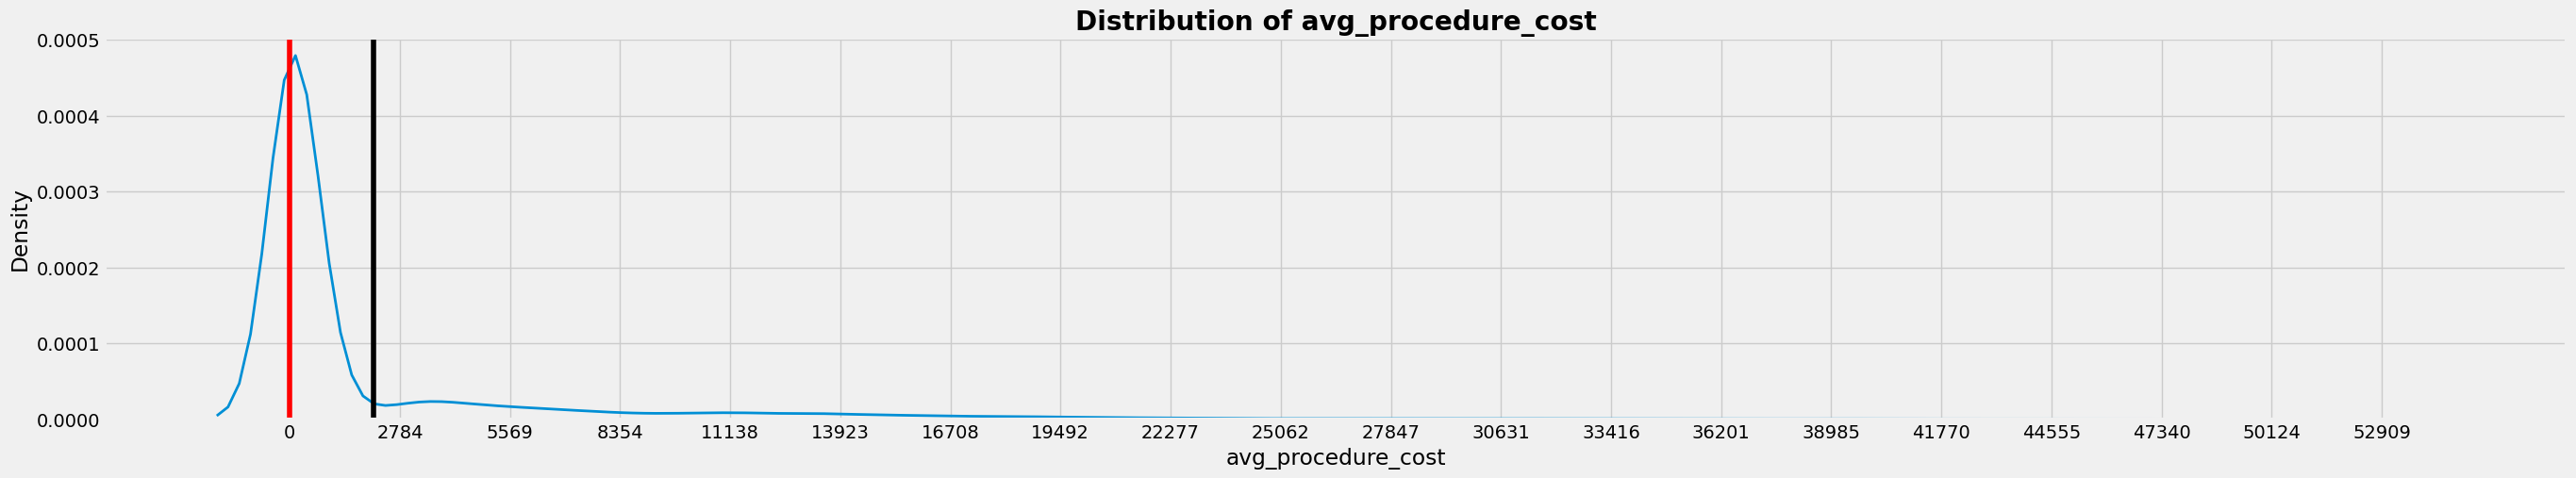

In [34]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_procedure_cost',data= data[data['avg_procedure_cost'] < 100000],line_val=.50)
plt.axvline(data[data['avg_procedure_cost'] < 100000]['avg_procedure_cost'].mean(),color = 'black')
plt.show()

In [35]:
data[data['avg_procedure_cost'] > 100000]

encounter_start encounterclass base_encounter_cost  payer_coverage  \
3214  1991-06-21 20:51:21      INPATIENT              129.16             0.0   
4447  1993-08-18 16:26:18      INPATIENT              129.16             0.0   
9318  2014-09-13 15:02:20      INPATIENT              129.16             0.0   

     duration total_procedures  avg_procedure_cost  total_medicines  \
3214   1_week                1           187968.69                0   
4447   1_week                1           177834.83                0   
9318   1_week                1           179470.09                0   

      avg_base_medicine_cost  avg_total_medicine_cost  \
3214                     0.0                      0.0   
4447                     0.0                      0.0   
9318                     0.0                      0.0   

      reasons_for_medications  is_ongoing_condition  total_conditions  \
3214                        0                    -1                 0   
4447                        0                    -1                 0   
9318                        0                    -1                 0   

      is_ongoing_careplan  total_careplans  age_as_2022  marital   race  \
3214                   -1                0           54  MARRIED  BLACK   
4447                   -1                0           41   SINGLE  WHITE   
9318                   -1                0           67   SINGLE  WHITE   

        ethnicity patient_gender provider_gender  utilization  \
3214  NONHISPANIC              F               F         1314   
4447  NONHISPANIC              M               M         1643   
9318     HISPANIC              M               F         2225   

      caused_readmission  condition_duration  careplan_duration  
3214                   0                   0                  0  
4447                   1                   0                  0  
9318                   1                   0                  0

In [36]:
data[data['avg_procedure_cost'] < 100000]['avg_procedure_cost'].describe().round(2)

count    53343.00
mean      2119.35
std       5431.67
min          0.00
25%          0.00
50%          0.00
75%        601.96
max      52909.50
Name: avg_procedure_cost, dtype: float64

In [37]:
data['avg_procedure_cost'].describe().round(2)

count     53346.00
mean       2129.45
std        5596.18
min           0.00
25%           0.00
50%           0.00
75%         602.04
max      187968.69
Name: avg_procedure_cost, dtype: float64

***
- **There are 3 `extreme outliers` in `avg_procedure_cost` column, and data is skewed towards right**
***

**total_medicines**

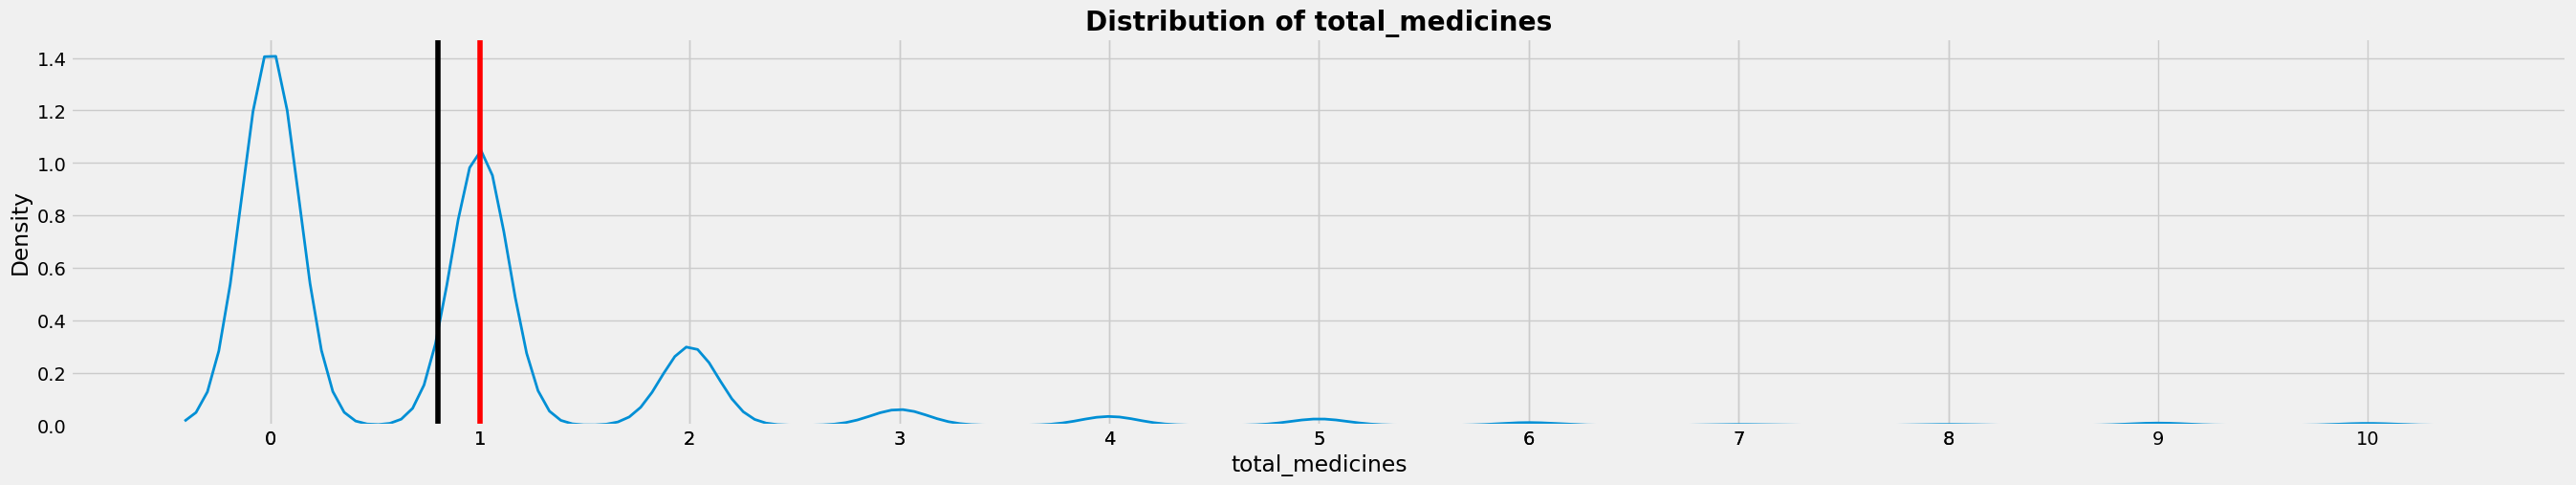

In [38]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_medicines',data= data,line_val=.50)
plt.axvline(data['total_medicines'].mean(),color = 'black')
plt.show()

In [39]:
temp = data.groupby('total_medicines').size().reset_index(name = 'values')
temp['cumsum'] = np.cumsum(temp['values'])
temp

total_medicines  values  cumsum
0                 0   26077   26077
1                 1   19062   45139
2                 2    5463   50602
3                 3    1095   51697
4                 4     613   52310
5                 5     441   52751
6                 6     190   52941
7                 7      58   52999
8                 8      61   53060
9                 9     154   53214
10               10     132   53346

In [40]:
data['total_medicines']=data['total_medicines'].apply(lambda x: '5+' if (x>5)  else str(x))

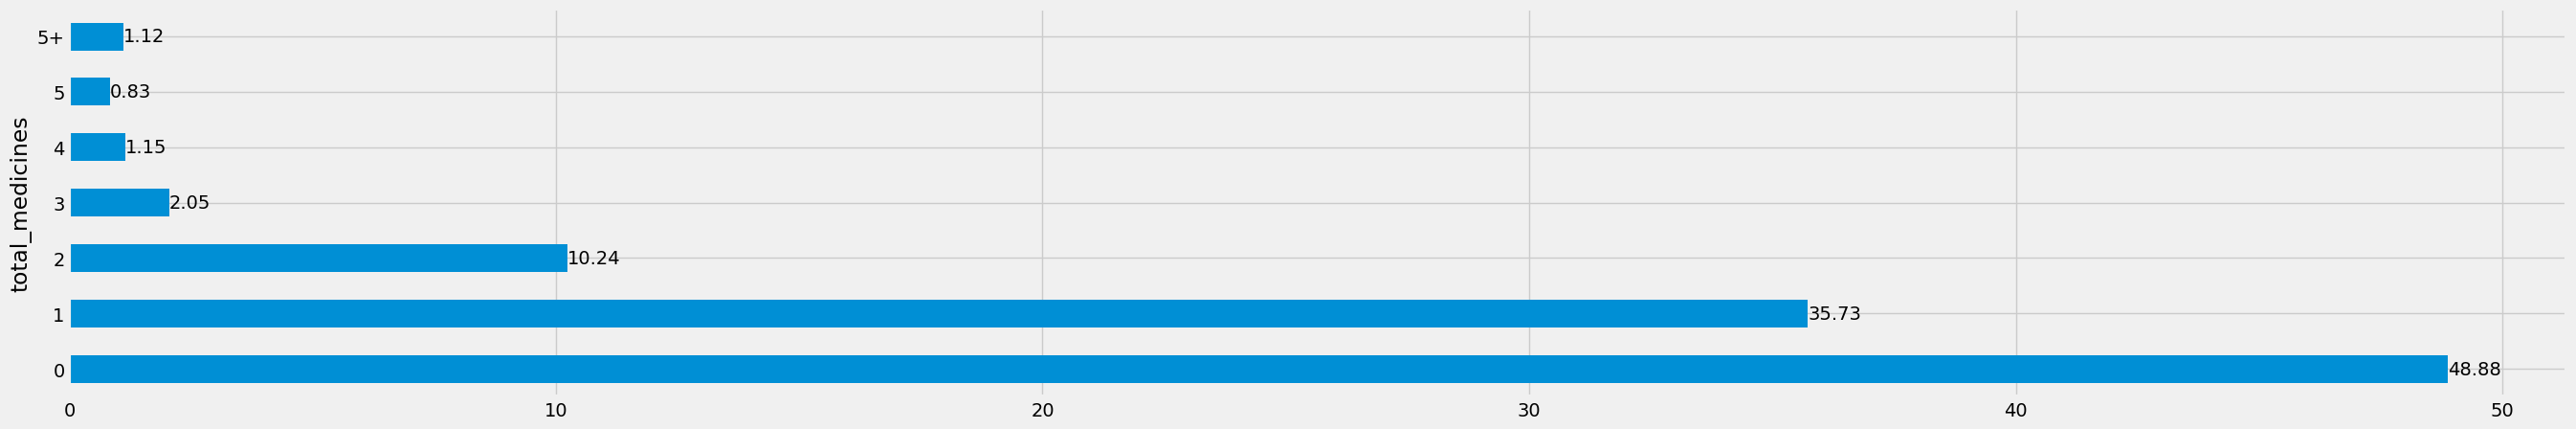

In [41]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_medicines').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

***
- **nearly half the times, total medicine `0` occurs**
***

**avg_base_medicine_cost**

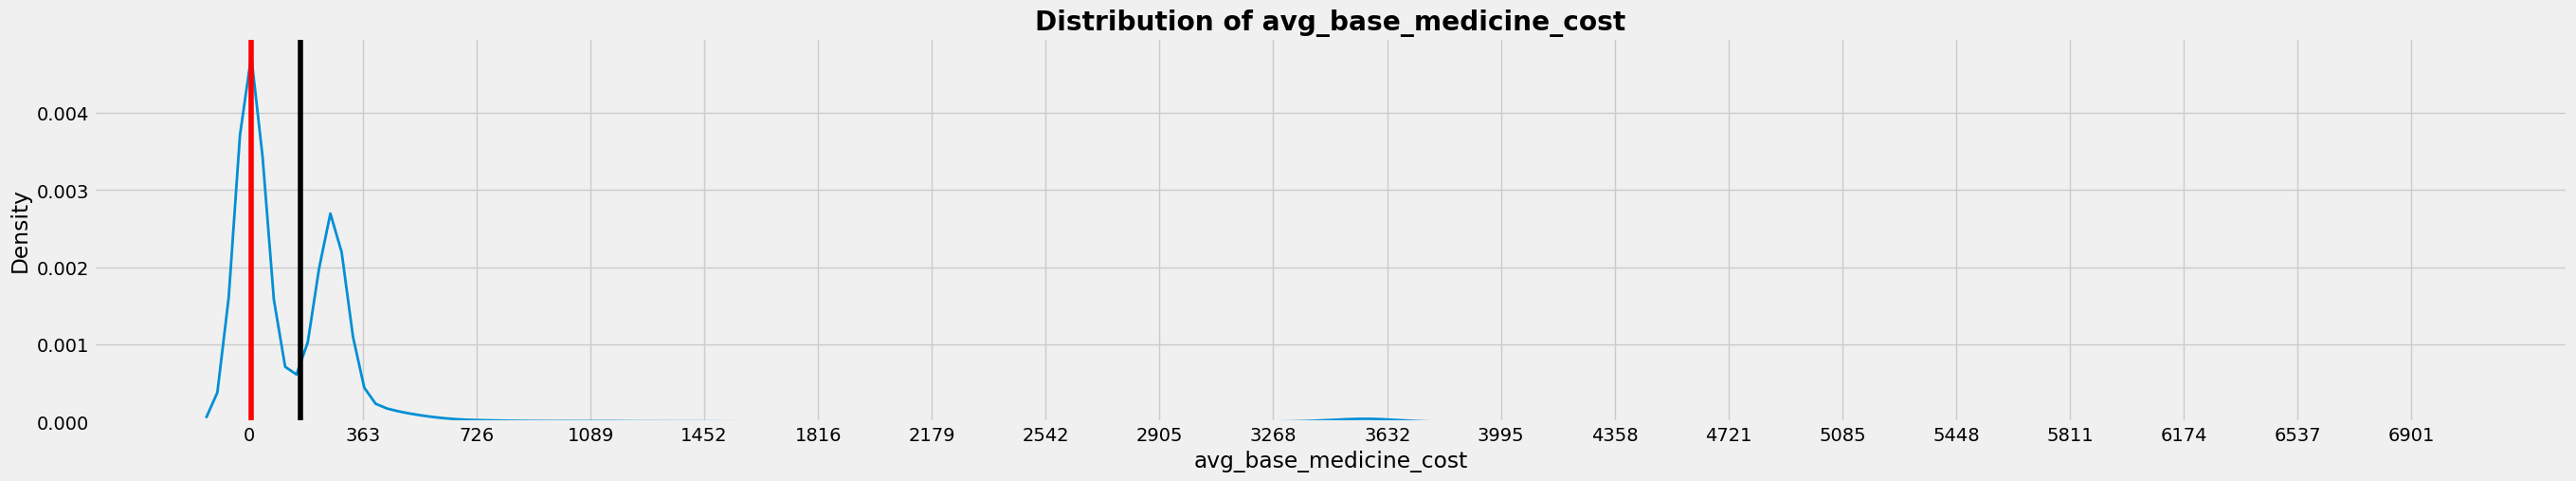

In [42]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_base_medicine_cost',data= data,line_val=.50)
plt.axvline(data['avg_base_medicine_cost'].mean(),color = 'black')
plt.show()

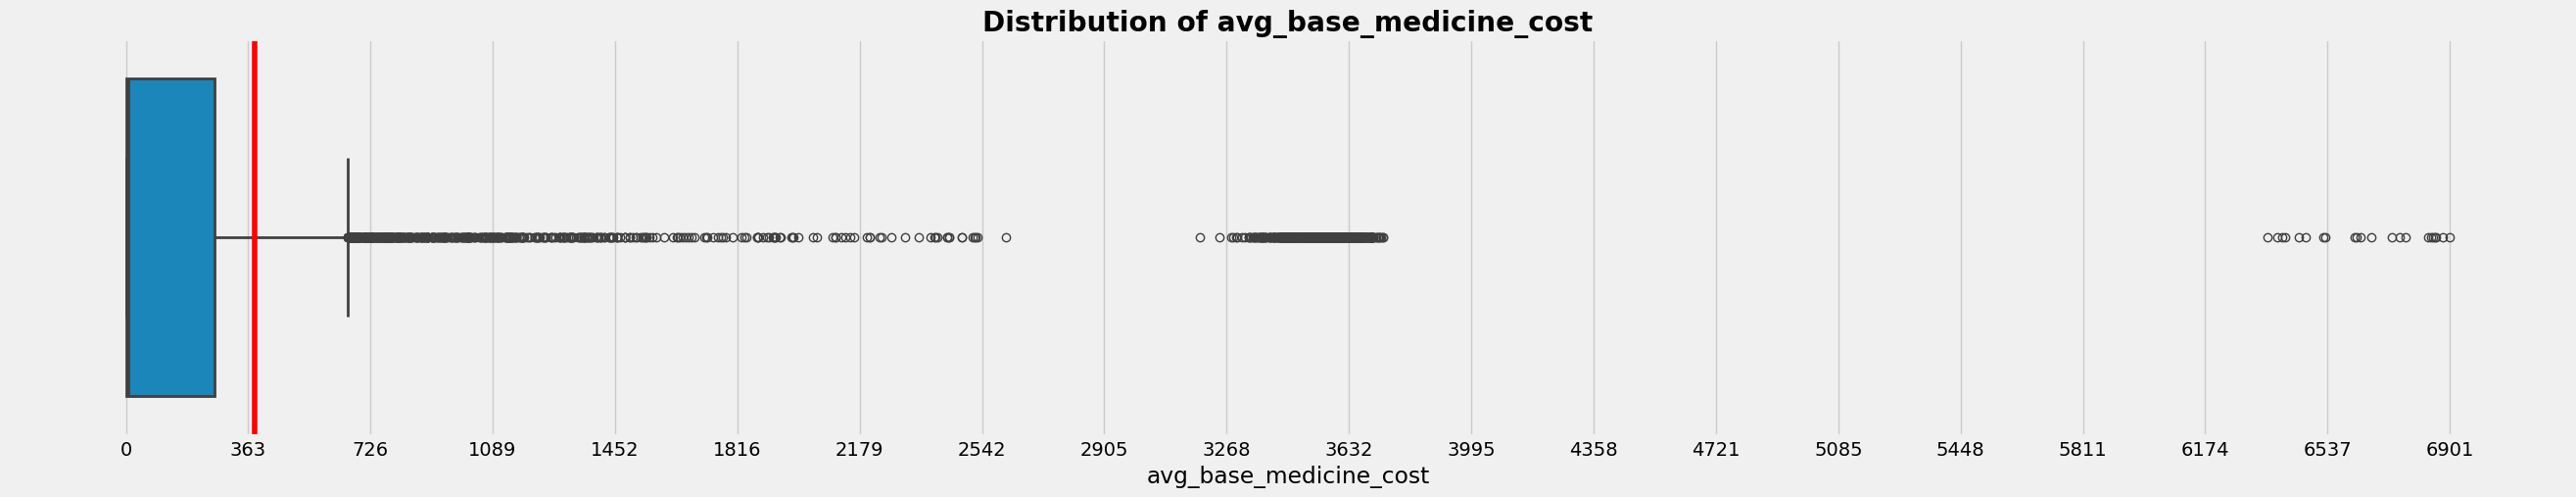

In [43]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_base_medicine_cost',data= data)
plt.show()

- **There are outliers in 2 separate groups**

**avg_total_medicine_cost**

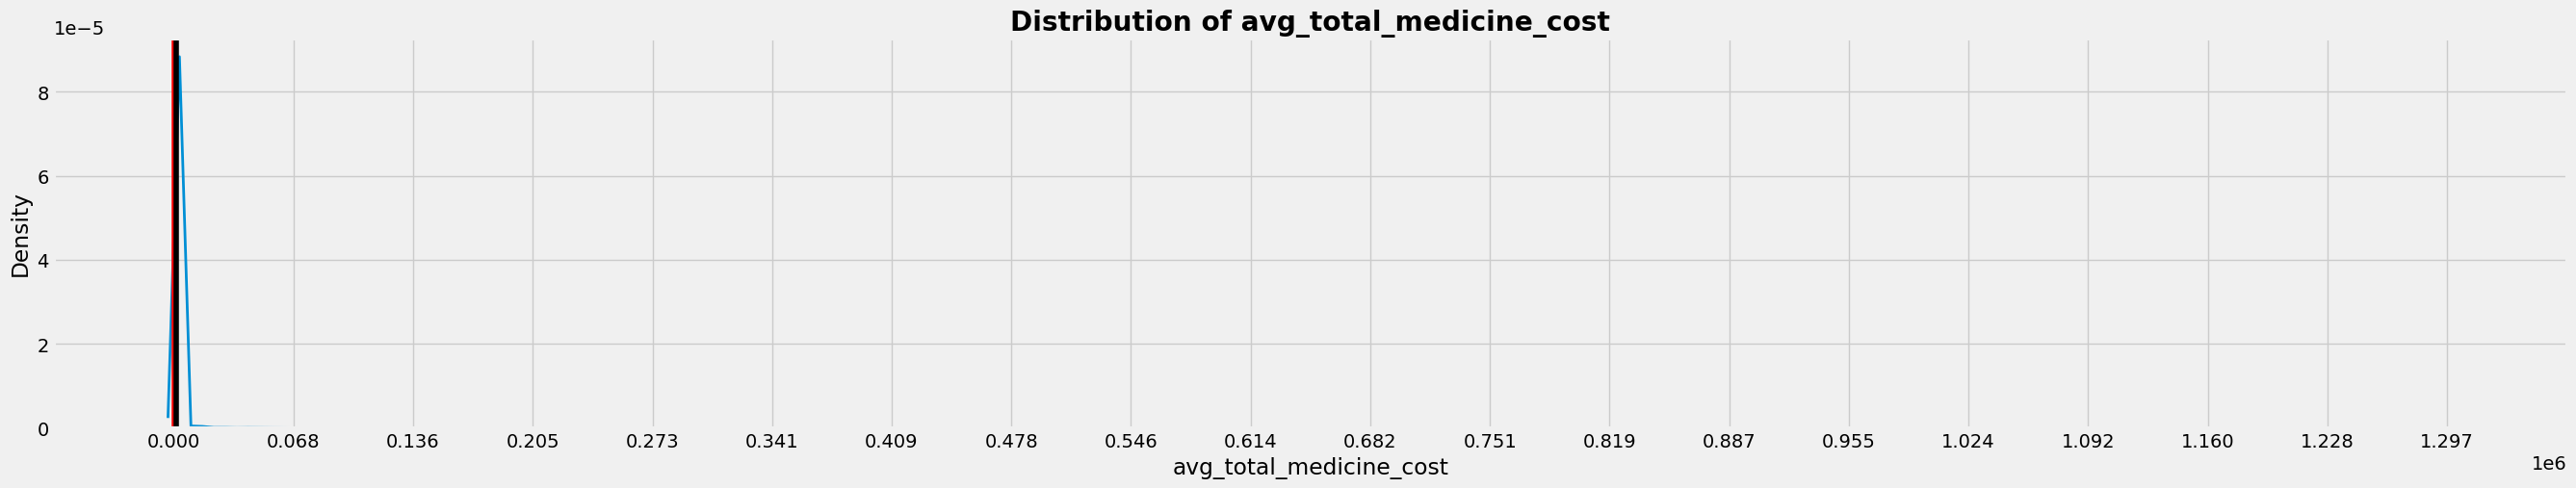

In [44]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'avg_total_medicine_cost',data= data,line_val=.50)
plt.axvline(data['avg_total_medicine_cost'].mean(),color = 'black')
plt.show()

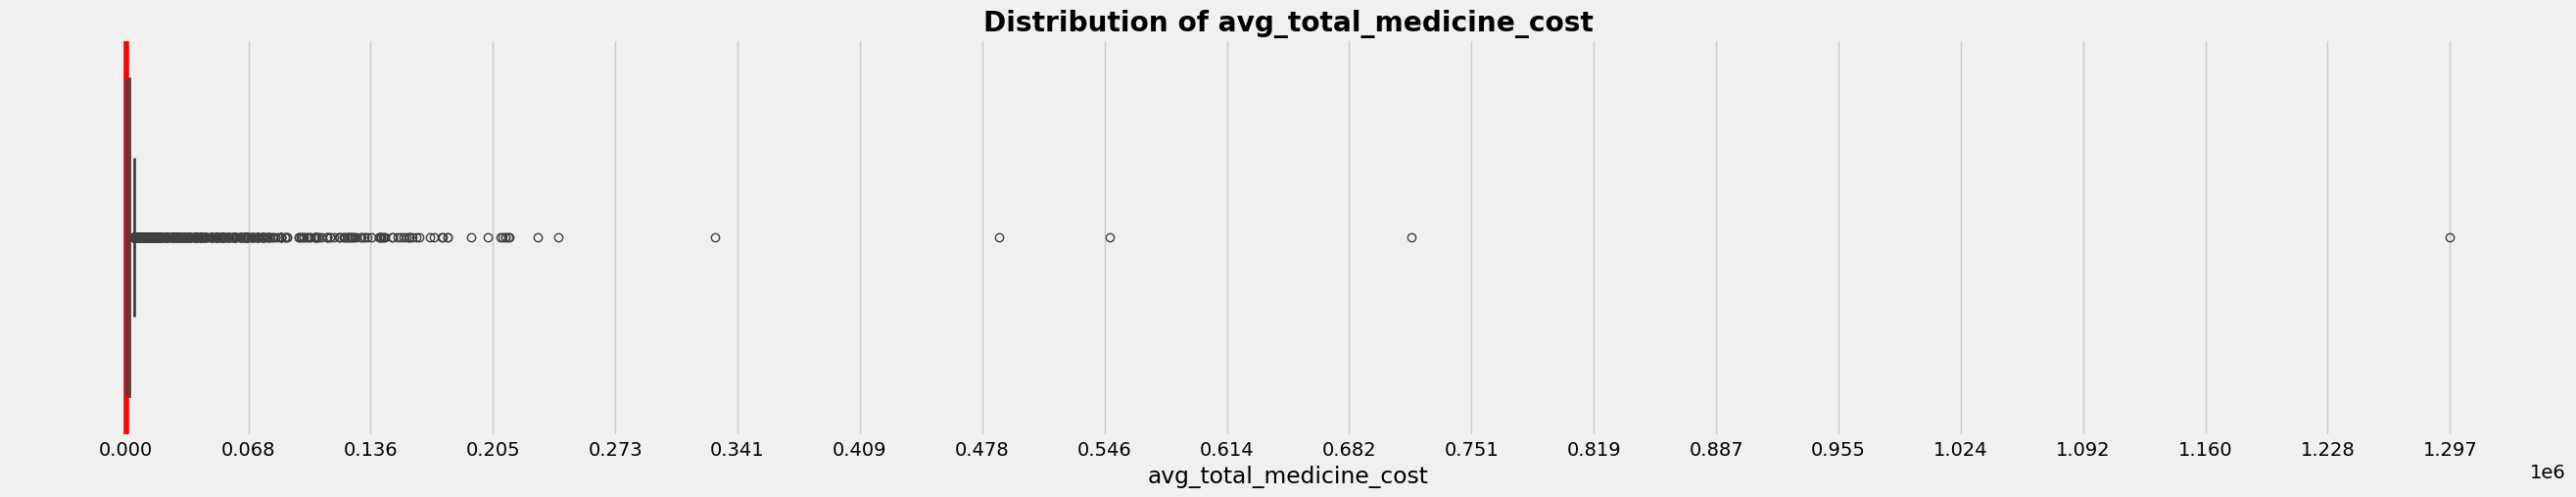

In [45]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'avg_total_medicine_cost',data= data,line_val=.50)
plt.show()

- **There are some extreme outliers**

**reasons_for_medications**

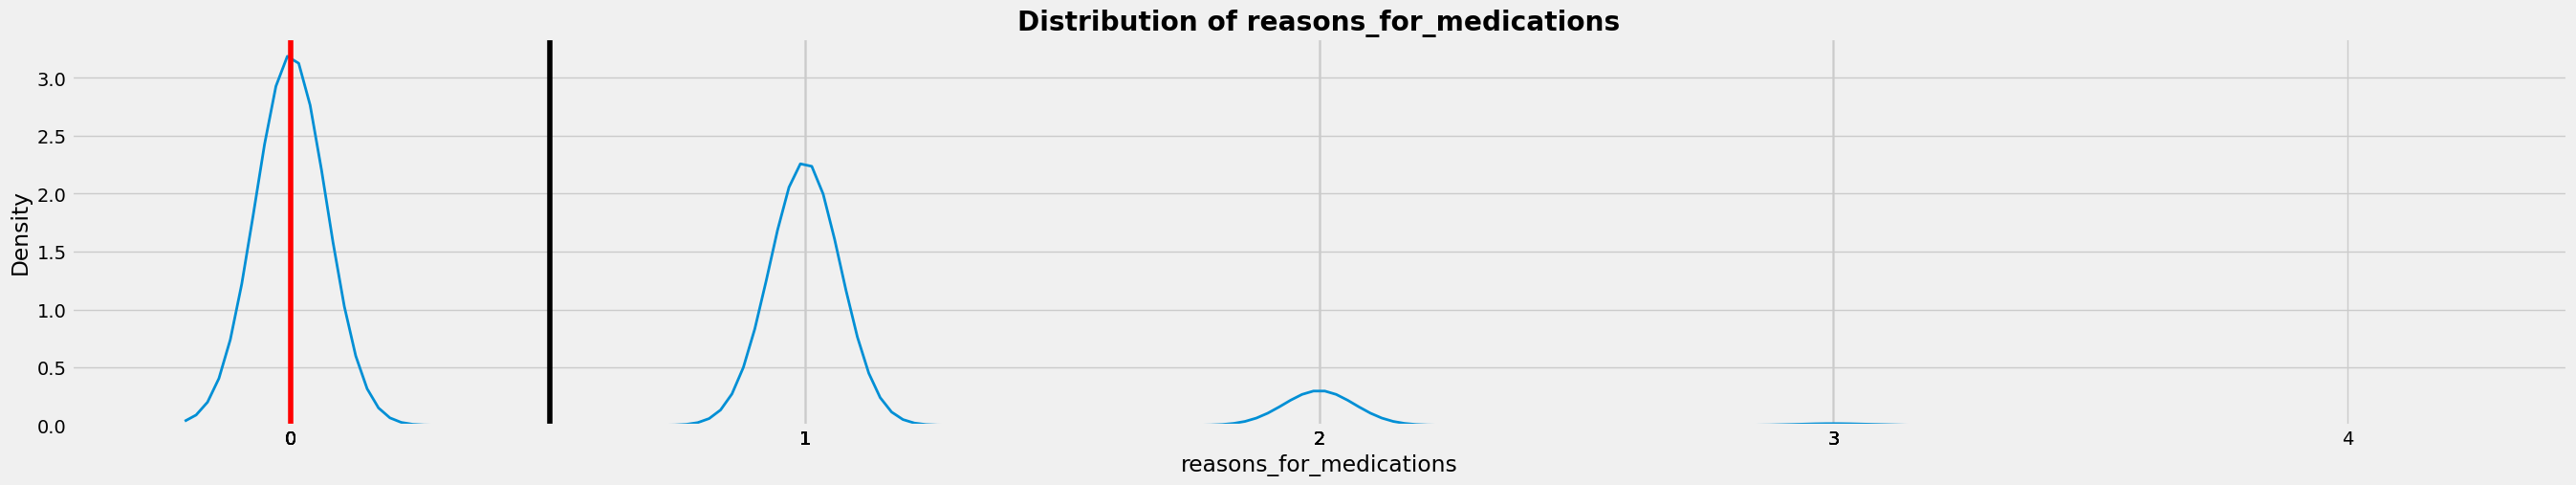

In [46]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'reasons_for_medications',data= data,line_val=.50)
plt.axvline(data['reasons_for_medications'].mean(),color = 'black')
plt.show()

In [47]:
data.groupby('reasons_for_medications').size()

reasons_for_medications
0    29485
1    20967
2     2758
3      135
4        1
dtype: int64

In [48]:
data['reasons_for_medications']=data['reasons_for_medications'].apply(lambda x: '2+' if (x>2)  else str(x))

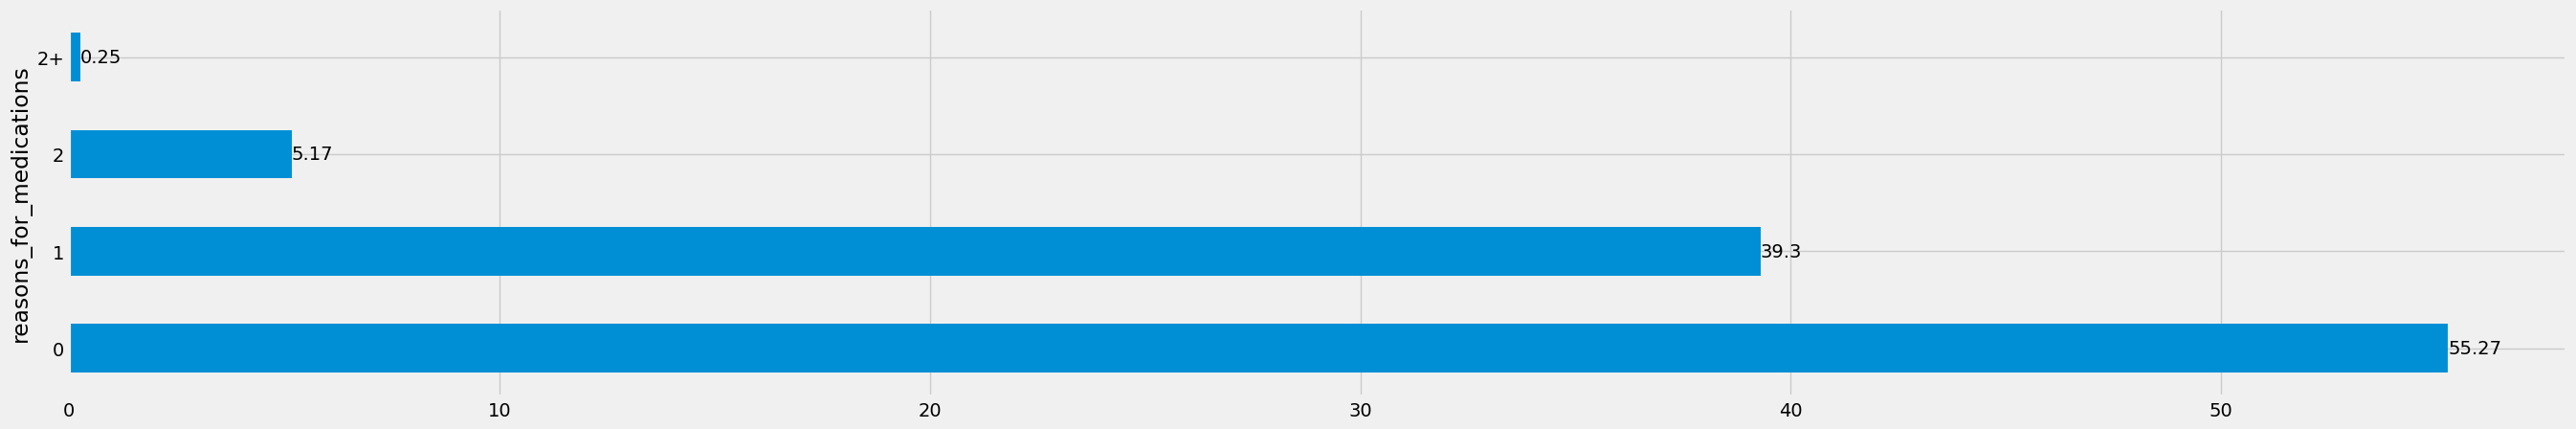

In [49]:
plt.figure(figsize=(30,5))
ax = data.groupby('reasons_for_medications').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

- **for almost half of the observation have 0 medications reason**

**is_ongoing_condition**

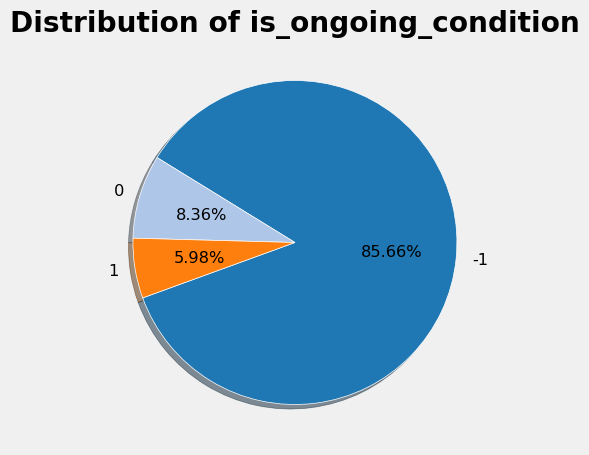

In [50]:
plt.figure(figsize=(5,5))
P.plot_pie(column='is_ongoing_condition',data = data)
plt.show()

In [51]:
data['is_ongoing_condition']=np.where(data['is_ongoing_condition'] == 1, 'YES',np.where(data['is_ongoing_condition']== 0,'FINISHED','NOTHING'))

***
- **`is_ongoing_condition` have `nothing` as most frequent values, and `ongoing` have the least value**
***

**total_conditions**

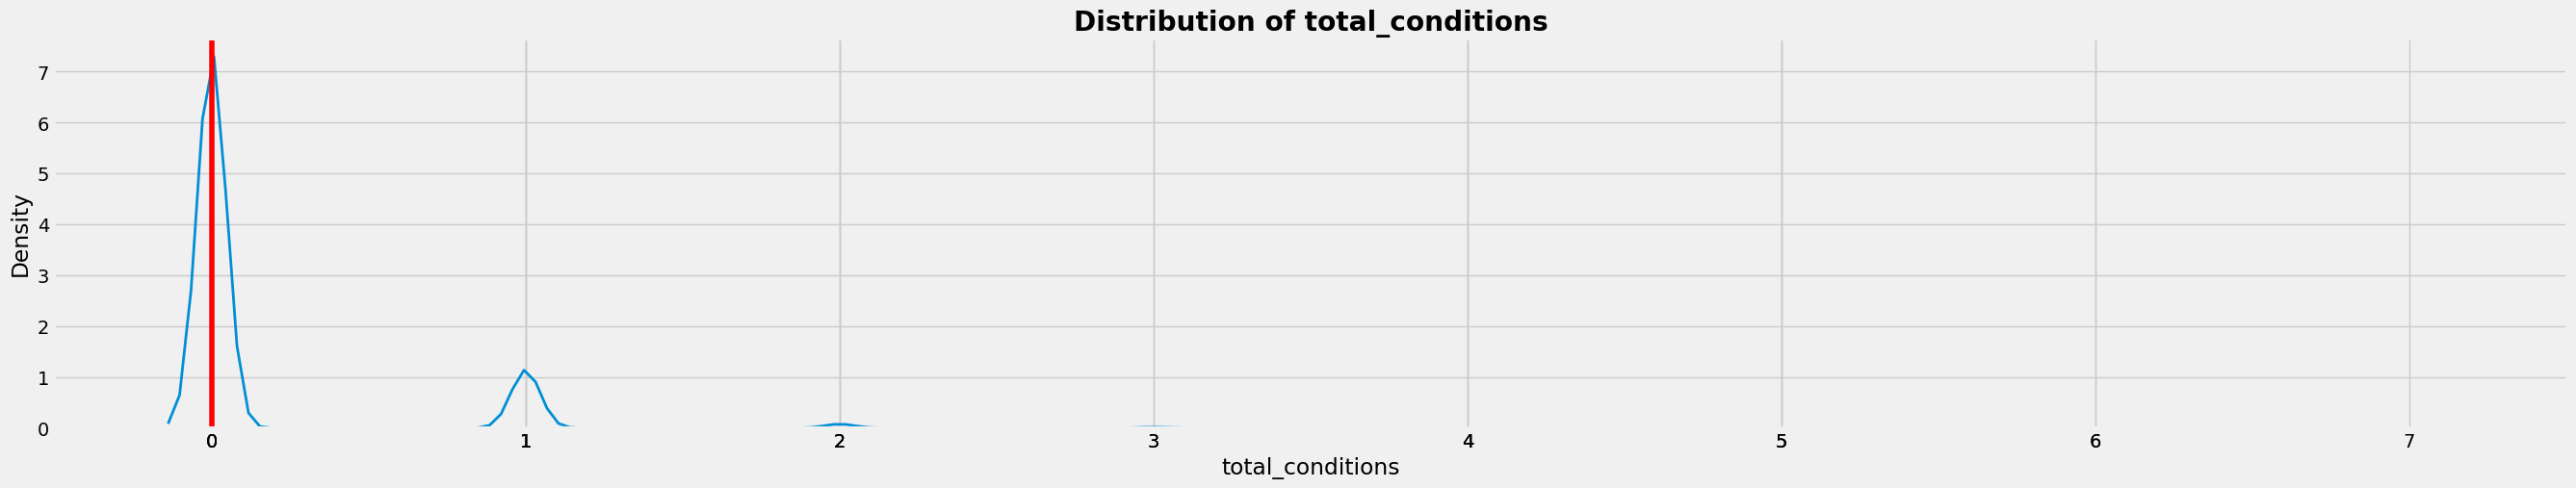

In [52]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_conditions',data= data,line_val=.50)
plt.show()

In [53]:
data.groupby('total_conditions').size()

total_conditions
0    45696
1     7066
2      468
3       96
4       16
5        3
7        1
dtype: int64

In [54]:
data['total_conditions']=data['total_conditions'].apply(lambda x: '1+' if (x>1)  else str(x))

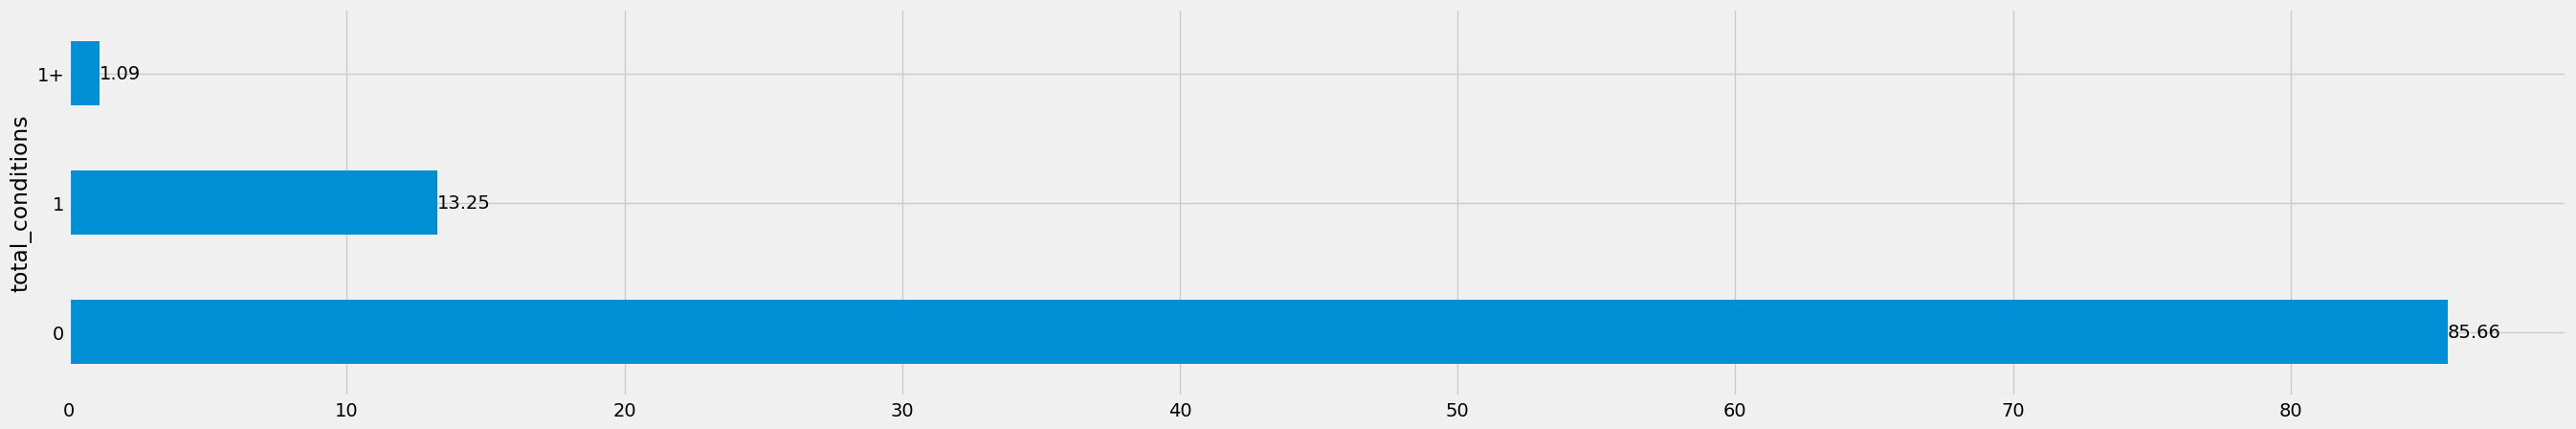

In [55]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_conditions').size().div(len(data)).mul(100).round(2).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

***
- **in about `85%` of `observations` have `total conditions` as `0`**
***

**is_ongoing_careplan**

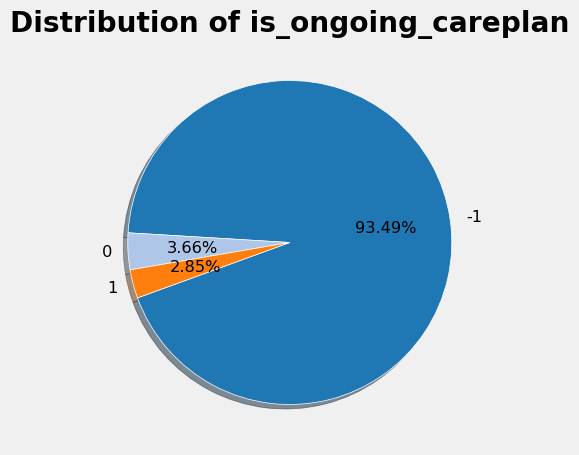

In [56]:
plt.figure(figsize=(5,5))
P.plot_pie(column='is_ongoing_careplan',data = data)
plt.show()

In [57]:
data['is_ongoing_careplan']=np.where(data['is_ongoing_careplan'] == 1, 'YES',np.where(data['is_ongoing_careplan']== 0,'FINISHED','NOTHING'))

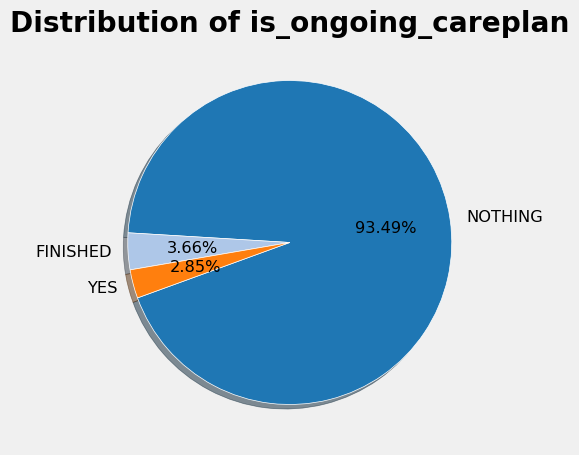

In [58]:
plt.figure(figsize=(5,5))
P.plot_pie(column='is_ongoing_careplan',data = data)
plt.show()

- **more than 90% of observations have nothing value**

**total_careplans**

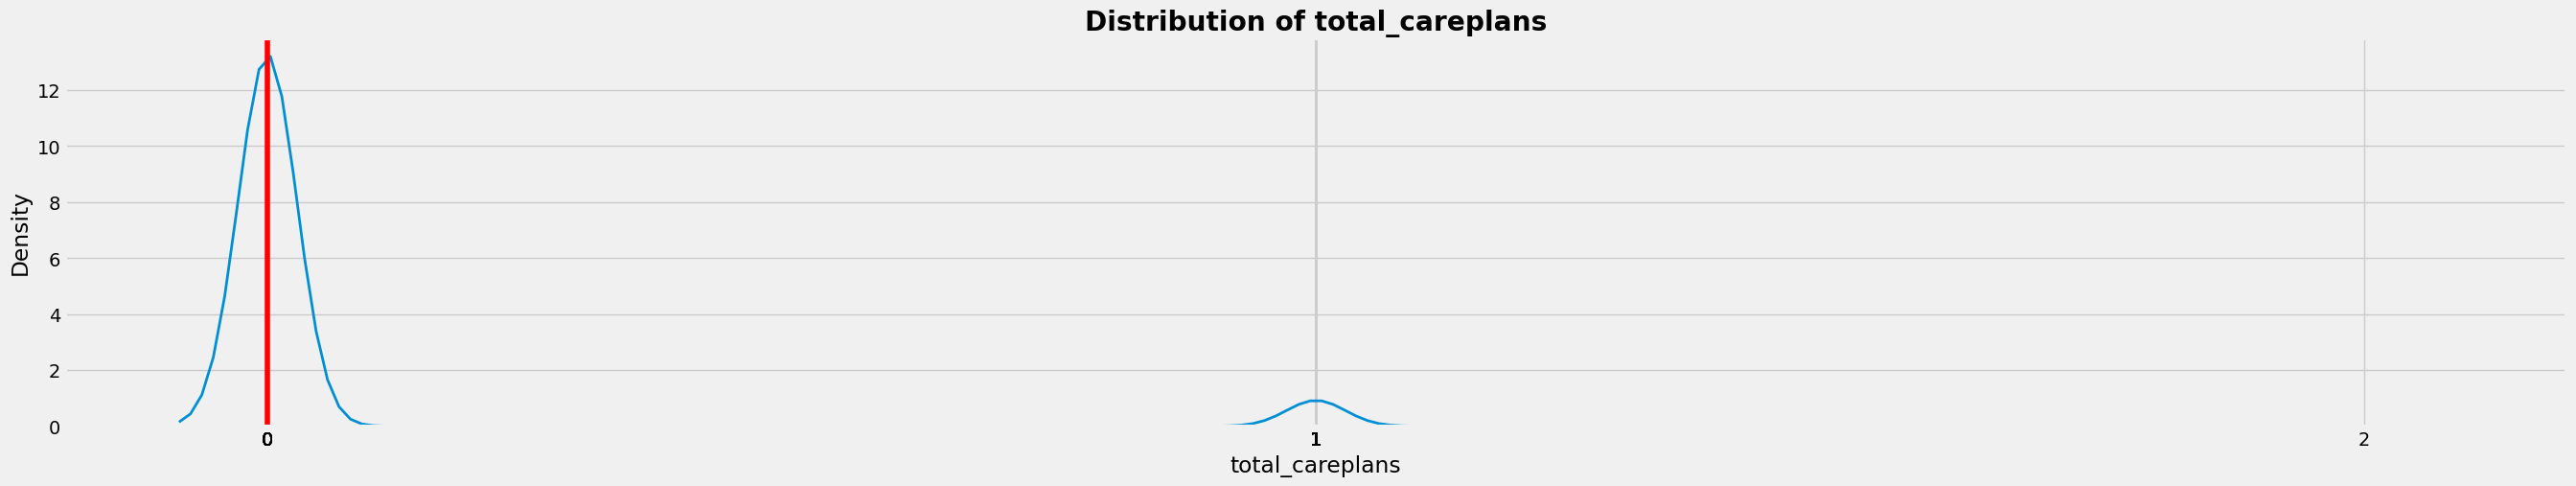

In [59]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'total_careplans',data= data,line_val=.50)
plt.show()

In [60]:
data.groupby('total_careplans').size()

total_careplans
0    49874
1     3461
2       11
dtype: int64

In [61]:
data['total_careplans']=data['total_careplans'].astype('object')

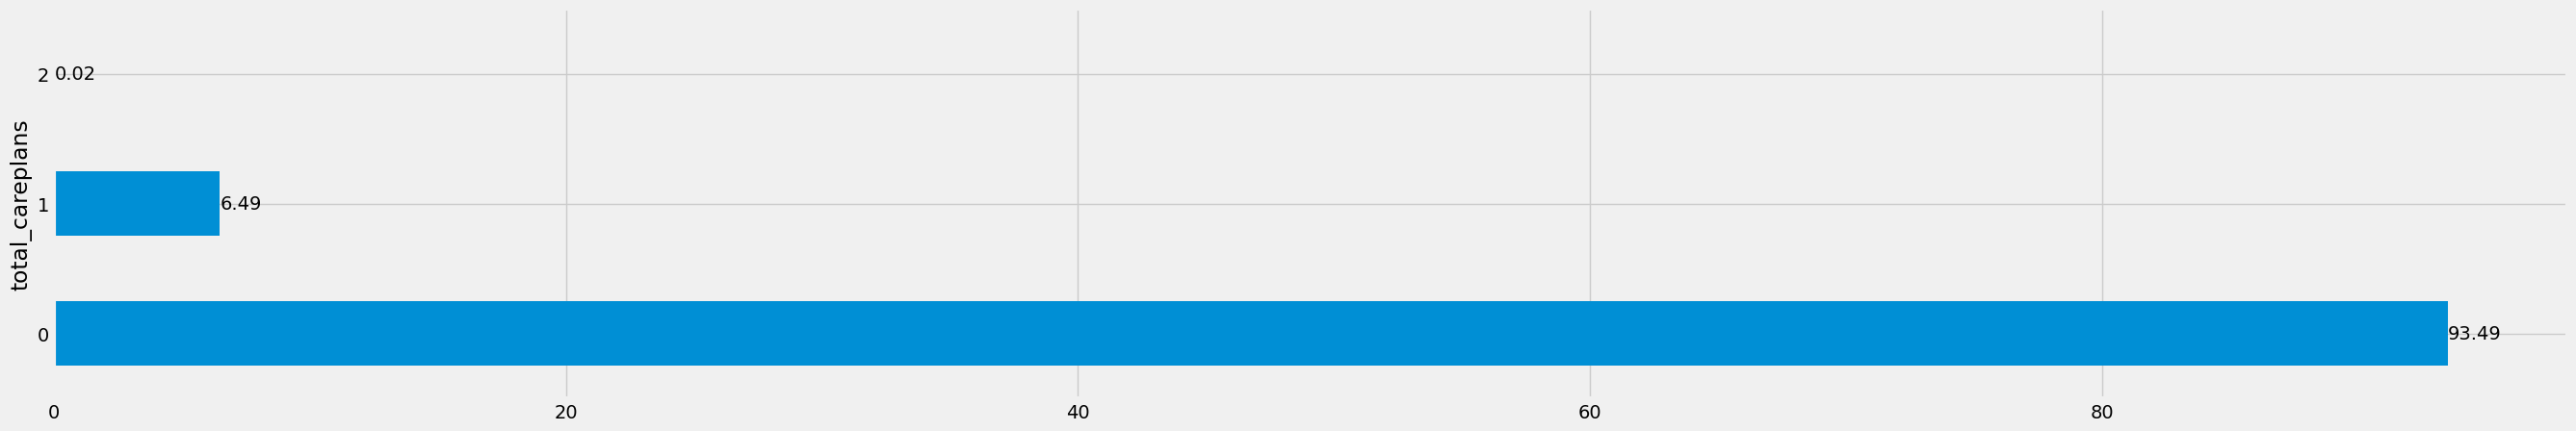

In [62]:
plt.figure(figsize=(30,5))
ax = data.groupby('total_careplans').size().div(len(data)).mul(100).round(2).sort_values(ascending=False).plot(kind = 'barh')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

**age_as_2022**

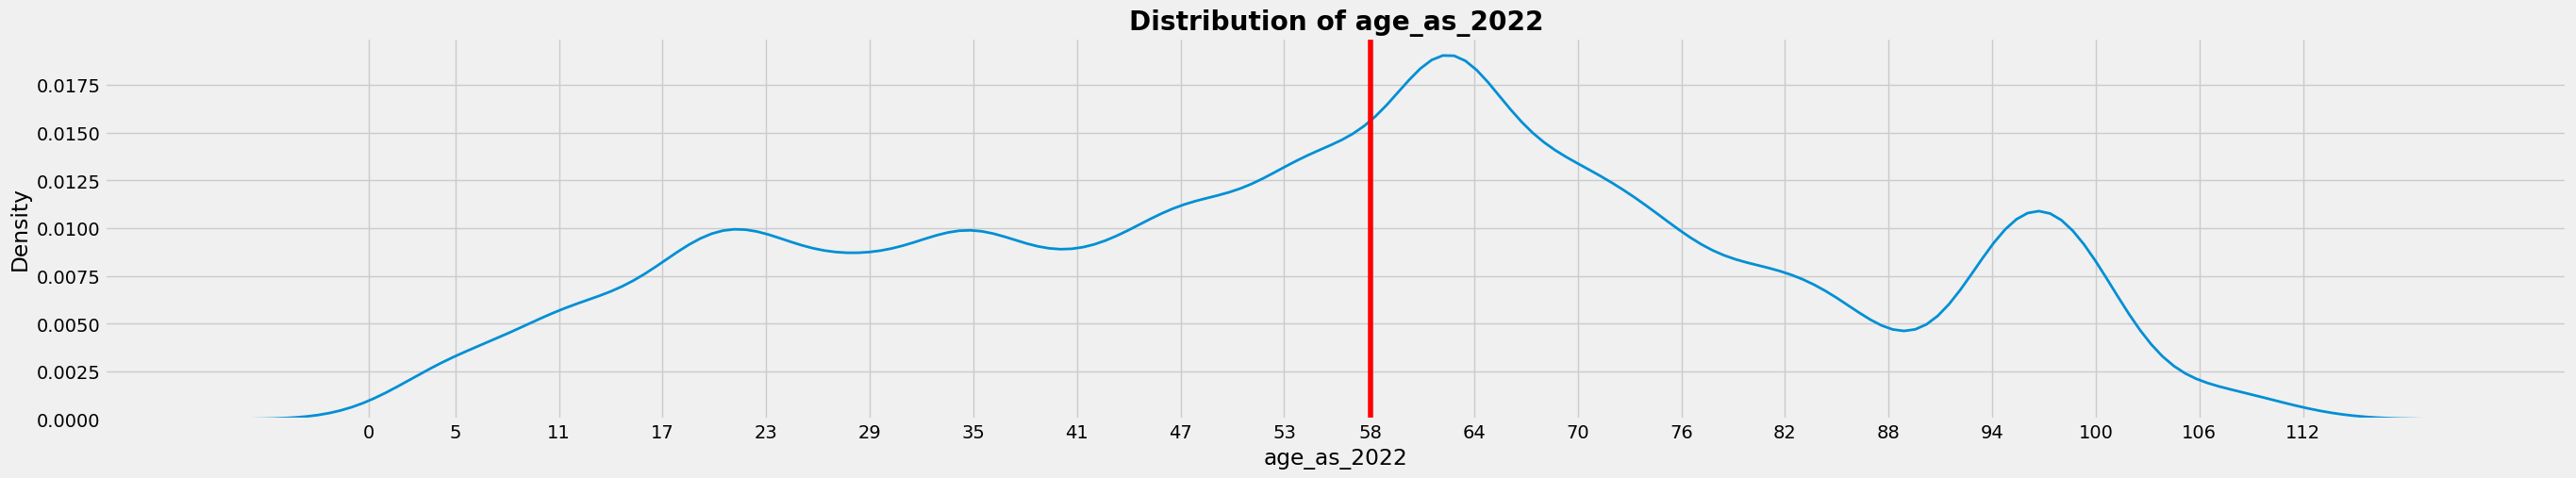

In [63]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'age_as_2022',data= data,line_val=.50)
plt.show()

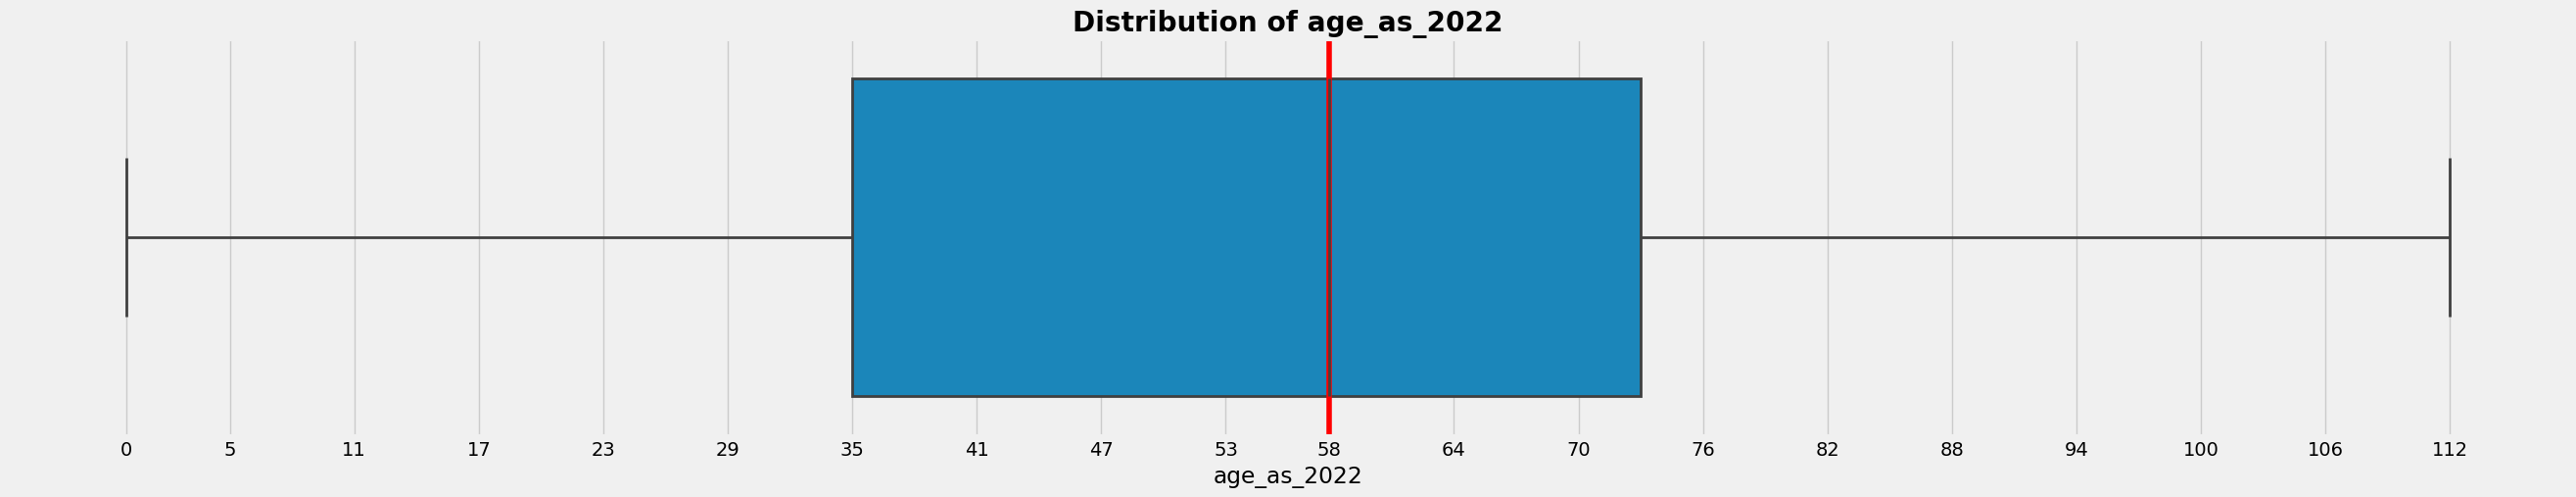

In [64]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'age_as_2022',data= data,line_val=.50)
plt.show()

- **age column do not have outliers, and there is a small peak at around 100**

**marital**

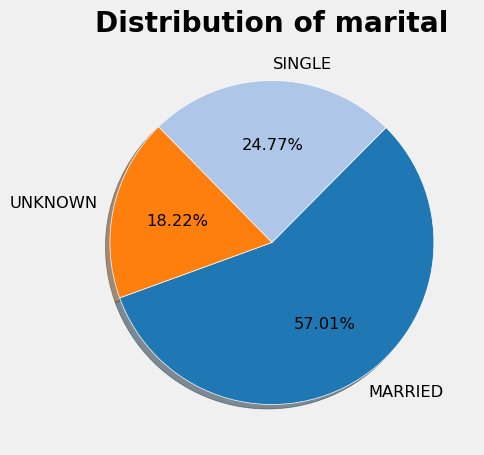

In [65]:
plt.figure(figsize=(5,5))
P.plot_pie(column='marital',data = data)
plt.show()

- **more than 50% of observations have value as married**

**race**

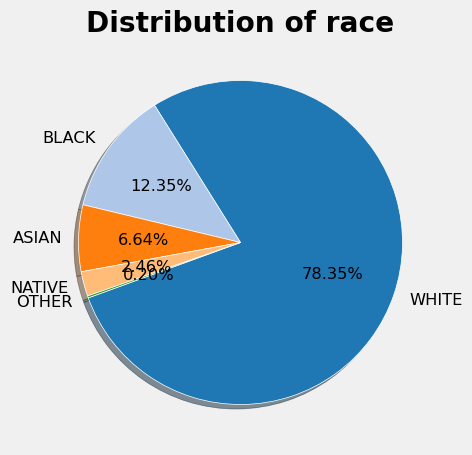

In [66]:
plt.figure(figsize=(5,5))
P.plot_pie(column='race',data = data)
plt.show()

- **approx 79% of observations are from white race**

**ethnicity**

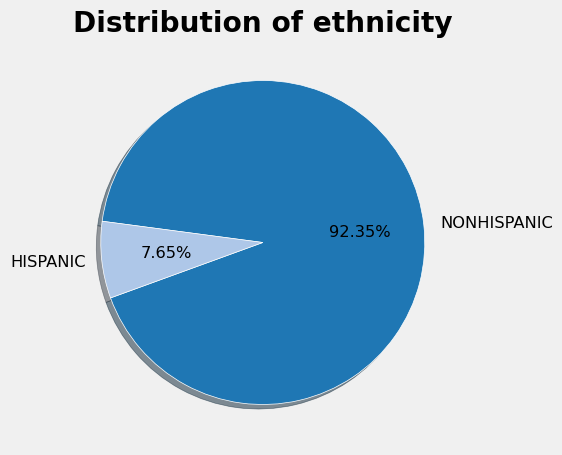

In [67]:
plt.figure(figsize=(5,5))
P.plot_pie(column='ethnicity',data = data)
plt.show()

- **more than 90% of observations are from non hispanic ethnicity**

**patient_gender**

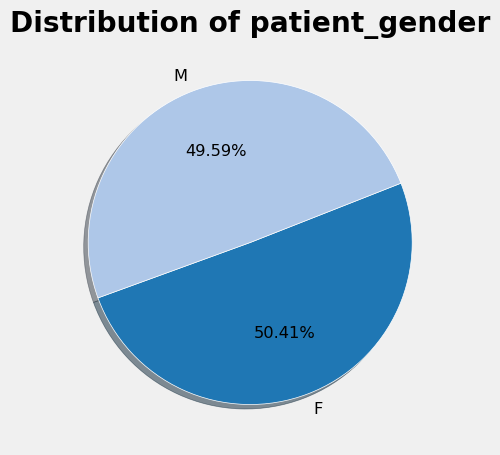

In [68]:
plt.figure(figsize=(5,5))
P.plot_pie(column='patient_gender',data = data)
plt.show()

- **patient gender is almost equally distributed**

**provider_gender**

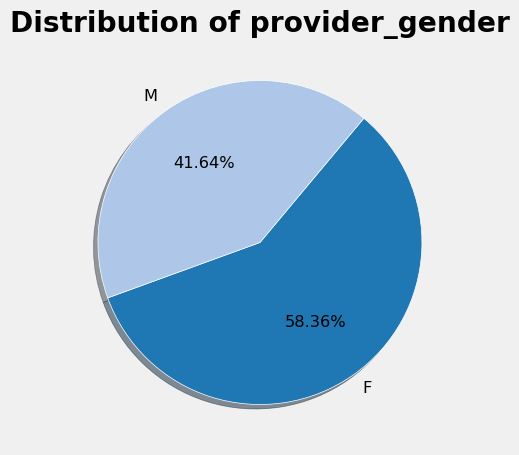

In [69]:
plt.figure(figsize=(5,5))
P.plot_pie(column='provider_gender',data = data)
plt.show()

- **more female provider gender compared to male gender**

**utilization**

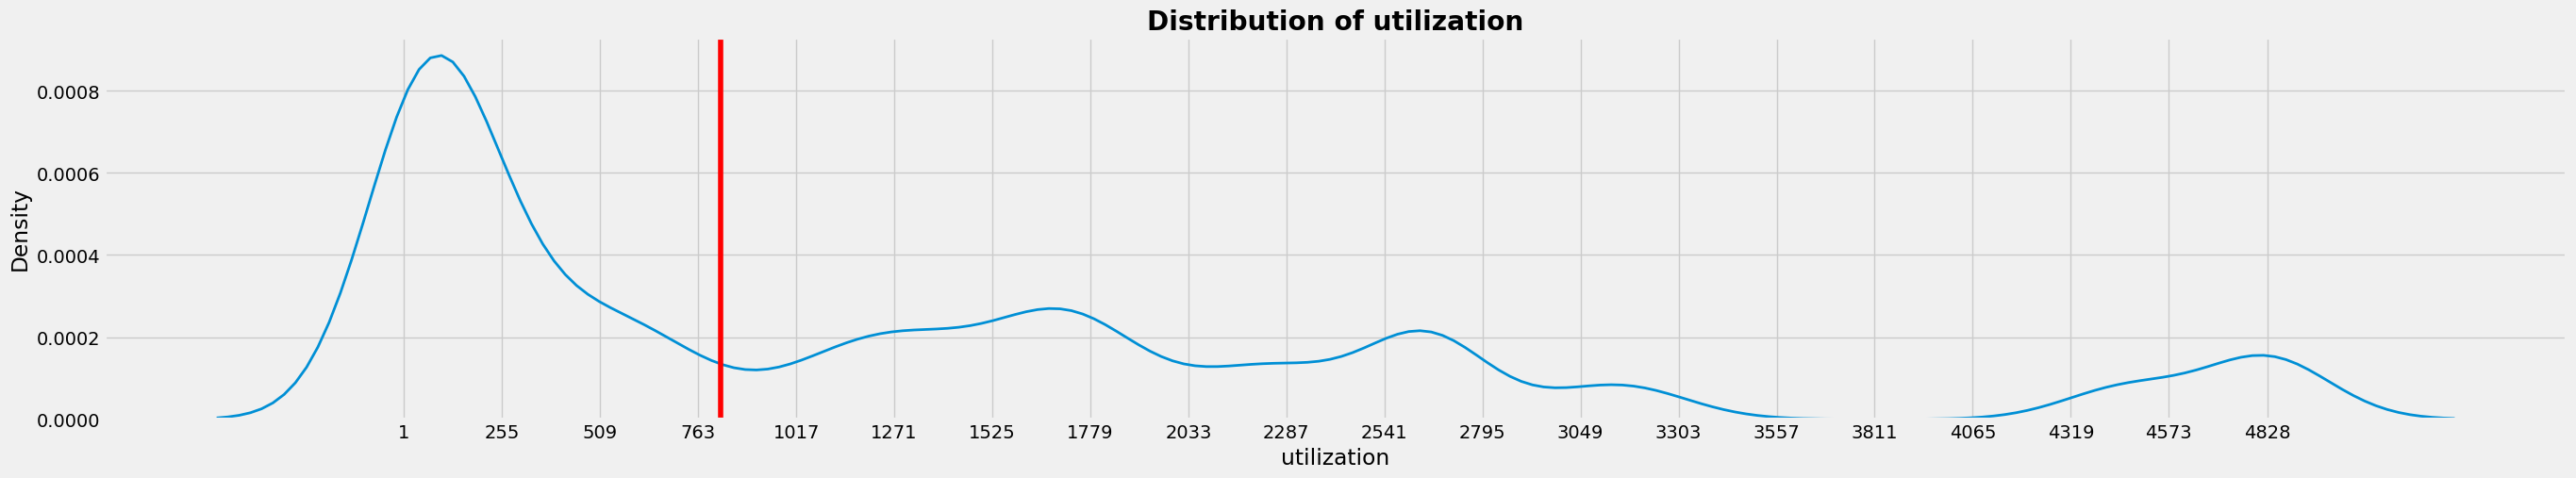

In [70]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'utilization',data= data,line_val=.50)
plt.show()

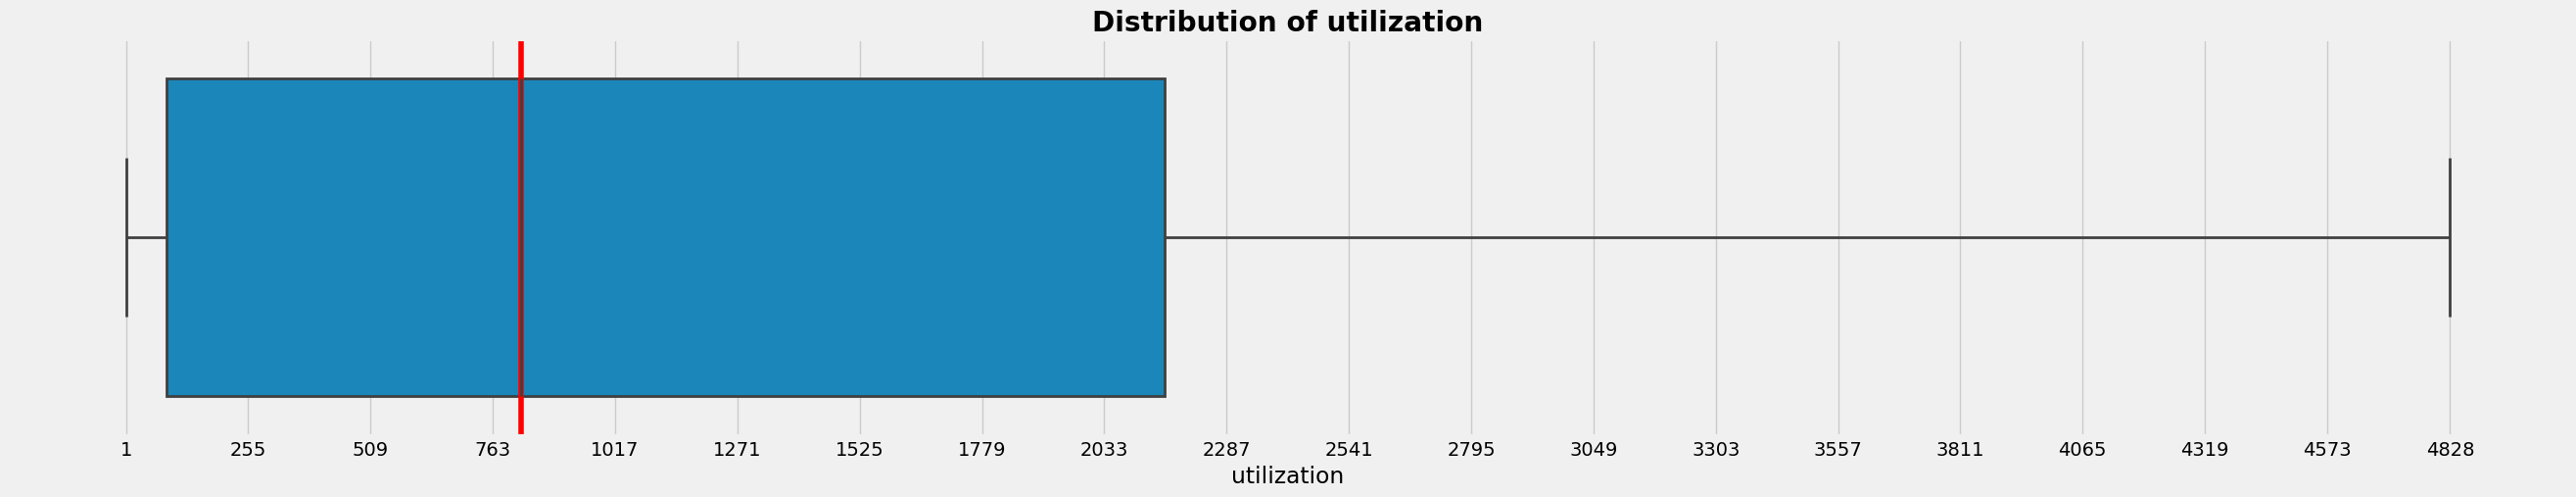

In [71]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'utilization',data= data,line_val=.50)
plt.show()

- **utilization column do not have outlier, but values are more around the lower end**

**caused_readmission**

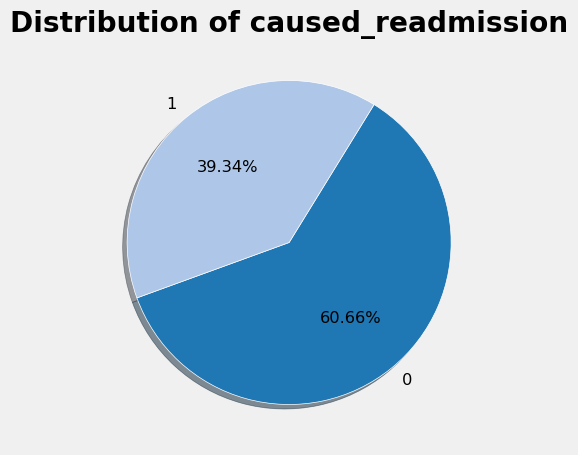

In [72]:
plt.figure(figsize=(5,5))
P.plot_pie(column='caused_readmission',data = data)
plt.show()

***
- **`almost` `40%` of encounter are reason for `readmissions`**
***

**condition_duration**

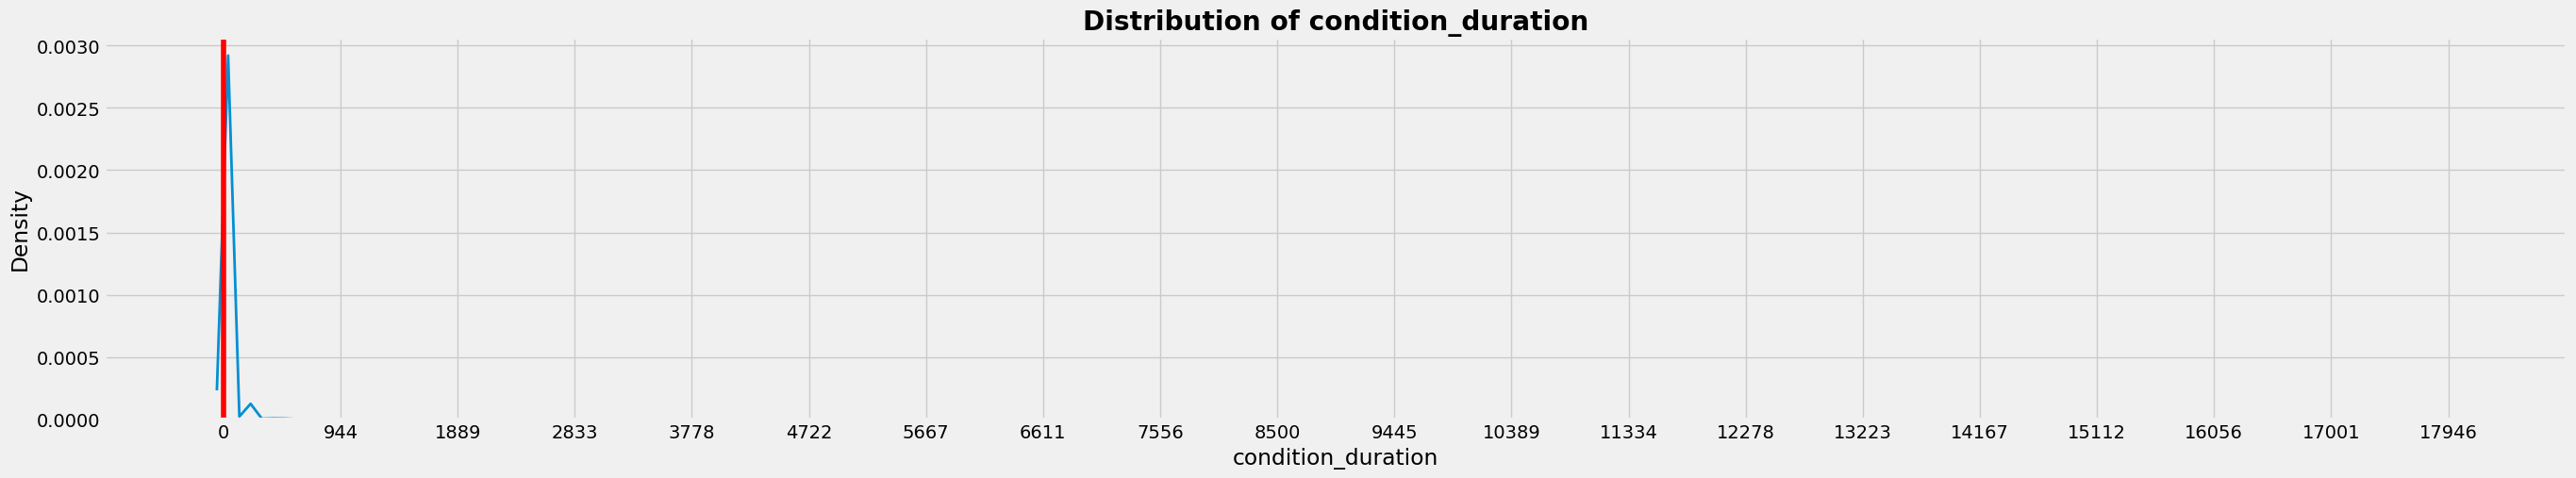

In [73]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'condition_duration',data= data,line_val=.50)
plt.show()

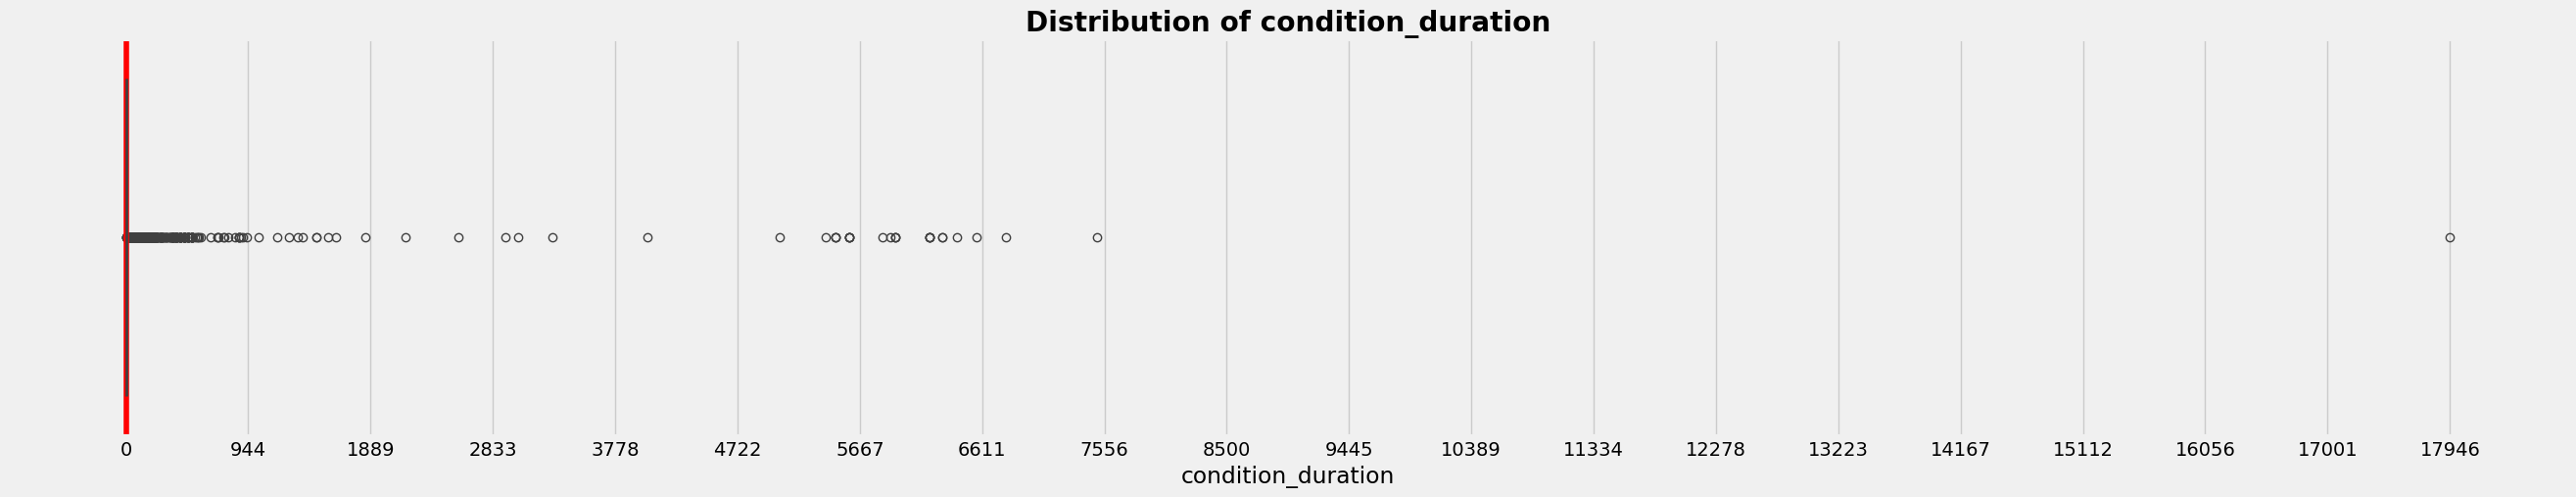

In [74]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'condition_duration',data= data,line_val=.50)
plt.show()

- **too many outiers**

**careplan_duration**

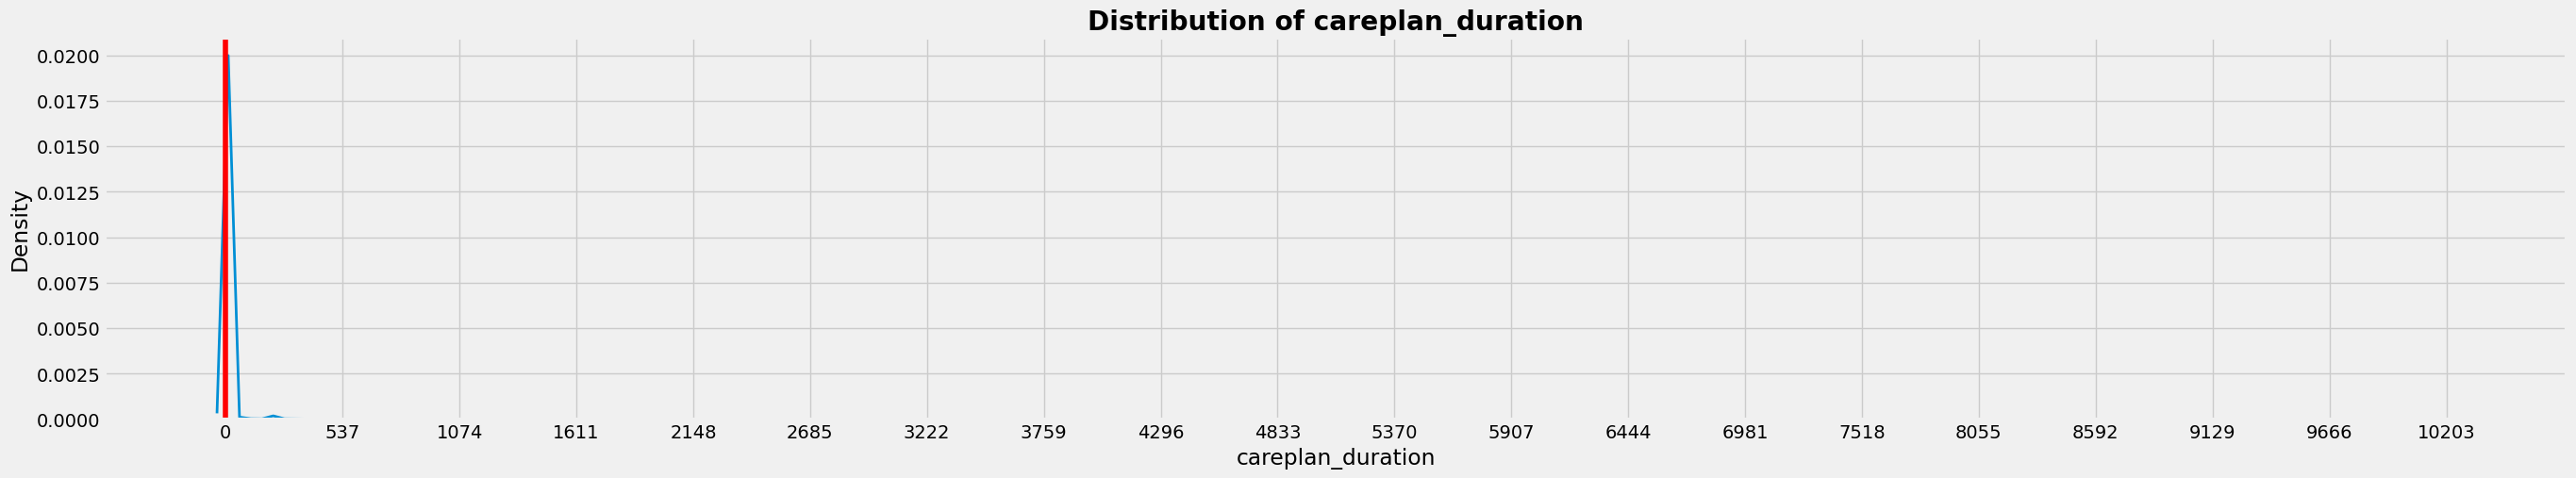

In [75]:
plt.figure(figsize=(30,5))
P.plot_kde(column= 'careplan_duration',data= data,line_val=.50)
plt.show()

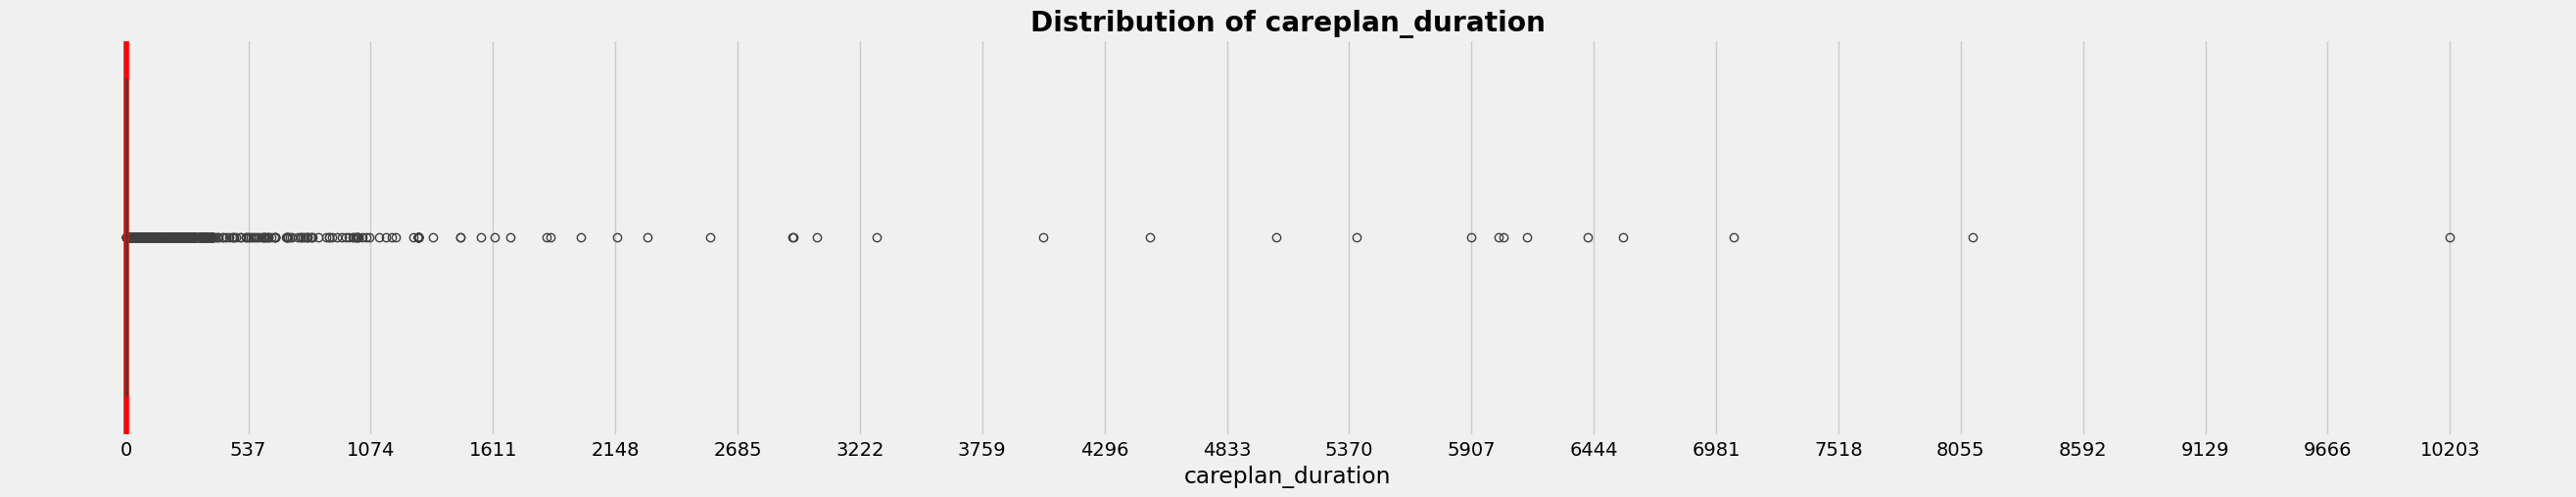

In [76]:
plt.figure(figsize=(30,5))
P.plot_box(column= 'careplan_duration',data= data,line_val=.50)
plt.show()

- **many outliers too**

In [77]:
data.select_dtypes(include='number').nunique().reset_index(name = 'total_unique_values')

index  total_unique_values
0           payer_coverage                   15
1       avg_procedure_cost                15909
2   avg_base_medicine_cost                11010
3  avg_total_medicine_cost                11986
4              age_as_2022                  108
5              utilization                  220
6       caused_readmission                    2
7       condition_duration                  222
8        careplan_duration                  357

In [78]:
data.select_dtypes(include='object').nunique().reset_index(name = 'total_unique_values')

index  total_unique_values
0           encounter_start                50029
1            encounterclass                    6
2       base_encounter_cost                    2
3                  duration                    4
4          total_procedures                    7
5           total_medicines                    7
6   reasons_for_medications                    4
7      is_ongoing_condition                    3
8          total_conditions                    3
9       is_ongoing_careplan                    3
10          total_careplans                    3
11                  marital                    3
12                     race                    5
13                ethnicity                    2
14           patient_gender                    2
15          provider_gender                    2

In [79]:
data.select_dtypes(include='number').nunique().reset_index(name = 'total_unique_values')['index'].values.tolist()

['payer_coverage',
 'avg_procedure_cost',
 'avg_base_medicine_cost',
 'avg_total_medicine_cost',
 'age_as_2022',
 'utilization',
 'caused_readmission',
 'condition_duration',
 'careplan_duration']

In [80]:
cat_cols = ['encounterclass','base_encounter_cost','duration','total_procedures','total_medicines','reasons_for_medications','is_ongoing_condition',
 'total_conditions','is_ongoing_careplan','total_careplans','marital','race','ethnicity','patient_gender','provider_gender']

In [81]:
num_cols = ['payer_coverage','avg_procedure_cost','avg_base_medicine_cost','avg_total_medicine_cost','age_as_2022',
 'utilization','condition_duration','careplan_duration']

In [82]:
target_col = ['caused_readmission']

***

## **Bivariate Analysis with `caused_readmission` column**

### **Categorical Columns with Target**

**encounterclass**

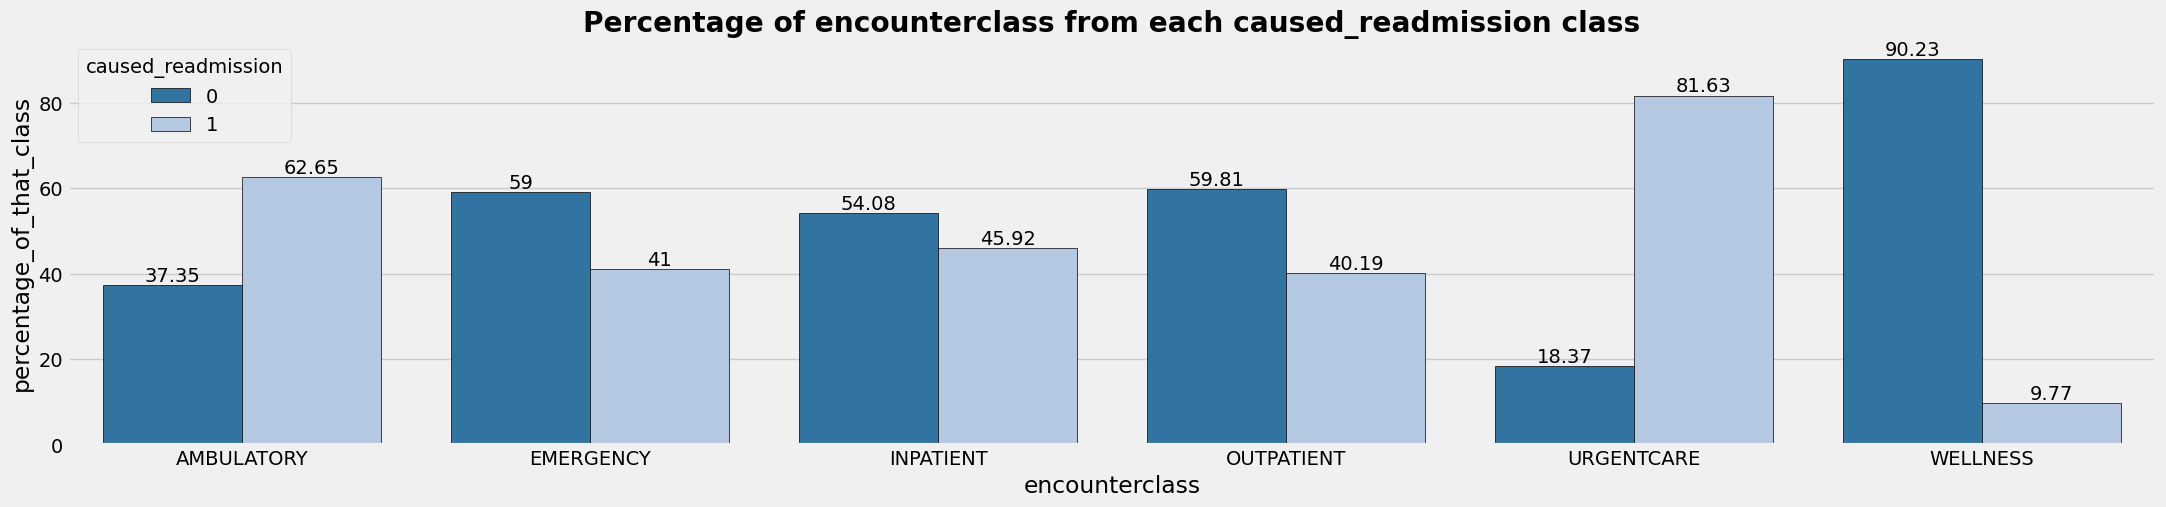

In [83]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='encounterclass',data=data,target='caused_readmission',orient='v')

In [84]:
urgent_care_mask = (data['encounterclass']=='URGENTCARE') | (data['encounterclass']=='AMBULATORY')
ct = pd.crosstab(urgent_care_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.424 → Strong


***
- ***according to the visuals, `ambulatory and urgentcare encounters showed the most observations for caused readmission`, after doing statistical test we can validate a `strong relationship` between `encounterclass` and `causing readmission`***
***

**duration**

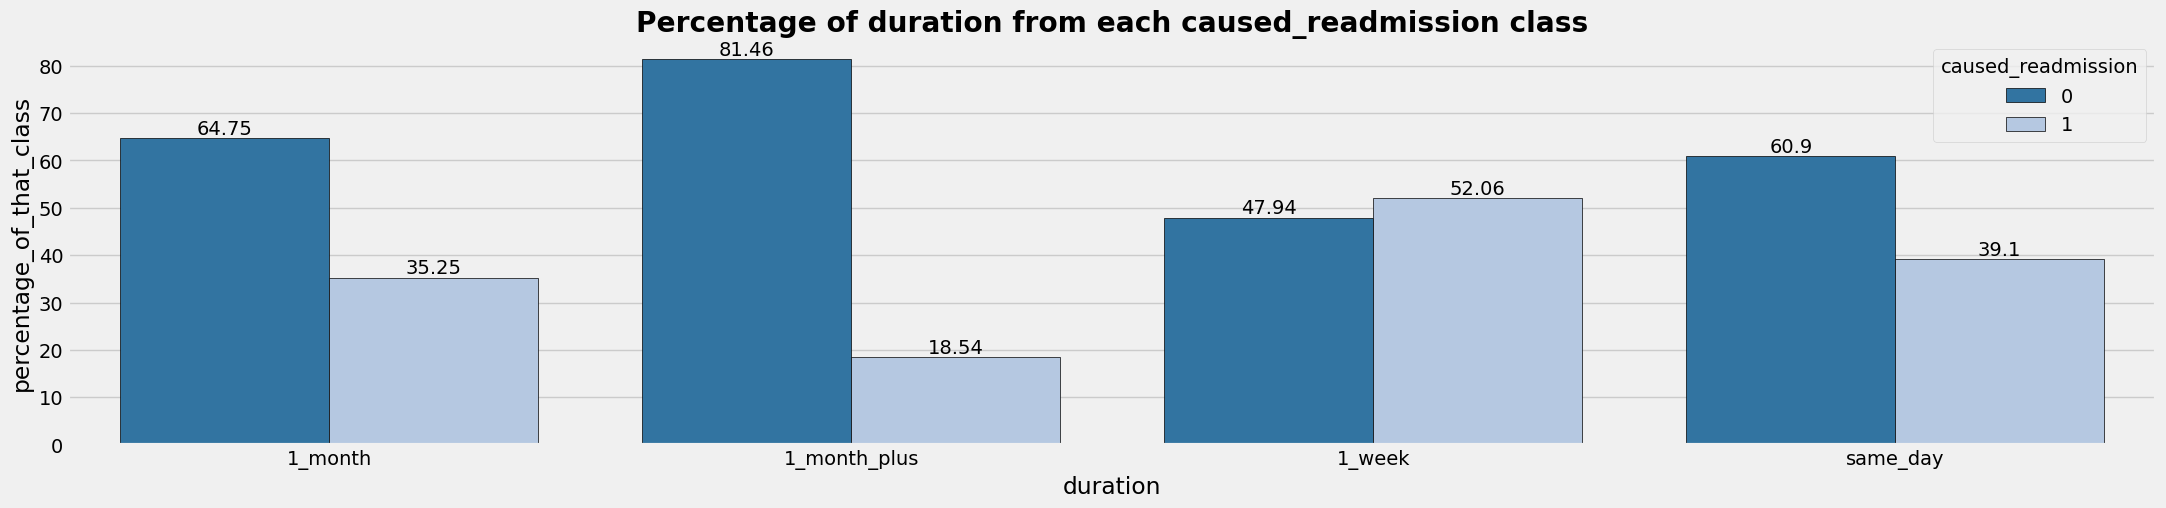

In [85]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='duration',data=data,target='caused_readmission',orient='v')

**Need to do a statistical test to check if there is any association for `1_week` class for causing readmission**

In [86]:
duration_mask = (data['duration']=='1_week')
ct = pd.crosstab(duration_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.041 → Weak


***
***By visuals I saw that `1_week duration is showing high number in causing readmission`, after doing statistical test we can validate a `weak relationship` between `duration of 1_week` and `cause_readmission` column***
***

**marital**

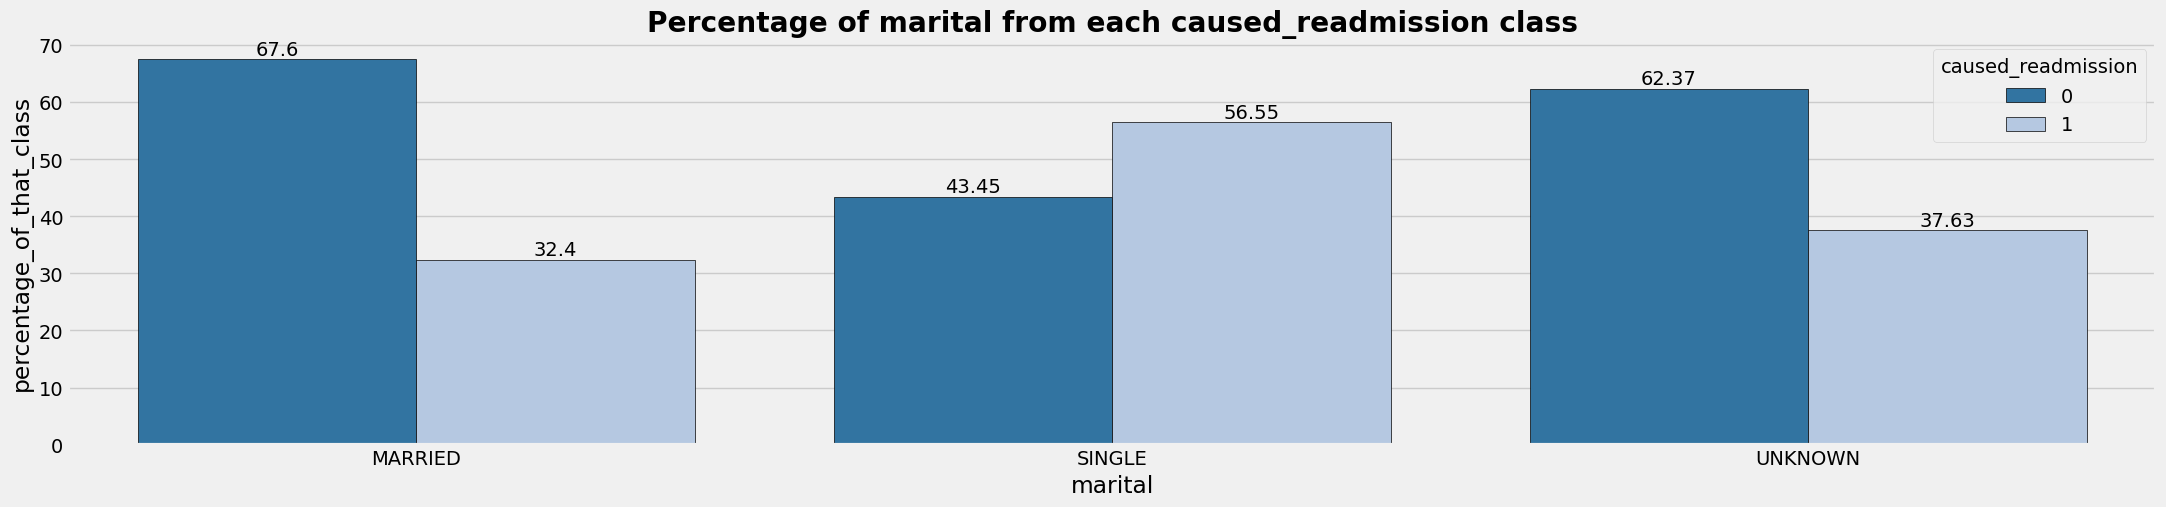

In [87]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='marital',data=data,target='caused_readmission',orient='v')

In [88]:
marital_mask = (data['marital']=='SINGLE')
ct = pd.crosstab(marital_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.202 → Moderate


***
- ***visuals showed that there is a `high percentage of causing readmission in single marital status`, by doing statistical test we can validate that `cause_readmission` column have `moderate relationship` with `marital class single`***
***

**ethnicity**

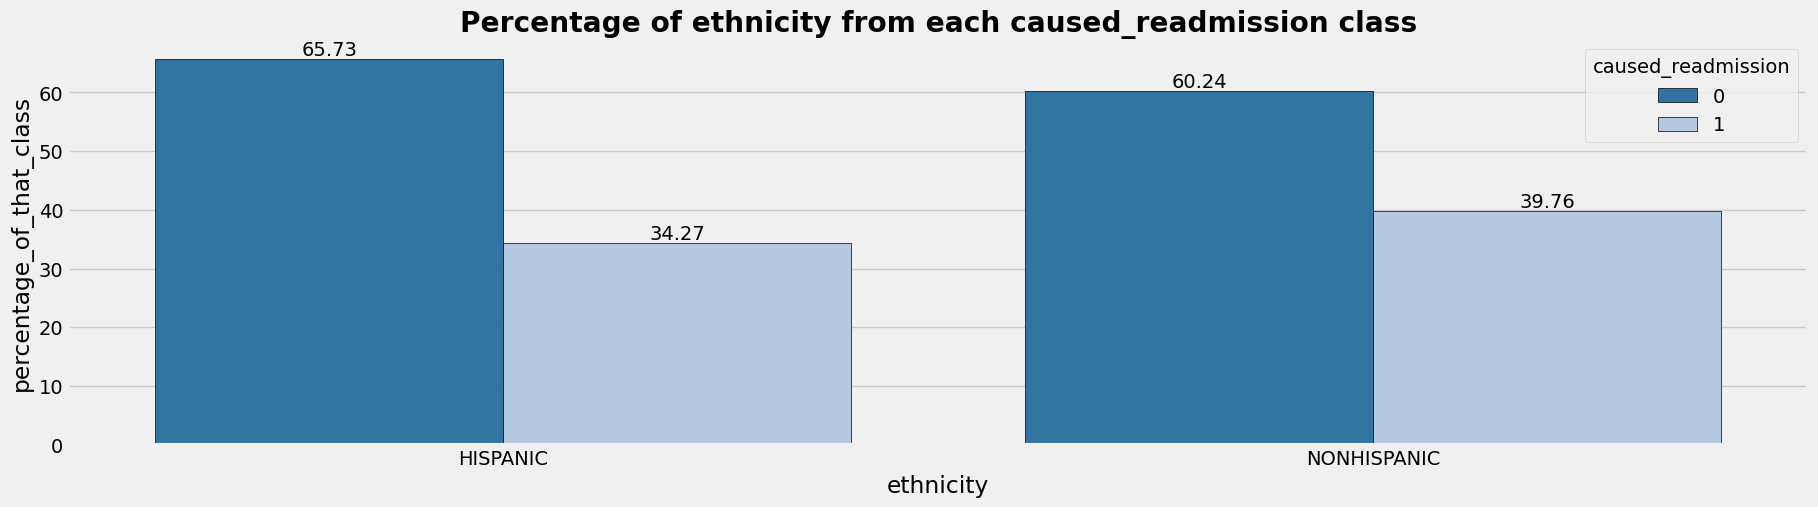

In [89]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='ethnicity',data=data,target='caused_readmission',orient='v')

- **we do not see any strong pattern in between ethnicity and caused readmission**

**race**

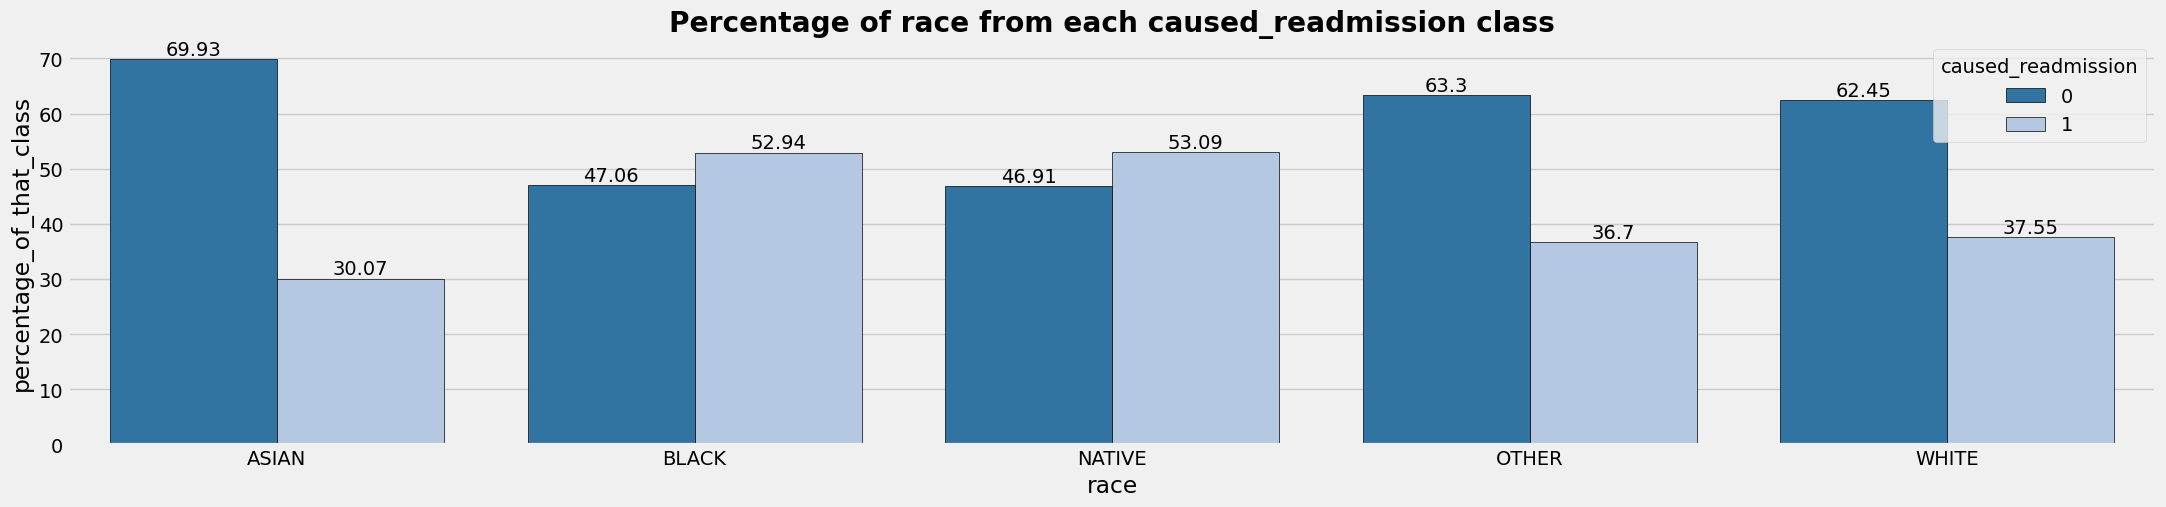

In [90]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='race',data=data,target='caused_readmission',orient='v')

In [91]:
race_mask = (data['race']=='BLACK') |(data['race']=='NATIVE')
ct = pd.crosstab(race_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.116 → Moderate


***
- ***by visuals we saw that `black and native race is showing high percentage of values in cause readmission class`, after doing statistical test we can validate that `cause_readmission` column have a `moderate relationship` with `black` and `native` race***
***

**patient_gender**

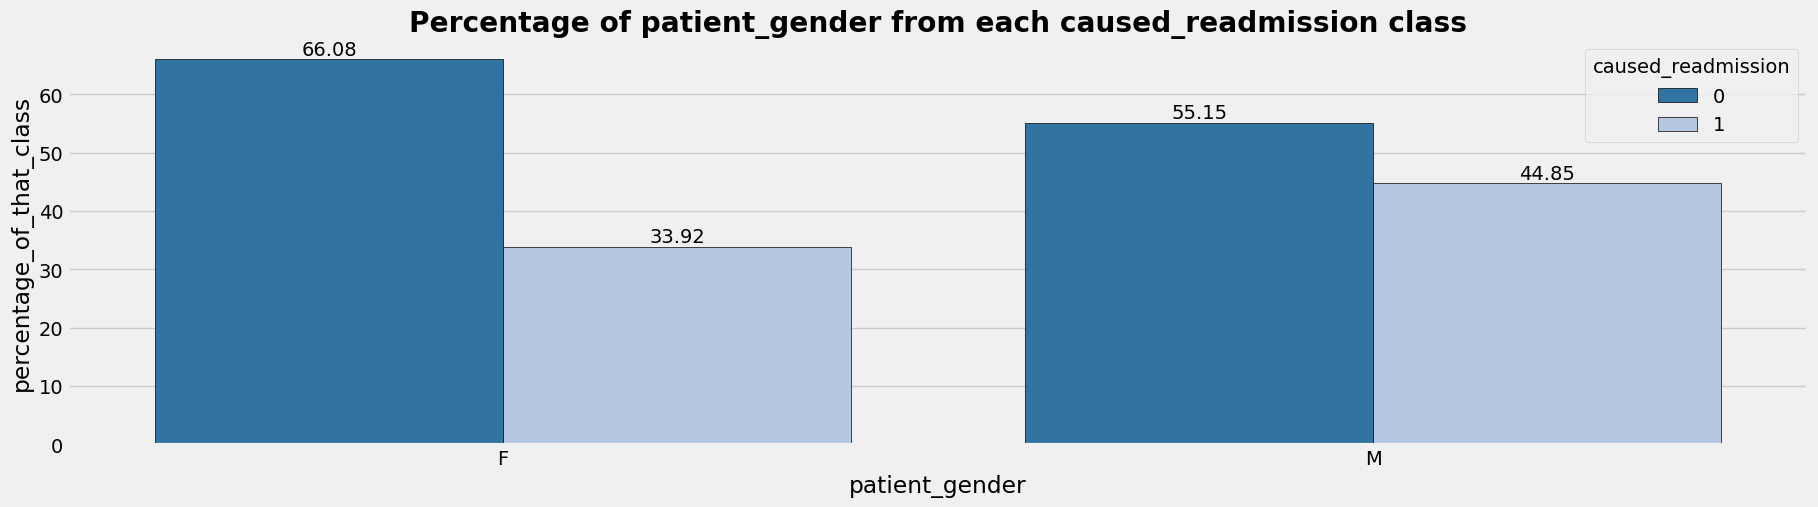

In [92]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='patient_gender',data=data,target='caused_readmission',orient='v')

In [93]:
S.chi_sqared_test(pd.crosstab(data['patient_gender'],data['caused_readmission']))

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.112 → Moderate


***
- ***by visuals we saw that `M patient gender have slightly more values in caused_readmission`, after doing statistical test we can validate this assumption wit `moderate strength`***
***

**provider_gender**

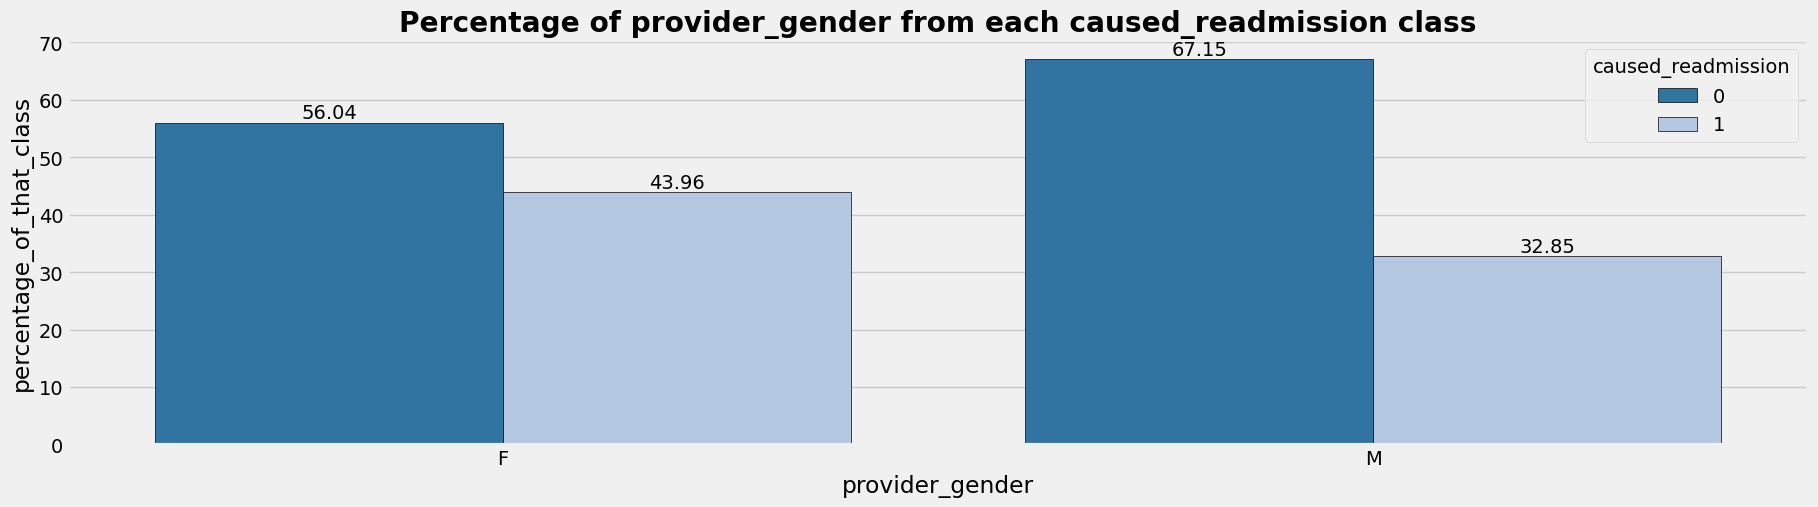

In [94]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='provider_gender',data=data,target='caused_readmission',orient='v')

In [95]:
S.chi_sqared_test(pd.crosstab(data['provider_gender'],data['caused_readmission']))

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.112 → Moderate


***
- ***by visuals we saw that `F provider gender have slightly more values in caused_readmission`, after doing statistical test we can validate this assumption with `moderate strength`***
***

**base_encounter_cost**

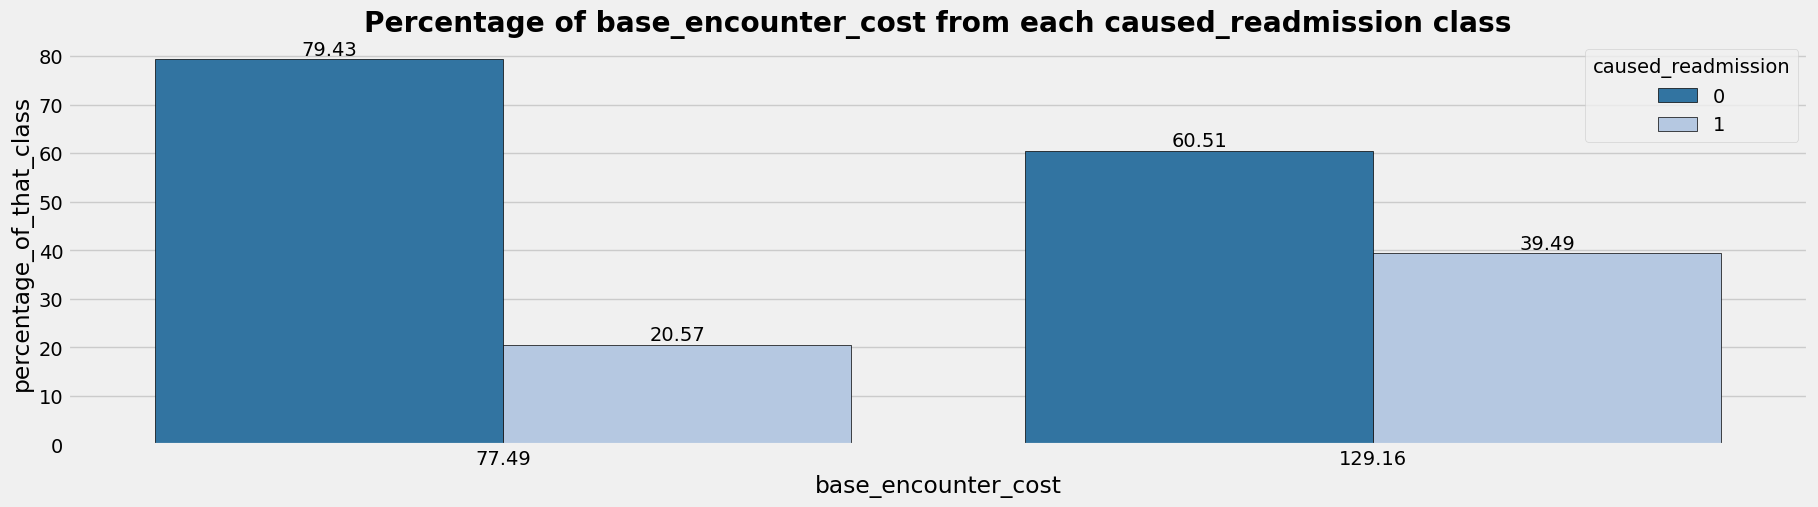

In [96]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='base_encounter_cost',data=data,target='caused_readmission',orient='v')

In [97]:
S.chi_sqared_test(pd.crosstab(data['base_encounter_cost'],data['caused_readmission']))

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.034 → Weak


- **nothing specific found from base encounter cost, have very weak relationship with caused readmission column**

**reason_for_medications**

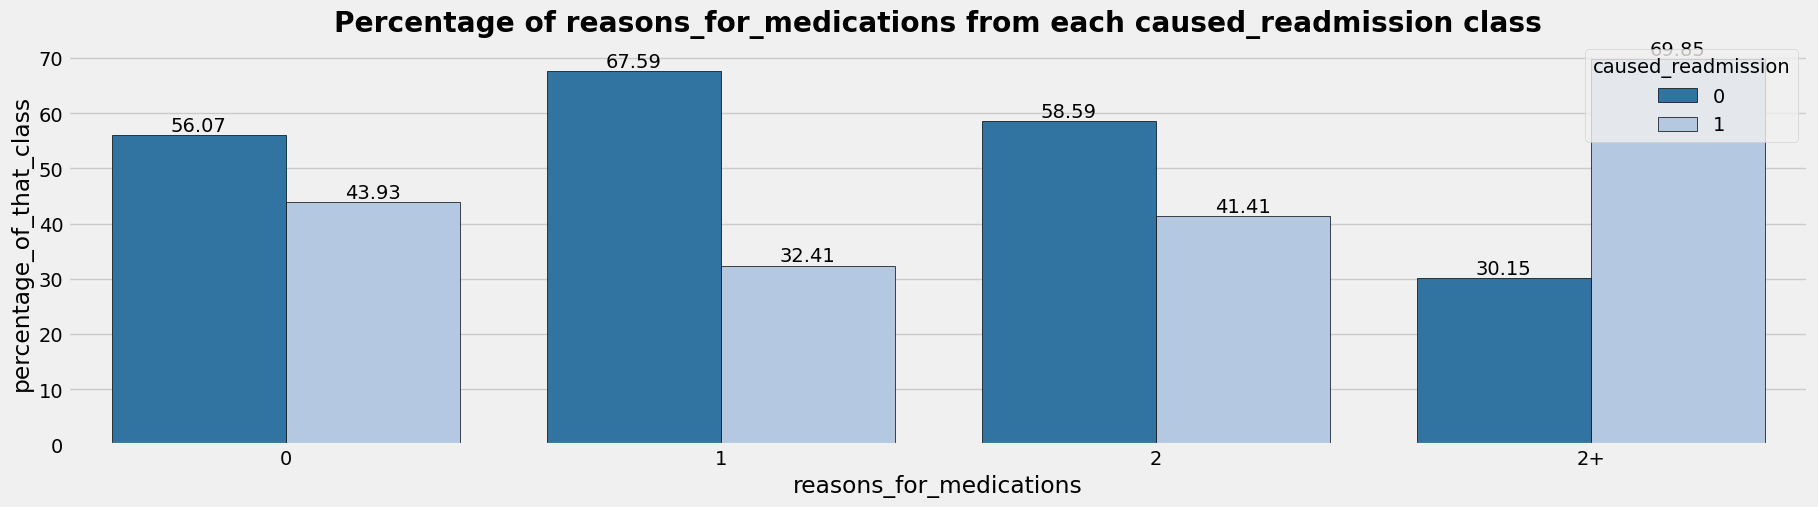

In [98]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='reasons_for_medications',data=data,target='caused_readmission',orient='v')

In [99]:
reason_for_medication_mask = (data['reasons_for_medications']=='2+')
ct = pd.crosstab(reason_for_medication_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.031 → Weak


- **we do not see anything specific**

**is_ongoing_condition**

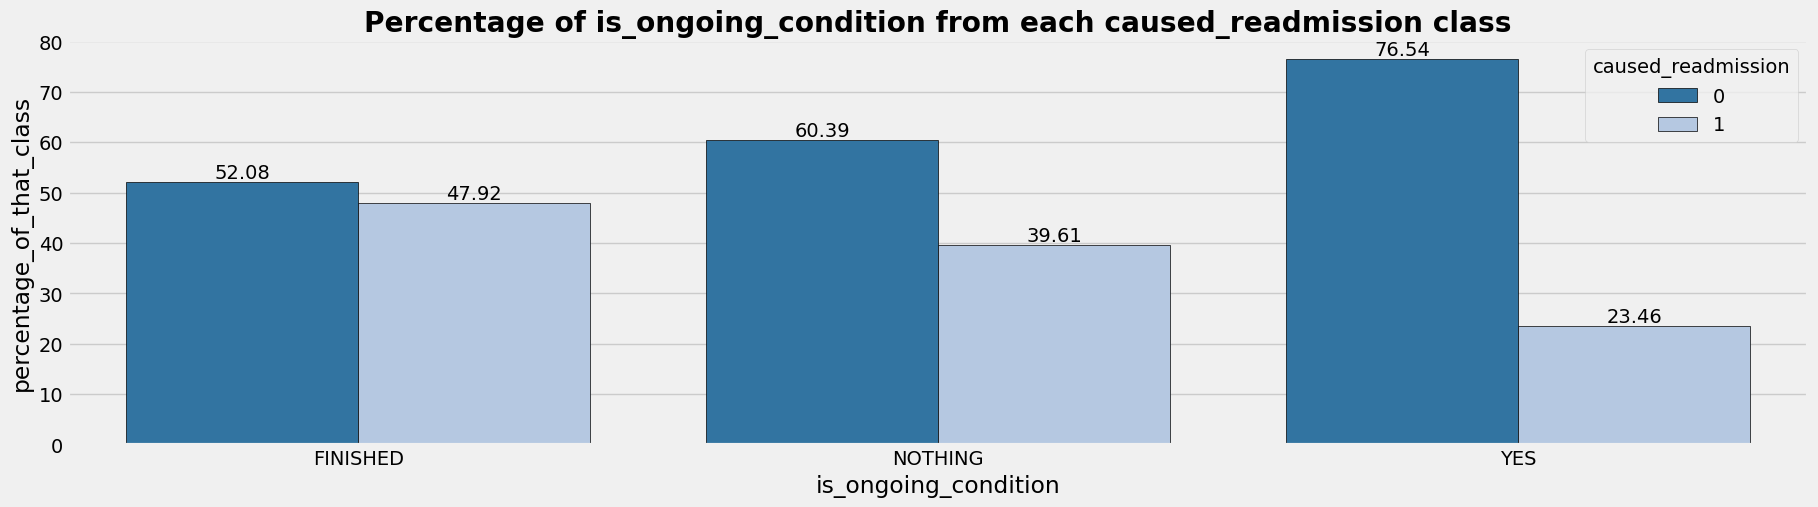

In [100]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='is_ongoing_condition',data=data,target='caused_readmission',orient='v')

In [101]:
is_ongoing_condition_mask = (data['is_ongoing_condition']=='FINISHED')
ct = pd.crosstab(is_ongoing_condition_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.053 → Weak


In [102]:
ct = pd.crosstab(data['is_ongoing_condition'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.094 → Weak


**we dont see any thing specific, both columns have very weak relationship**

**is_ongoing_careplan**

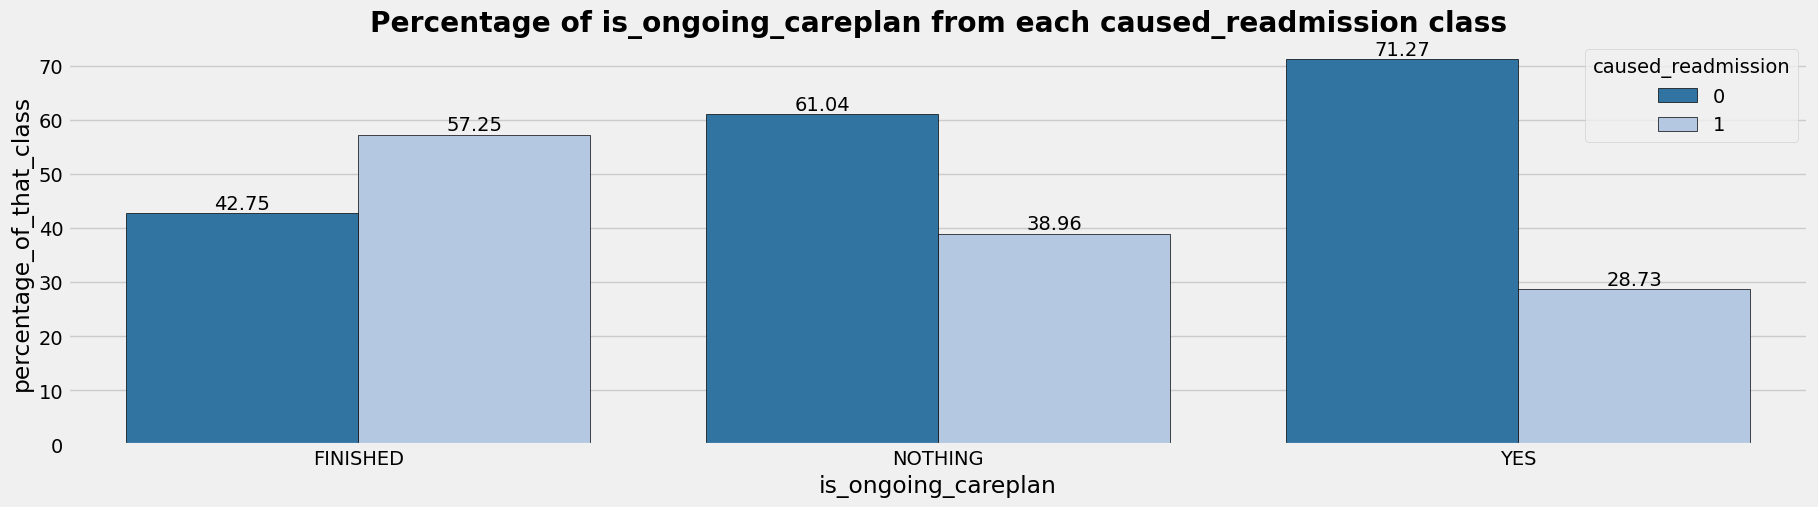

In [103]:
plt.figure(figsize=(20,5))
P.percentage_in_that_class(column='is_ongoing_careplan',data=data,target='caused_readmission',orient='v')

In [104]:
ongoing_careplan_mask = (data['is_ongoing_careplan']=='FINISHED')
ct = pd.crosstab(ongoing_careplan_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.071 → Weak


- **ongoing careplan have weak relationship with the caused readmission column**

**total_careplans**

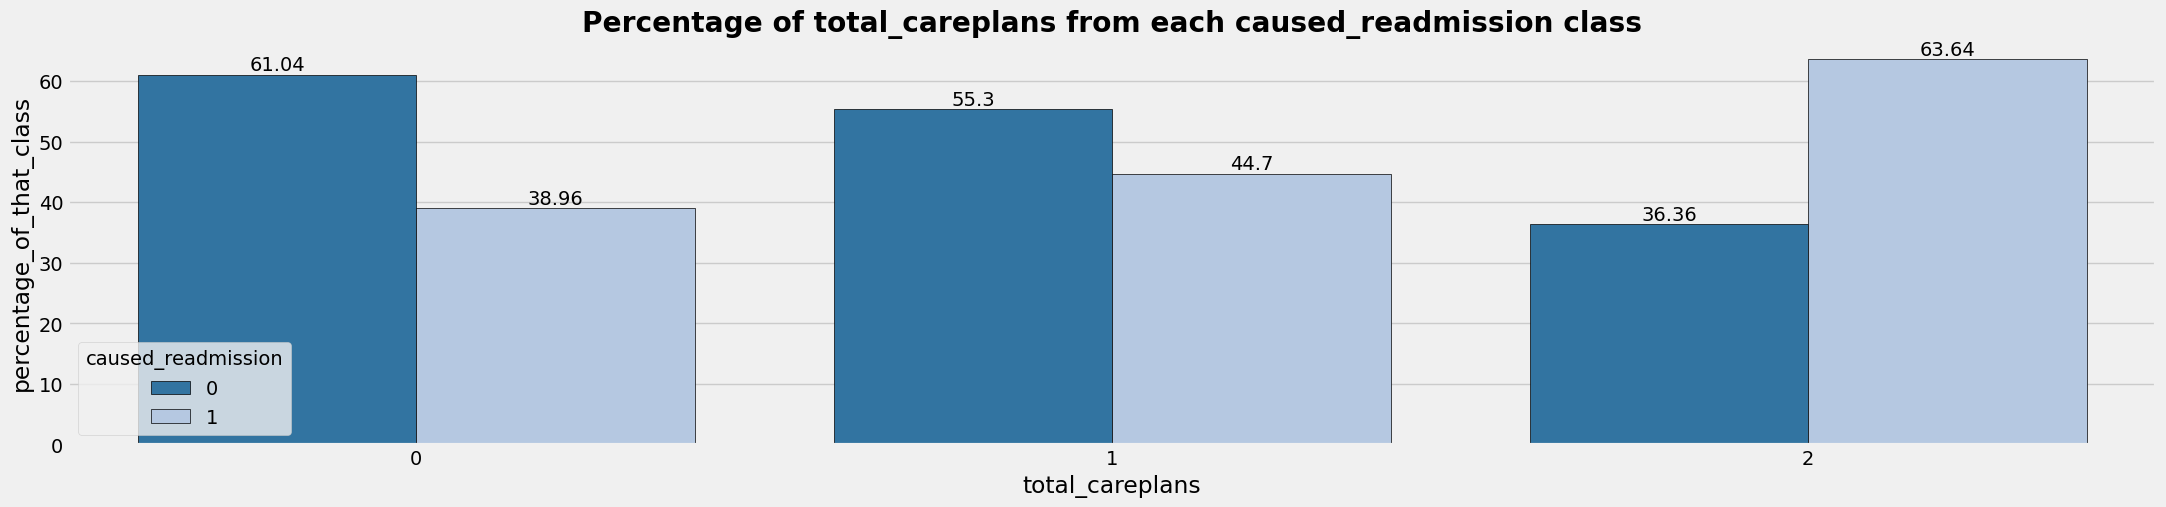

In [105]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_careplans',data=data,target='caused_readmission',orient='v')

In [106]:
total_careplan_mask = (data['total_careplans']==2)
ct = pd.crosstab(total_careplan_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.17983
Fail to reject null (groups similar)
Cramer's V: 0.006 → Weak


- **there is very weak associatation**

***

**total_procedures**

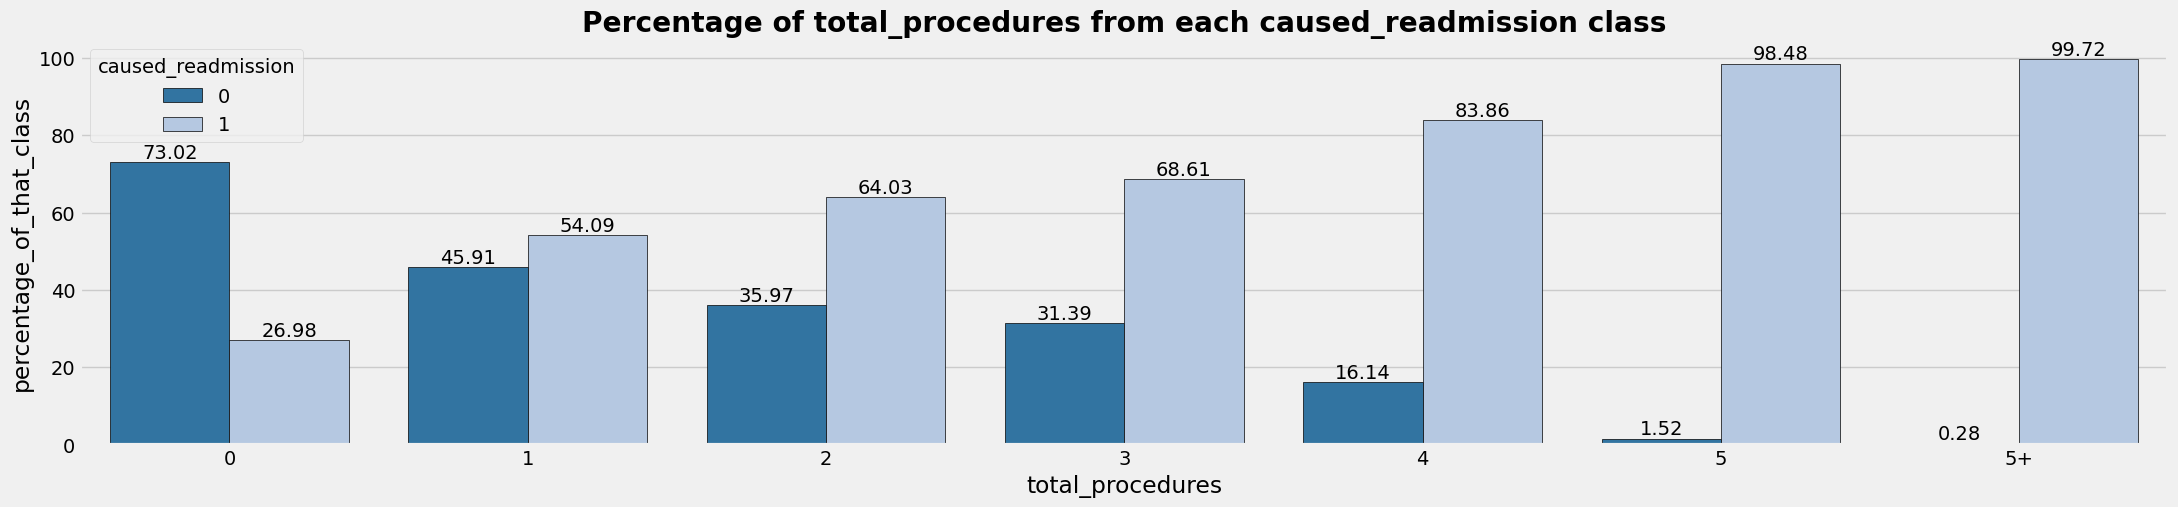

In [107]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_procedures',data=data,target='caused_readmission',orient='v')

In [108]:
ct = pd.crosstab(data['total_procedures'],data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.335 → Strong


***
- ***visuals showed that `more the procedures, the more the causing of readmission`, after doing statistical test we can validate this assumption with `strong strength`***
***

**total_conditions**

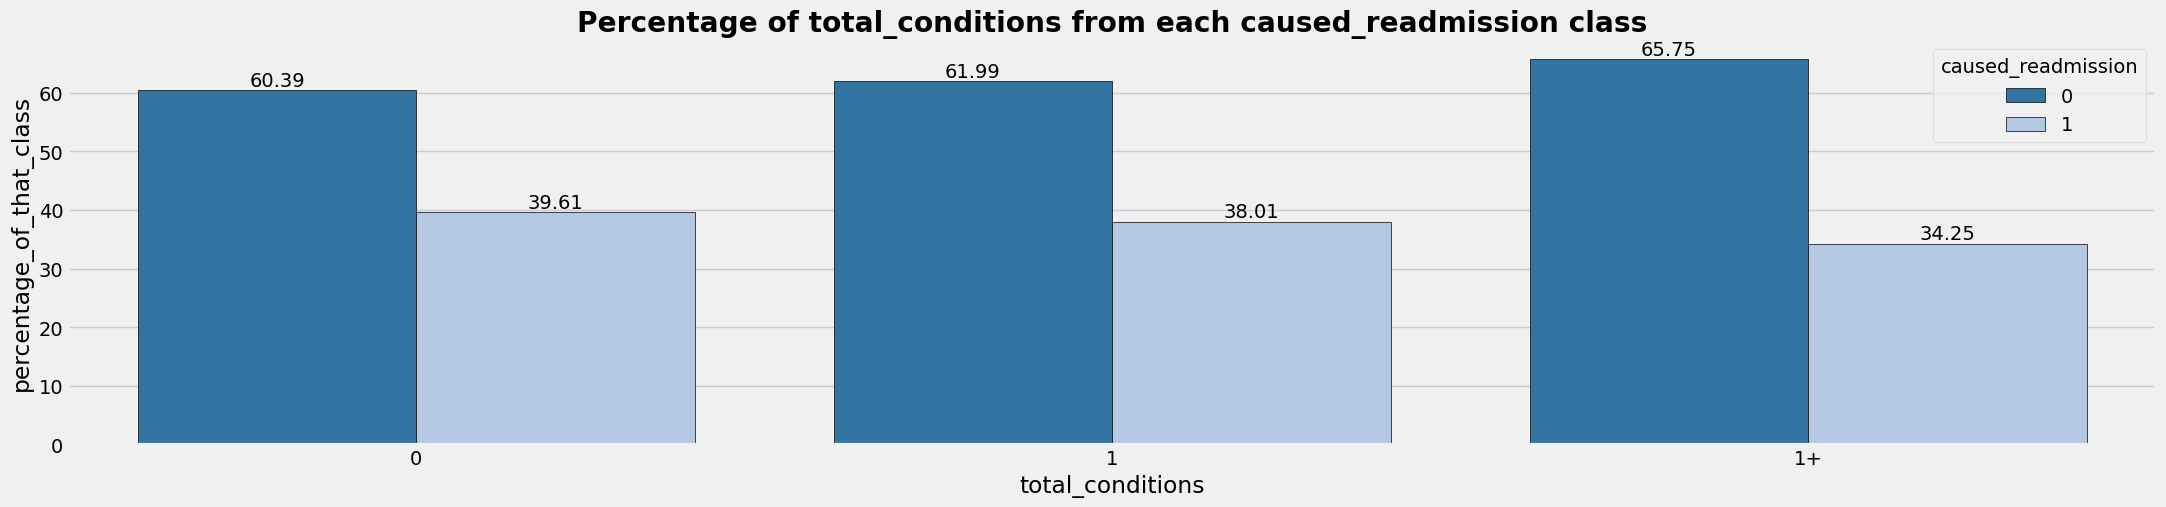

In [109]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_conditions',data=data,target='caused_readmission',orient='v')

- **we do not see anything specific**

**total_medicines**

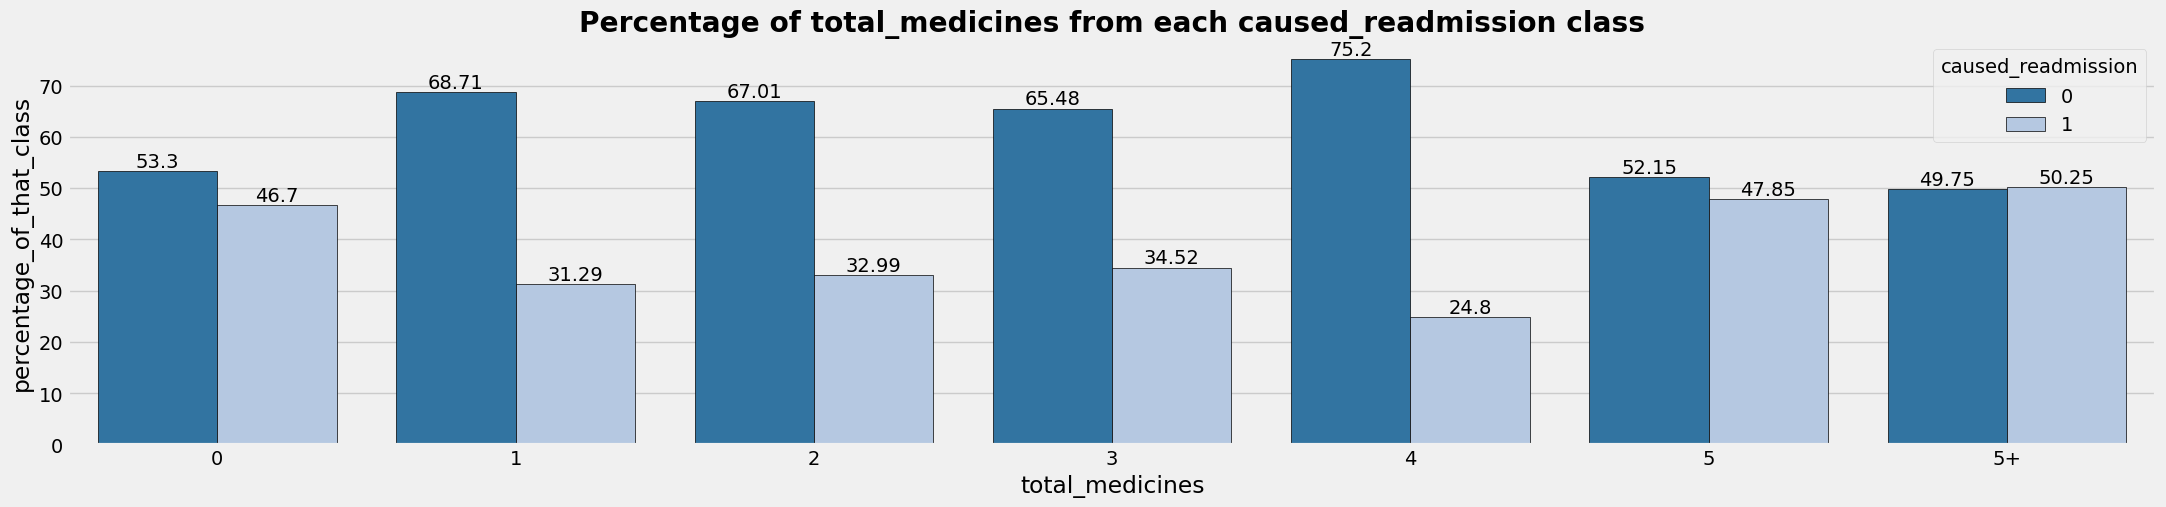

In [110]:
plt.figure(figsize=(24,5))
P.percentage_in_that_class(column='total_medicines',data=data,target='caused_readmission',orient='v')

In [111]:
total_medicine_mask = (data['total_medicines']=='5') | (data['total_medicines']=='5+') | (data['total_medicines']=='0')
ct = pd.crosstab(total_medicine_mask,data['caused_readmission'])

S.chi_sqared_test(ct)

Chi-square p-value: 0.00000
Reject null (groups different)
Cramer's V: 0.155 → Moderate


***
- ***visuals showed that` when no medicine was provider or 5 or more than 5 medicines were provided, then there were more values in cause readmission`, after doing statistical test we can validate this assumption with `moderate strength`***
***

### ***Numerical Columns with target***

**avg_procedure_cost**

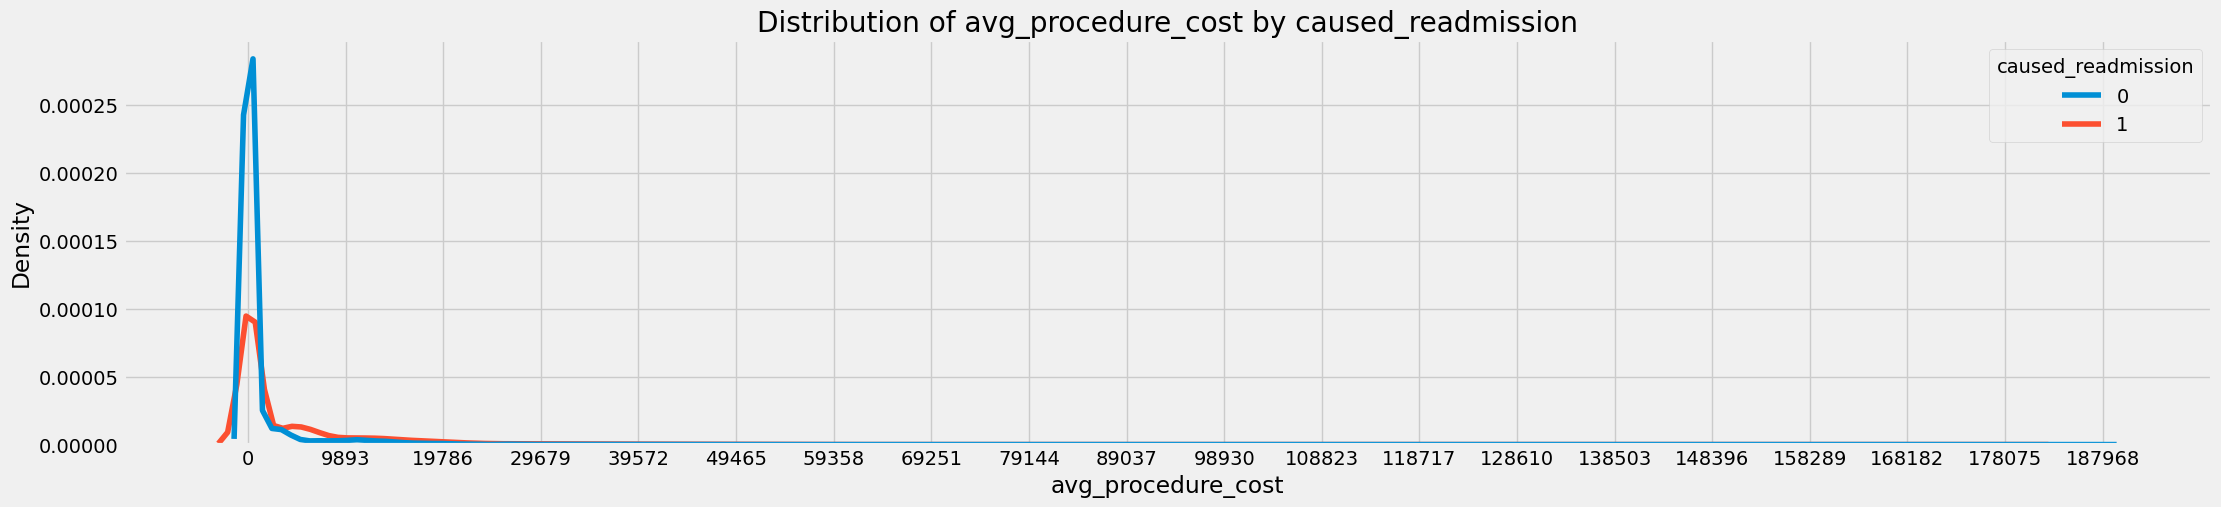

In [112]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='avg_procedure_cost',data= data,target='caused_readmission')

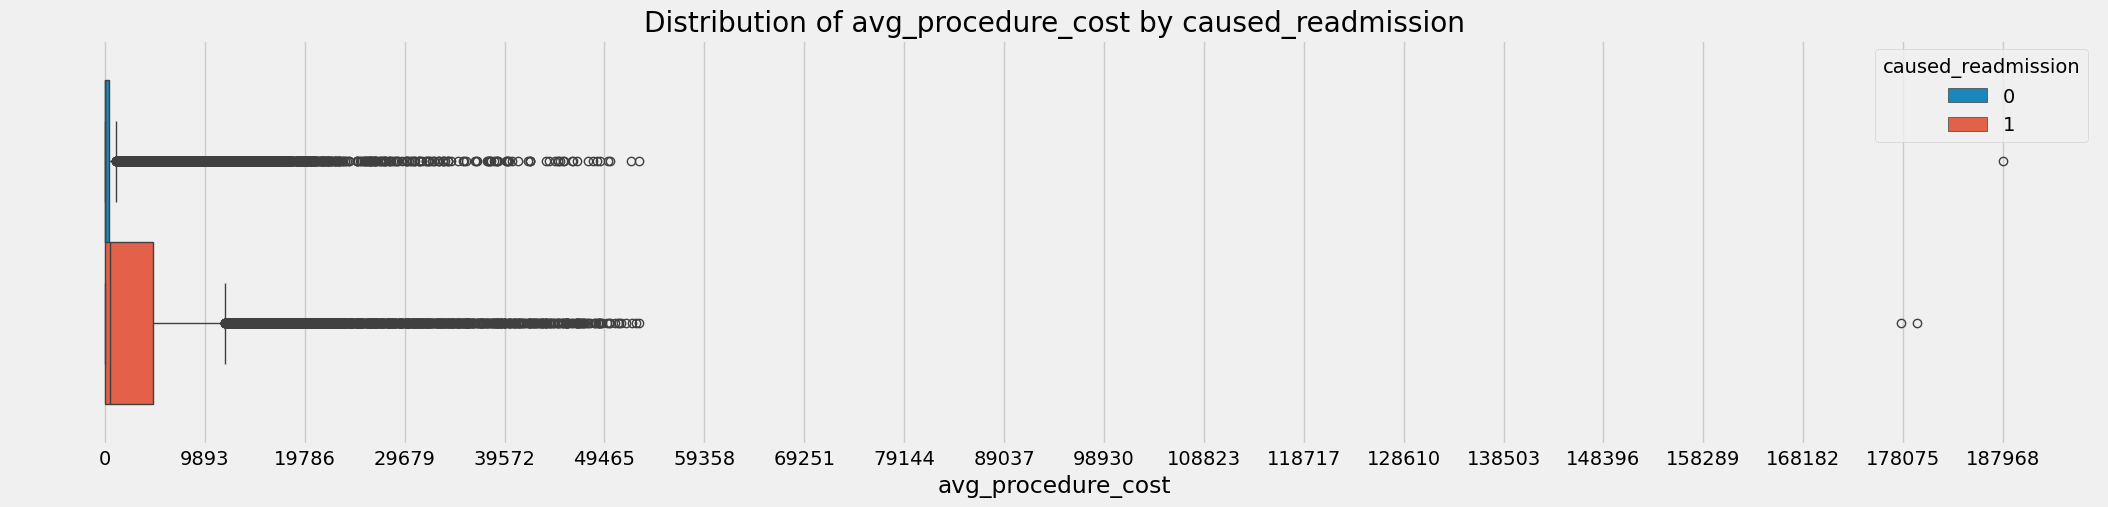

In [113]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='avg_procedure_cost',data= data,target='caused_readmission')

In [114]:
data.groupby('caused_readmission')['avg_procedure_cost'].describe().round(2).T

caused_readmission          0          1
count                32361.00   20985.00
mean                  1078.99    3749.38
std                   3760.78    7312.78
min                      0.00       0.00
25%                      0.00       0.00
50%                      0.00     516.65
75%                    446.31    4758.14
max                 187968.69  179470.09

In [115]:
S.numerical_test(data,'caused_readmission','avg_procedure_cost',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: weak


- **we do not find anything specific**

**avg_base_medicine_cost**

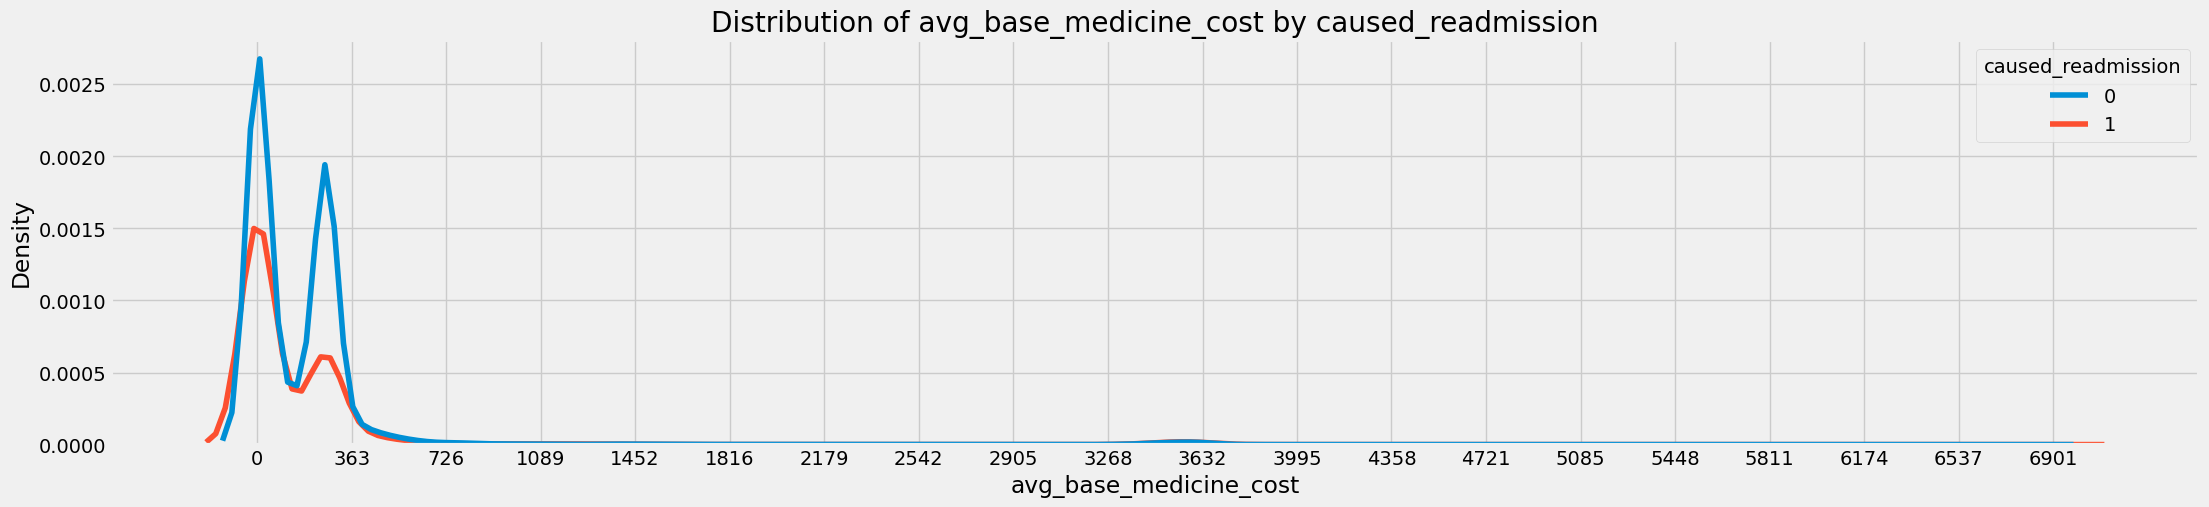

In [116]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='avg_base_medicine_cost',data= data,target='caused_readmission')

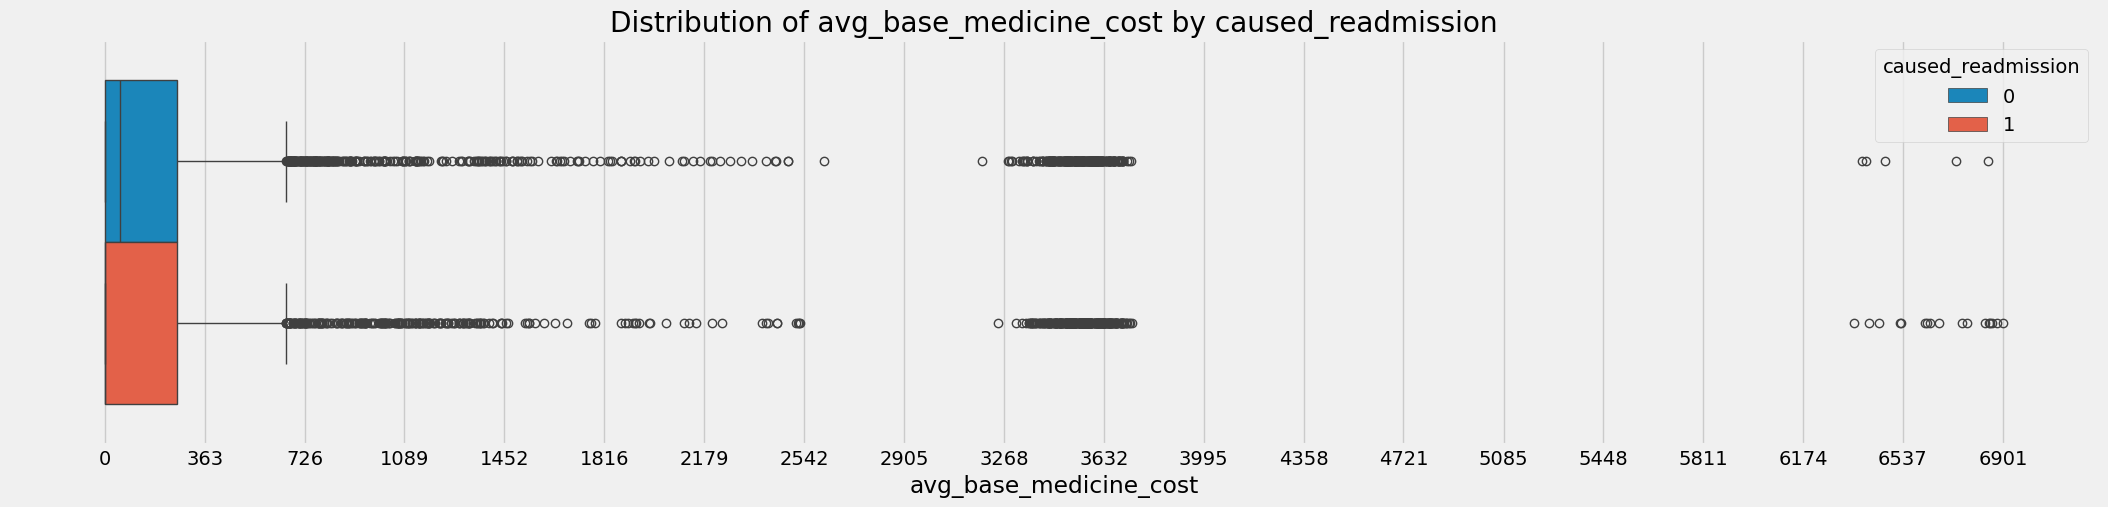

In [117]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='avg_base_medicine_cost',data= data,target='caused_readmission')

In [118]:
data.groupby('caused_readmission')['avg_base_medicine_cost'].describe().round(2).T

caused_readmission         0         1
count               32361.00  20985.00
mean                  164.64    159.46
std                   353.47    477.39
min                     0.00      0.00
25%                     0.00      0.00
50%                    56.09      0.00
75%                   263.49    263.49
max                  6845.44   6901.17

In [119]:
S.numerical_test(data,'caused_readmission','avg_base_medicine_cost',1)

Data has normal distribution so doing ttest_ind ->
Data has equal variance
T-test p-value: 0.15052 → Fail to reject null (groups similar)
Strength of ttest: very weak


- **we do not see any specific pattern, relationship is also very weak**

**avg_total_medicine_cost**

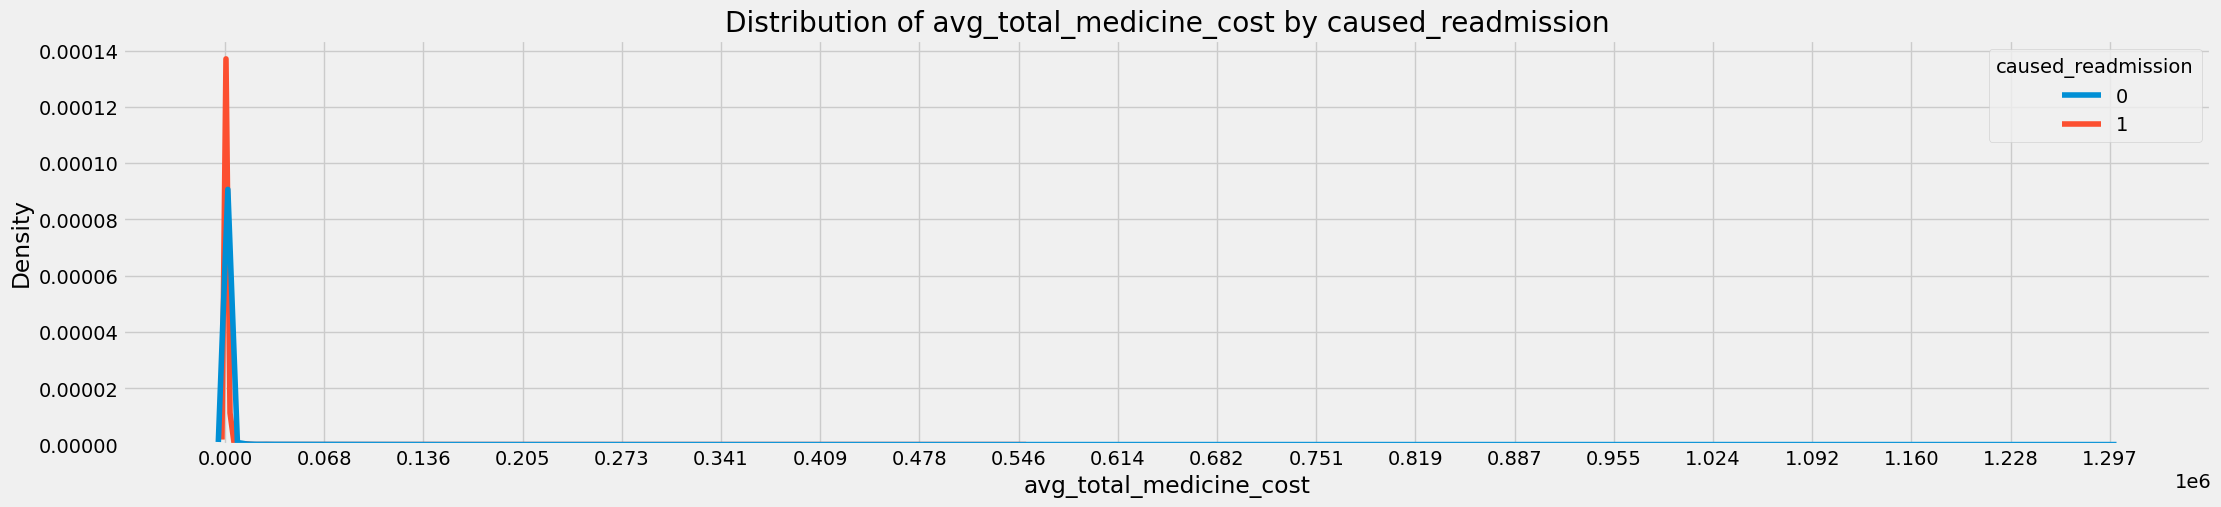

In [120]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='avg_total_medicine_cost',data= data,target='caused_readmission')

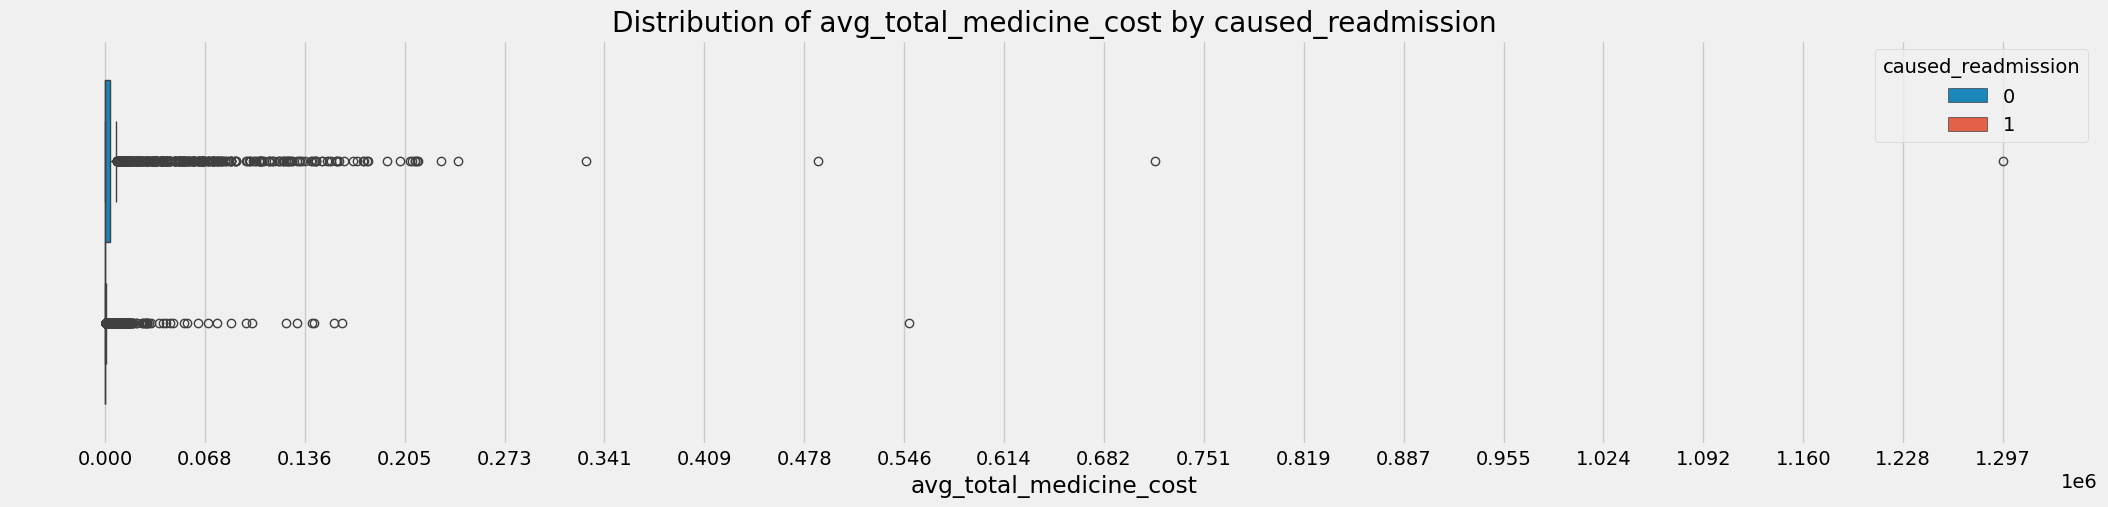

In [121]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='avg_total_medicine_cost',data= data,target='caused_readmission')

In [122]:
data.groupby('caused_readmission')['avg_total_medicine_cost'].describe().round(2).T

caused_readmission           0          1
count                 32361.00   20985.00
mean                   2021.88     521.54
std                   12063.98    4996.15
min                       0.00       0.00
25%                       0.00       0.00
50%                     294.89       0.00
75%                    3161.88     263.49
max                 1296594.95  549067.89

In [123]:
S.numerical_test(data,'caused_readmission','avg_total_medicine_cost',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: very weak


**we dont see anything specific and the relationship is also very weak**

**age_as_2022**

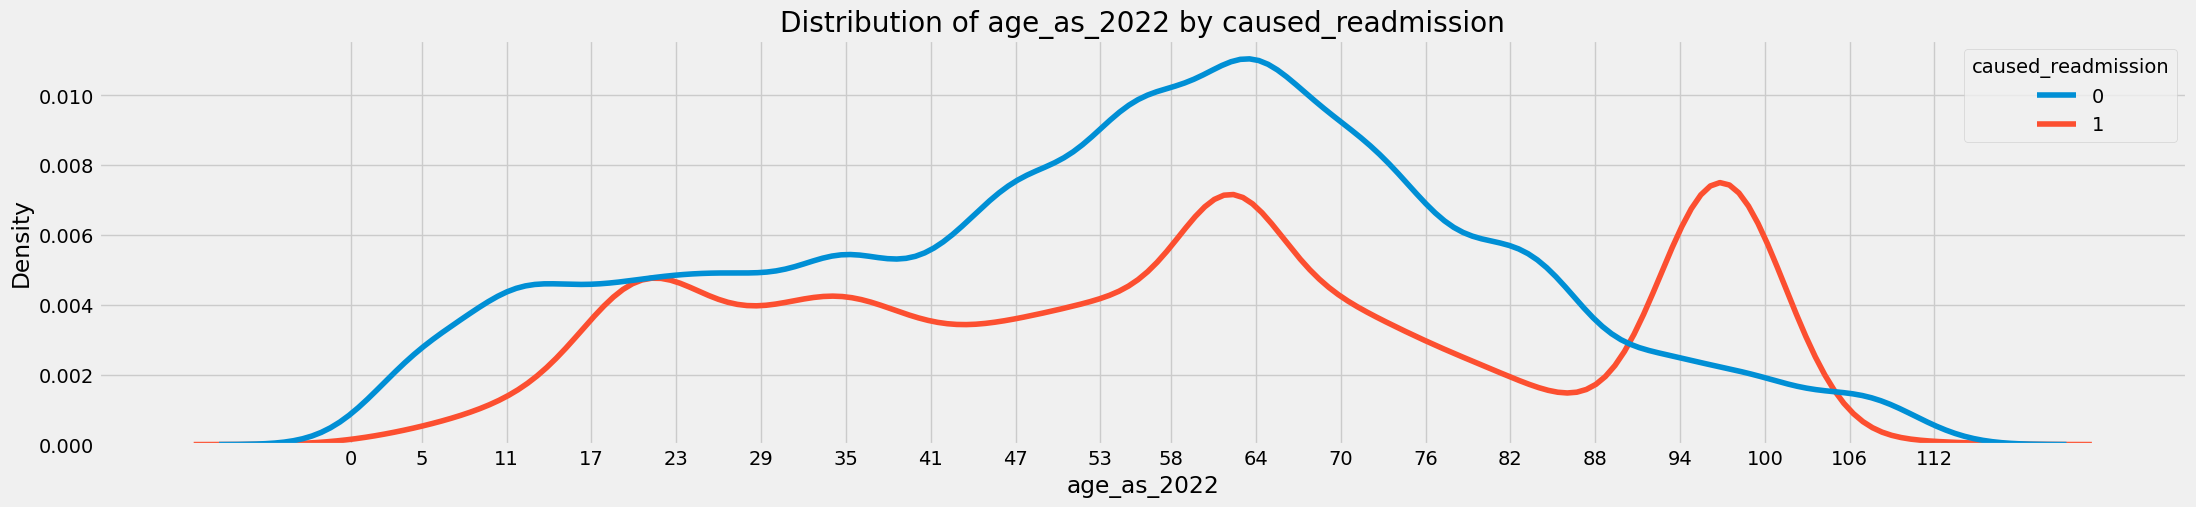

In [124]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='age_as_2022',data= data,target='caused_readmission')

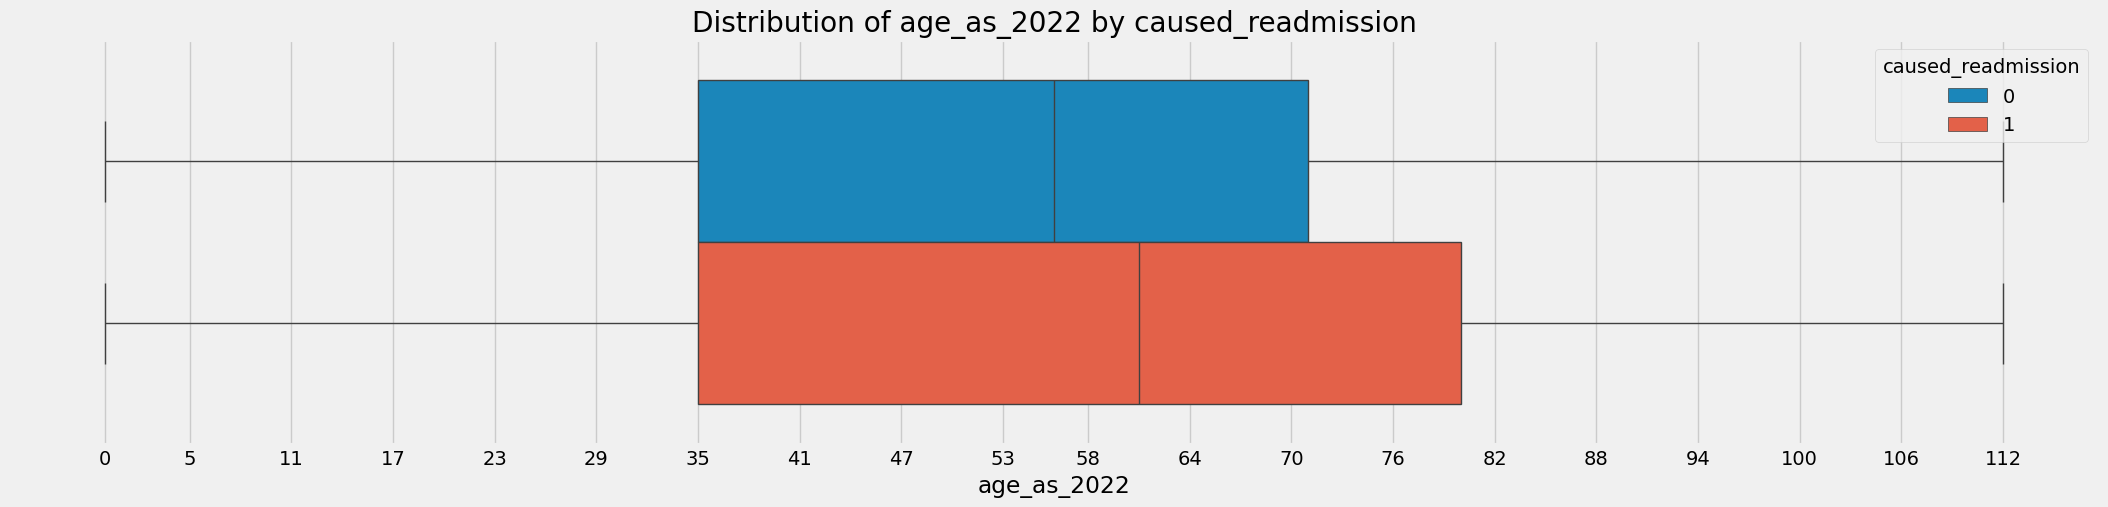

In [125]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='age_as_2022',data= data,target='caused_readmission')

In [126]:
data.groupby('caused_readmission')['age_as_2022'].describe().round(2).T

caused_readmission         0         1
count               32361.00  20985.00
mean                   53.89     58.38
std                    24.84     27.16
min                     0.00      0.00
25%                    35.00     35.00
50%                    56.00     61.00
75%                    71.00     80.00
max                   112.00    112.00

In [127]:
S.numerical_test(data,'caused_readmission','age_as_2022',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: very weak


- **we saw a difference in mean, but statistical test says a very weak relationship**

**utilization**

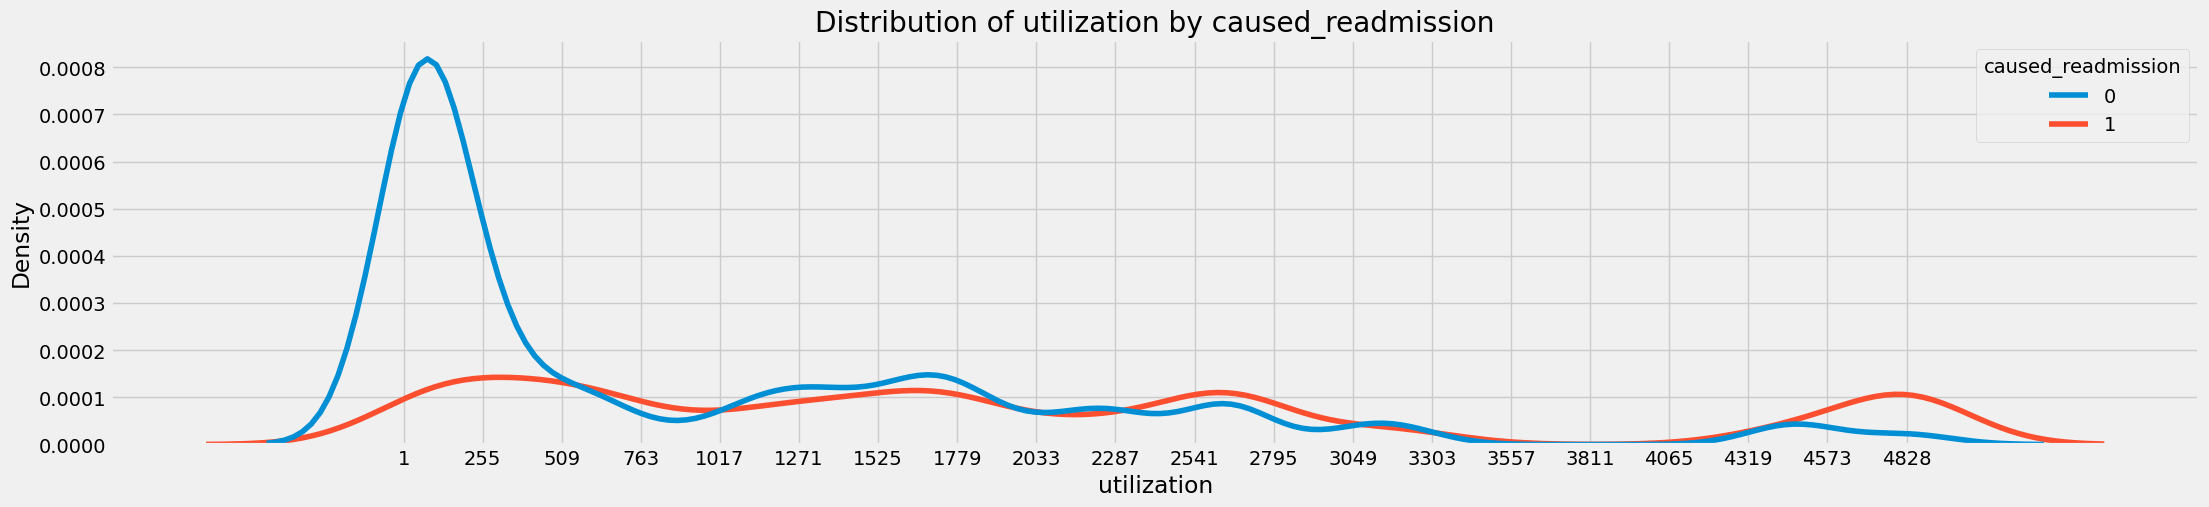

In [128]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='utilization',data= data,target='caused_readmission')

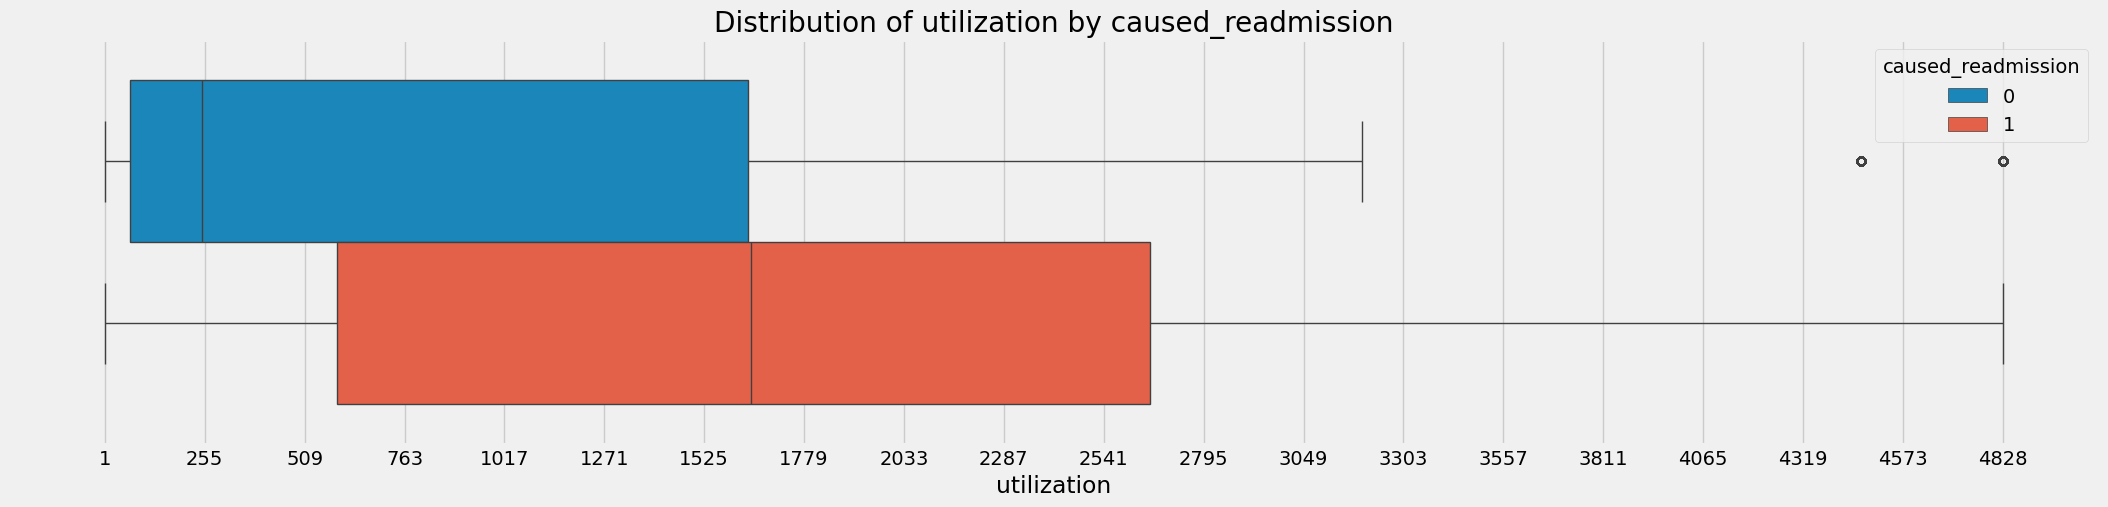

In [129]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='utilization',data= data,target='caused_readmission')

In [130]:
data.groupby('caused_readmission')['utilization'].describe().round(2).T

caused_readmission         0         1
count               32361.00  20985.00
mean                  917.01   1966.10
std                  1172.65   1547.18
min                     2.00      1.00
25%                    64.00    590.00
50%                   248.00   1643.00
75%                  1636.00   2658.00
max                  4828.00   4828.00

In [131]:
S.numerical_test(data,'caused_readmission','utilization',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00000 → Reject null (groups different)
Strength of ttest: medium


***
- ***visuals showed that `utilization value in higher end is more into caused readmission`, after doing statistical test we can validate this relationship with `medium strength`***
***

**condition_duration**

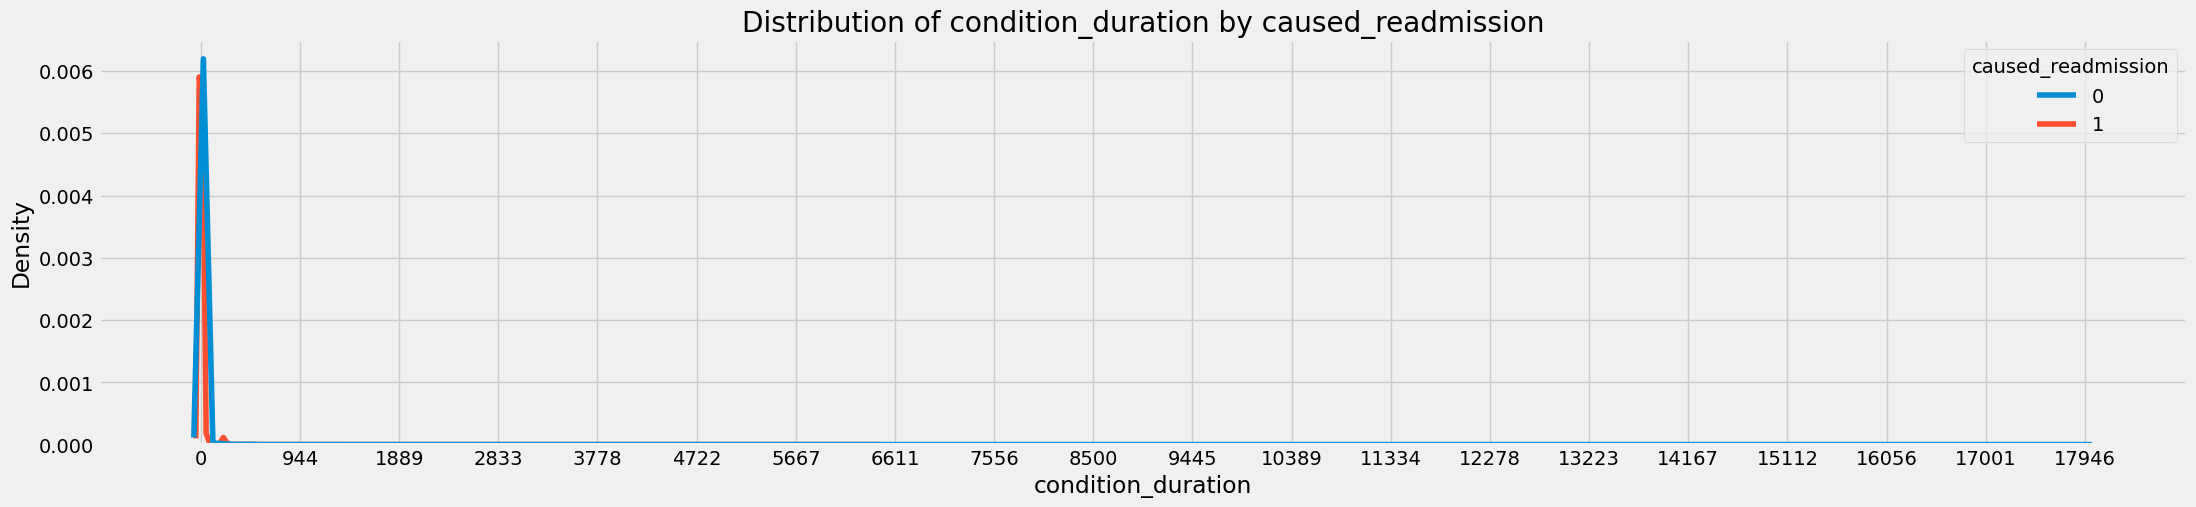

In [132]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='condition_duration',data= data,target='caused_readmission')

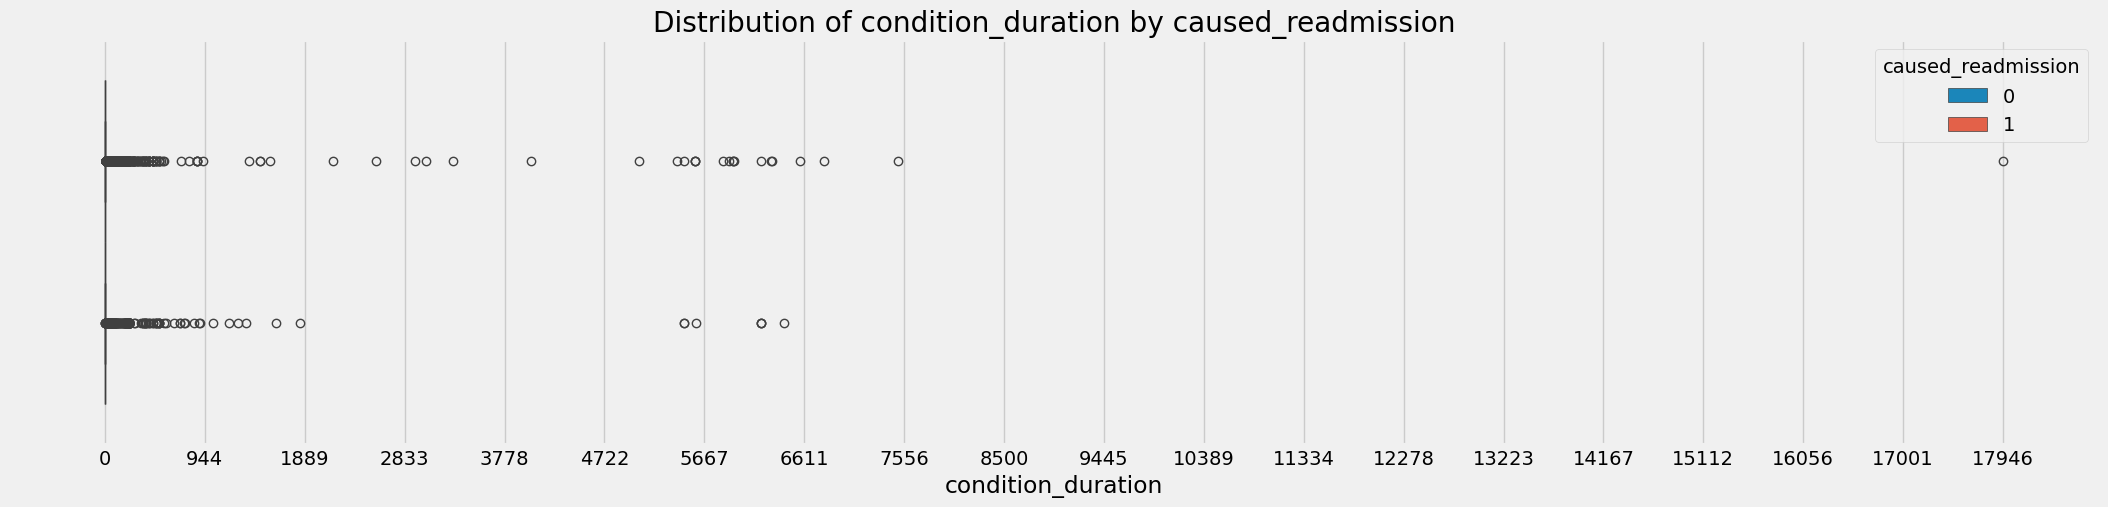

In [133]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='condition_duration',data= data,target='caused_readmission')

In [134]:
data.groupby('caused_readmission')['condition_duration'].describe().round(2).T

caused_readmission        0        1
count               32361.0  20985.0
mean                   7.28     7.74
std                  177.63   116.11
min                     0.0      0.0
25%                     0.0      0.0
50%                     0.0      0.0
75%                     0.0      0.0
max                 17946.0   6418.0

- **nothing specific found**

**careplan_duration**

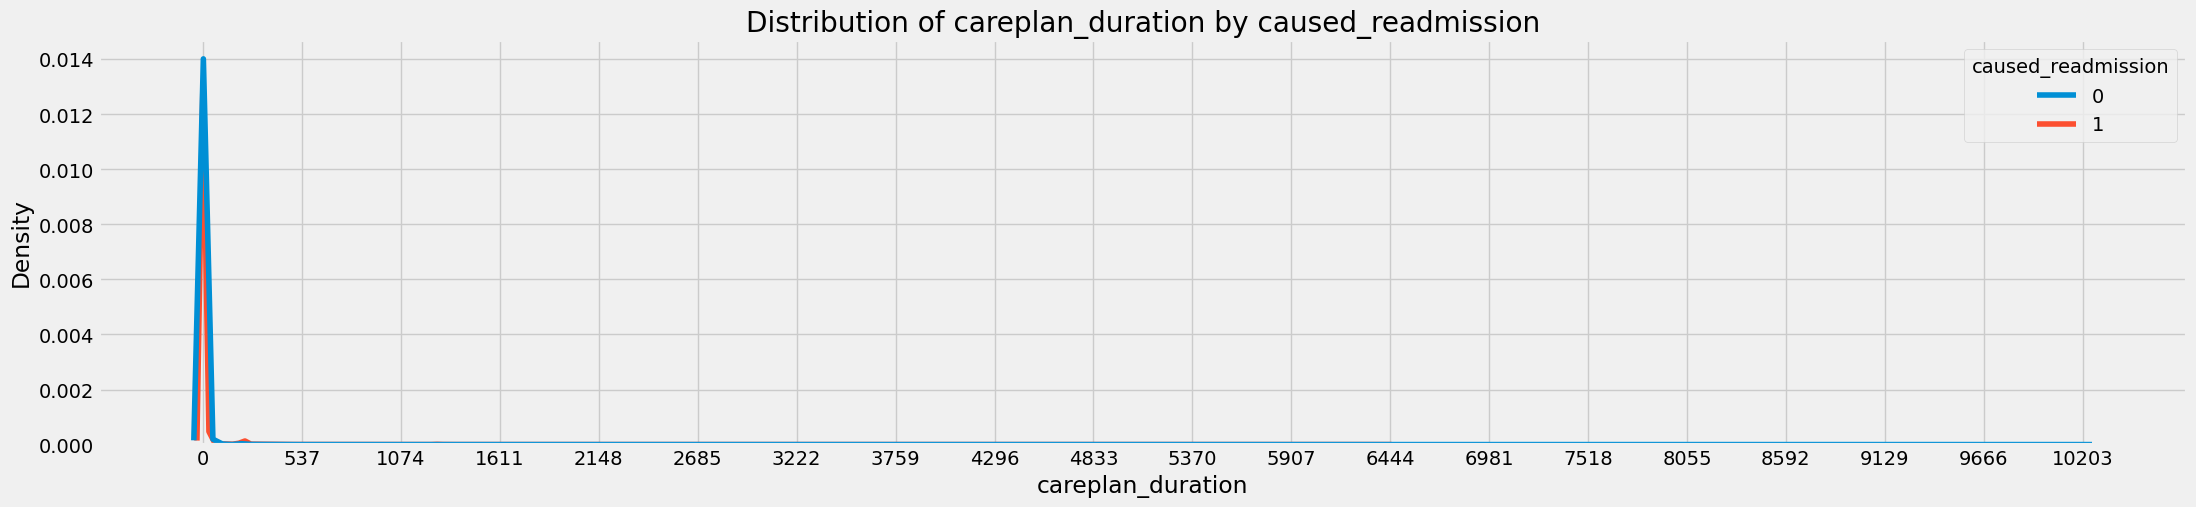

In [135]:
plt.figure(figsize=(24,5))
P.kde_in_all_class(column='careplan_duration',data= data,target='caused_readmission')

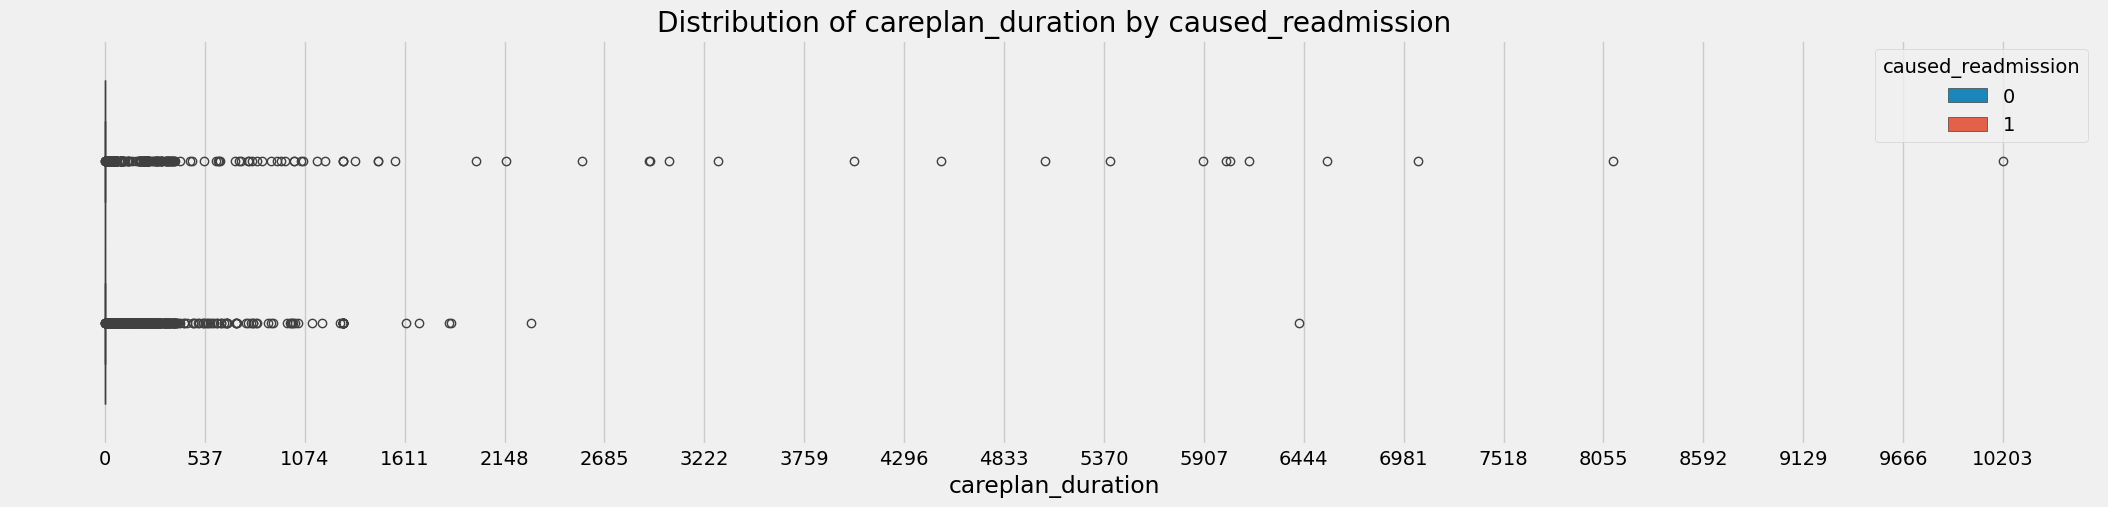

In [136]:
plt.figure(figsize=(24,5))
P.box_in_all_class(column='careplan_duration',data= data,target='caused_readmission')

In [137]:
data.groupby('caused_readmission')['careplan_duration'].mean().round(2)

caused_readmission
0     5.5
1    9.49
Name: careplan_duration, dtype: Float64

In [138]:
S.numerical_test(data,'caused_readmission','careplan_duration',1)

Data has normal distribution so doing ttest_ind ->
Data do not have equal variance
Doing ttest - with equal variance false...
T-test p-value: 0.00002 → Reject null (groups different)
Strength of ttest: very weak


- **nothing too specific, but groups are different**